In [4]:
import os
import itertools
import xlsxwriter

import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import statsmodels.api as sm 
import matplotlib.pyplot as plt

import DataPreparation as dpr
import Models
import benchmarks as bench
from MyEstimators import CLS_Estimator

<Figure size 720x360 with 0 Axes>

# Load data

In [5]:
df = pd.read_excel('data/EQP_Quarterly.xlsx', index_col = 0)

In [6]:
df = df.dropna()
df['yyyyq'] = df['yyyyq'].astype('int32')

In [7]:
df['time'] = [pd.to_datetime(str(x)[:4]) + pd.offsets.QuarterEnd(int(str(x)[4:])) for x in df['yyyyq']]
df = df.set_index('time')
df = df.drop(['yyyyq'], axis = 1)

In [8]:
df = df.loc['1956-03-31':'2018-12-31']

## Add new cay variable and construct X and y

In [9]:
df['new_cay'] = df['c'] - 0.218*df['w'] - 0.801*df['y']

**The dataset has been processed and all the variables except for stock return has been taken one lag.

In [10]:
df.head()

EQP     y_lag    y_2lag        DP        DY        EP  \
time                                                                     
1956-03-31  0.066512  0.047768  0.063101 -3.322576 -3.281965 -2.530799   
1956-06-30 -0.028264  0.066512  0.047768 -3.333030 -3.269151 -2.575525   
1956-09-30 -0.034415 -0.028264  0.066512 -3.261722 -3.293365 -2.568575   
1956-12-31  0.033241 -0.034415 -0.028264 -3.204645 -3.239744 -2.573142   
1957-03-31 -0.050750  0.033241 -0.034415 -3.289216 -3.260525 -2.616389   

                  DE      svar       b/m      ntis  ...      infl         c  \
time                                                ...                       
1956-03-31 -0.791778  0.005084  0.509828  0.025245  ... -0.003717  9.274968   
1956-06-30 -0.757505  0.003289  0.531077  0.026695  ...  0.000000  9.272498   
1956-09-30 -0.693147  0.003688  0.551565  0.025672  ...  0.014925  9.271728   
1956-12-31 -0.631503  0.002519  0.571910  0.029362  ...  0.007353  9.269304   
1957-03-31 -0.672827  0.004394  0.544177  0.026149  ...  0.007299  9.277993   

                    w         y       cay     AAA     BAA        rr     rfree  \
time                                                                            
1956-03-31  11.074455  9.093439  0.019292  0.0315  0.0362  0.075561  0.006350   
1956-06-30  11.092725  9.100386  0.007275  0.0310  0.0360 -0.022400  0.005625   
1956-09-30  11.091665  9.107828  0.000775  0.0326  0.0376 -0.027815  0.006225   
1956-12-31  11.086198  9.106428  0.000663  0.0356  0.0407  0.041139  0.007100   
1957-03-31  11.096678  9.118405 -0.002524  0.0375  0.0437 -0.041856  0.008025   

             new_cay  
time                  
1956-03-31 -0.423108  
1956-06-30 -0.435125  
1956-09-30 -0.441626  
1956-12-31 -0.441736  
1957-03-31 -0.444925  

[5 rows x 26 columns]

## Plots of Variables

In [ ]:
fig = plt.figure(figsize = (10,8))
plt.plot(df['DP'], label='DP')
plt.plot(df['DY'], label='DY')
        
# plt.title('co1', fontsize=20)
plt.legend(fontsize=16)
plt.savefig('co1.png')

In [ ]:
fig = plt.figure(figsize = (10,8))
plt.plot(df['tbl'], label = 'tbl')
plt.plot(df['lty'], label = 'lty')
        
# plt.title('co2', fontsize=20)
plt.legend(fontsize=16)
plt.savefig('co2.png')

In [ ]:
fig = plt.figure(figsize = (10,8))
plt.plot(df['DP'], label = 'dp')
plt.plot(df['EP'], label = 'ep')
        
# plt.title('co3', fontsize=20)
plt.legend(fontsize=16)
plt.savefig('co3.png')

In [ ]:
fig = plt.figure(figsize = (10,8))
plt.plot(df['BAA'], label = 'BAA')
plt.plot(df['AAA'], label = 'AAA')
        
# plt.title('co4', fontsize=20)
plt.legend(fontsize=16)
plt.savefig('co4.png')

In [ ]:
fig = plt.figure(figsize = (10,8))
plt.plot(df['c'], label = 'log of consumption')
plt.plot(df['w'], label = 'log of wealth')
plt.plot(df['y'], label = 'log of income')
        
# plt.title('cay', fontsize=20)
plt.legend(fontsize=16)
plt.savefig('cay.png')

In [ ]:
fig = plt.figure(figsize = (10,8))
plt.plot(df['new_cay'], label = '"cay" variable')
        
# plt.title('cay', fontsize=20)
plt.legend(fontsize=16)
plt.savefig('new_cay.png')

## Full sample linear regression

In [ ]:
lr = LinearRegression()
lr.fit(df[['y_lag', 'new_cay']], df['EQP'])

In [ ]:
lr.coef_

In [ ]:
lr.intercept_

## Regression with dy-dp

In [ ]:
dpdy = df['DY']-df['DP']

In [ ]:
lr = LinearRegression()
lr.fit(dpdy.values.reshape(-1,1), df['EQP'].values.reshape(-1,1))

In [ ]:
lr.coef_

In [ ]:
lr.intercept_

## Set up Nonlienar Models

In [11]:
extra_params = {'sin_func':1,
               'cos_func':1,
               'scaled_sin_func':2,
               'scaled_cos_func':2,
               'exp_func':2,
               'exp_shift_func':2,
                'poly_func':3,
                'linear_func':2
               }

In [12]:
def constraint_func(x):
    def constraint(params):
        con = 0
        for j in np.arange(0, x.shape[1]):
            con += params[j]**2
            cons = con - 1
        return cons
    return {'type':'eq', 'fun': constraint}

## Empirical Study

### Cointegrated predictors
- dividend-price ratio and dividend yield
- T-bill rate and long-term yield
- dividend-price ratio and earningprice ratio
- baa- and aaa-rated corporate bond yields

In [13]:
co1 = df[['DP', 'DY']]
co2 = df[['tbl', 'lty']]
co3 = df[['DP', 'EP']]
co4 = df[['BAA', 'AAA']]
y = df[['EQP']].squeeze()

station_ar1 = df[['y_lag', 'new_cay']]
station_n = pd.DataFrame()

cointe_ar1 = [co1, co2, co3, co4]
names_ar1 = ['co1', 'co2', 'co3', 'co4']

for i in range(len(cointe_ar1)):
    cointe_ar1[i].name = names_ar1[i]

In [11]:
X_ = co1.join(station_ar1)

### Stationary variables

### Fit model and Save Results

In [29]:
fun_list = [Models.sin_func,
            Models.cos_func,
            Models.scaled_sin_func,
            Models.scaled_cos_func,
            Models.exp_func,
            Models.exp_shift_func,
            Models.poly_func,
            Models.linear_func
           ]

In [30]:
# Set up hierachical index
fun_names = [i.__name__ for i in fun_list]
cointe_names = [i.name for i in cointe_ar1]
iterables = [fun_names, cointe_names]

In [24]:
#Set up directory
parent = os.getcwd()
folder = 'results'
path = os.path.join(parent, folder)
if not os.path.exists(path):
    os.makedirs(path)

In [41]:
results = pd.DataFrame()

for i, j in itertools.product(fun_list, cointe_ar1):
    ################################# Set up dimensions ######################################
    Models.param_num = {'theta':j.shape[1],
               'beta':station_ar1.shape[1],
               'gamma':extra_params[i.__name__]
               }
    initial_len = Models.param_num['theta']+Models.param_num['beta']+Models.param_num['gamma']
    
    # Set up dataframes
    iterables = [[i.__name__], [j.name]]
    sec_columns = ['param_'+str(i) for i in range(1,initial_len+1)]
    multi_index = pd.MultiIndex.from_product(iterables, names=["function", "variables"])
    multi_columns = pd.MultiIndex.from_product([['NLS', 'CLS'], sec_columns],
                                               names=['Estimator', 'Parameters'])
    result = pd.DataFrame(index = multi_index, columns = multi_columns)
    ###################################### Set up X ##########################################
    X_ = j.join(station_ar1)
    # Fit models
    nls = CLS_Estimator(obj_func = i, x0 = [0.001]*initial_len, options={'maxiter':50000})
    cls = CLS_Estimator(obj_func = i, x0 = [0.001]*initial_len, constraints = constraint_func(j), options={'maxiter':50000})
    nls.params_ = nls.fit(X_,y).params_
    cls.params_ = cls.fit(X_,y).params_
    # Save results to dataframe
    result.loc[i.__name__,j.name].loc['NLS'] = nls.params_ 
    result.loc[i.__name__,j.name].loc['CLS'] = cls.params_ 
    # Put into one table
    results = results.append(result, ignore_index = False, sort = False)
    
# Export to Excel
results.to_excel('results/full_sample_1005.xlsx')

## Use initial values from Linear regression (using Taylor expansion)

In [14]:
orders = {'sin_func':1,
          'cos_func':2,
          'scaled_sin_func':1,
          'scaled_cos_func':2,
          'exp_func':5,
          'exp_shift_func':2,
          'poly_func':2,
          'linear_func':1
               }

In [26]:
def Taylor_init(variables, station, y, function):
    
    Models.param_num = {'theta':variables.shape[1],
               'beta':station.shape[1],
               'gamma':extra_params[function.__name__]
               }
    
    d1, d2, extra = Models.param_num['theta'], Models.param_num['beta'], Models.param_num['gamma']
    
    # find the initials for theta
    LR = LinearRegression()
    LR_theta = LR.fit(variables.iloc[:,1:], variables.iloc[:,:1])
    alpha = np.append(1, -LR_theta.coef_)
    theta = np.array(-alpha/np.linalg.norm(alpha))
#     print(len(theta))
    
    # calculate single-index
    u = Models.single_index(variables)(theta)
    
    # find the initials for beta
    Xs = station.copy()
#     print(Xs.shape[1])
    Xs['u'], Xs['u2'], Xs['u3'], Xs['u4'], Xs['u6'] = u, u**2, u**3, u**4, u**6
    t_order = orders.get(function.__name__)
    
    if function == Models.exp_func:
        X_reg = Xs.iloc[:, 0:d2+t_order].drop(['u', 'u3'], axis = 1)
    else:
        X_reg = Xs.iloc[:, 0:d2+t_order]
#     print(X_reg)
    LR_taylor = LR.fit(X_reg, y)
    theta_beta = np.append(theta,LR_taylor.coef_[:d2])
#     print(len(theta_gamma))
    
    
    # initials for gammas
    initials = []
    if function == Models.sin_func:
        initials = np.append(theta_beta, LR_taylor.intercept_)
    elif function == Models.scaled_sin_func:
        initials = np.append(theta_beta, ([LR_taylor.coef_[0]], [LR_taylor.intercept_]))
    elif function == Models.linear_func:
        initials = np.append(theta_beta, ([LR_taylor.intercept_], [LR_taylor.coef_[0]]))
    elif function == Models.poly_func:
        ini_poly_ = np.append(theta_beta,LR_taylor.coef_[d2:])
        initials = np.insert(ini_poly_, 4, LR_taylor.intercept_)
    elif function == Models.cos_func:
        initials = np.append(theta_beta, [-LR_taylor.coef_[-1]/2])
#         print(-LR_taylor.coef_[-1]/2, -LR_taylor.coef_[d2])
    elif function == Models.scaled_cos_func:
        initials = np.append(theta_beta,(
            [-LR_taylor.coef_[d2]/2*np.sqrt(np.abs(1-LR_taylor.intercept_)),np.sqrt(np.abs(1-LR_taylor.intercept_))]))
#         print(1-LR_taylor.intercept_)
    elif function == Models.exp_shift_func:
        initials = np.append(theta_beta, 
                             [np.sqrt(np.abs(LR_taylor.coef_[-1])),LR_taylor.coef_[-2]/np.sqrt(np.abs(LR_taylor.coef_[-1]))])
#         print(LR_taylor.coef_, LR_taylor.coef_[-2])
    elif function == Models.exp_func:
        initials =np.append(theta_beta, [LR_taylor.intercept_, -LR_taylor.coef_[-3]])
#         initials =np.append(theta_beta, [LR_taylor.intercept_, np.sqrt(np.abs(2*LR_taylor.coef_[-2]/(LR_taylor.intercept_)))])

    return initials

In [27]:
# Taylor_init(co3, station_ar1, y, scaled_cos_func)
Taylor_init(co2.loc[:"1988-01-01"], station_ar1.loc[:"1988-01-01"], y.loc[:"1988-01-01"], Models.exp_func)

array([ -0.74412747,   0.66803765,   0.11284171,   0.62529806,
         0.28864429, -20.43377482])

# Fit model and Save Results

In [36]:
results_Taylor = pd.DataFrame()
for i, j in itertools.product(fun_list, cointe_ar1):
    # Set up dimensions
    Models.param_num = {'theta':j.shape[1],
               'beta':station_ar1.shape[1],
               'gamma':extra_params[i.__name__]
               }
    
    d1, d2, extra = Models.param_num['theta'], Models.param_num['beta'], Models.param_num['gamma']
    initial_len = Models.param_num['theta']+Models.param_num['beta']+Models.param_num['gamma']
    
    # Set up dataframes
    iterables = [[i.__name__], [j.name]]
    sec_columns = ['param_'+str(i) for i in range(1,initial_len+1)]
    multi_index = pd.MultiIndex.from_product(iterables, names=["function", "variables"])
    multi_columns = pd.MultiIndex.from_product([['NLS', 'CLS'], sec_columns],
                                               names=['Estimator', 'Parameters'])
    result = pd.DataFrame(index = multi_index, columns = multi_columns)
    # Prepare X
    X_ = j.join(station_ar1)
    # Fit models
    nls = CLS_Estimator(obj_func = i, x0 = Taylor_init(j, station_ar1, y, i), options={'maxiter':1000000})
    cls = CLS_Estimator(obj_func = i, x0 = Taylor_init(j, station_ar1, y, i), constraints = constraint_func(j), 
                        options={'maxiter':1000000})
    nls.params_ = nls.fit(X_,y).params_
    cls.params_ = cls.fit(X_,y).params_

    # Save results to dataframe
    result.loc[i.__name__,j.name].loc['NLS'] = nls.params_ 
    result.loc[i.__name__,j.name].loc['CLS'] = cls.params_ 
    # Put into one table
    results_Taylor = results_Taylor.append(result, ignore_index = False, sort = False)
    
# Export to Excel
results_Taylor.to_excel('results/full_taylor_1005.xlsx')
results_Taylor.tail()

sin_func co1
sin_func co2
sin_func co3
sin_func co4
cos_func co1
cos_func co2
cos_func co3
cos_func co4
scaled_sin_func co1
scaled_sin_func co2
scaled_sin_func co3
scaled_sin_func co4
scaled_cos_func co1
scaled_cos_func co2
scaled_cos_func co3
scaled_cos_func co4


C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in multiply
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(


exp_func co1
exp_func co2
exp_func co3
exp_func co4


C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(


exp_shift_func co1
exp_shift_func co2


C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(


exp_shift_func co3
exp_shift_func co4
poly_func co1
poly_func co2
poly_func co3
poly_func co4
linear_func co1
linear_func co2
linear_func co3
linear_func co4


Estimator                   CLS                                          \
Parameters              param_1   param_2   param_3   param_4   param_5   
function    variables                                                     
poly_func   co4       -0.660614  0.750726  0.055998  0.707671  0.325878   
linear_func co1       -0.712553  0.701618    2.0494  0.643411  0.412154   
            co2       -0.840603  0.541652  0.068778  0.442607  0.210285   
            co3       -0.949737  0.313051  0.099395   0.50826  0.307551   
            co4       -0.653936   0.75655  0.080237  0.618948  0.288121   

Estimator                                         NLS                      \
Parameters              param_6     param_7   param_1   param_2   param_3   
function    variables                                                       
poly_func   co4       -6.472773 -372.949931 -0.675518  0.767279  0.054989   
linear_func co1       -2.791571         NaN  1.126526 -1.109213  2.045935   
            co2        0.599949         NaN  -0.90305  0.581522  0.068686   
            co3       -0.028279         NaN -0.280923  0.095926  0.099297   
            co4       -3.937841         NaN -0.906505  1.048434  0.080088   

Estimator                                                        
Parameters              param_4   param_5   param_6     param_7  
function    variables                                            
poly_func   co4        0.711802  0.327622 -6.459448 -372.951292  
linear_func co1        0.642723  0.411837  1.762936         NaN  
            co2        0.442705  0.210338  0.557994         NaN  
            co3         0.50794  0.308773 -0.098638         NaN  
            co4        0.619203  0.288208 -2.850958         NaN

In [ ]:
results_Taylor.head()

### GridSearch and CrossValidation

### Train_test split

In [37]:
test_length = 31 # 31 years
step = 1 # 1 quarter
freq = 4 # correponds to quarterly data
cv_outer = TimeSeriesSplit(max_train_size=None, n_splits=test_length*freq, test_size=step, gap=0)

### CLS for Project 3

In [91]:
oos_MSE = {}    
for i, j in itertools.product(fun_list, cointe_ar1):
    X_ = j.join(station_ar1) 
        
    # Fit models
    x0 = Taylor_init(j.loc[:"1988-01-01"], station_ar1.loc[:"1988-01-01"], y.loc[:"1988-01-01"], i)
    # Target model
    Models.param_num = {'theta':j.shape[1],
                        'beta':station_ar1.shape[1],
                        'gamma':extra_params[i.__name__]
                        }
    
    d1, d2, extra = Models.param_num['theta'], Models.param_num['beta'], Models.param_num['gamma']
        
    cls = CLS_Estimator(obj_func = i, x0 = x0, constraints = constraint_func(j), options={'maxiter':1000000})
    cv_result = cross_validate(cls, X_, y, cv=cv_outer, scoring = 'neg_mean_squared_error')

    oos_MSE[(j.name, i.__name__, 'CLS_MSE')] = -cv_result['test_score']    
    
    ##################################### no need to loop! ##############################################################
    # benchmark model: sm
    sm_pred, sm_mse = bench.sample_mean(y, "1988-01-01", cv_outer = cv_outer)
    oos_MSE[j.name, i.__name__, 'SM_MSE'] = sm_mse
        
    # benchmark model: Nonlinear
    Models.param_num = {'theta':j.shape[1],
                        'beta':station_n.shape[1],
                        'gamma':extra_params[i.__name__]
                        }
    
    d1, d2, extra = Models.param_num['theta'], Models.param_num['beta'], Models.param_num['gamma']
    x0_n = Taylor_init(j.loc[:"1988-01-01"], station_n, y.loc[:"1988-01-01"], i)
        
    nlr = CLS_Estimator(obj_func = i, x0 = x0_n, constraints = constraint_func(j), options={'maxiter':1000000})
    cv_nonlinear = cross_validate(nlr, j, y, cv=cv_outer, scoring = 'neg_mean_squared_error')
    oos_MSE[j.name, i.__name__, 'NLS_MSE', ] = -cv_nonlinear['test_score']    
    
    # benchmark model: AR1
    lr = LinearRegression()
        
    ar1 = df['y_lag']
    cv_ar1 = cross_validate(lr, ar1.values.reshape(-1, 1), y, cv=cv_outer, scoring = 'neg_mean_squared_error')
    oos_MSE[j.name, i.__name__, 'AR1_MSE'] = -cv_ar1['test_score']
        
    # AR2
    ar2 = df[['y_lag','y_2lag']]
    cv_ar2 = cross_validate(lr, ar2, y, cv=cv_outer, scoring = 'neg_mean_squared_error')
    oos_MSE[j.name, i.__name__, 'AR2_MSE'] = -cv_ar2['test_score']

    # benchmark model: AR+cay
    ar_cay = df[['y_lag','new_cay']]
    cv_cay = cross_validate(lr, ar_cay, y, cv=cv_outer, scoring = 'neg_mean_squared_error')
    oos_MSE[j.name, i.__name__, 'AR_cay_MSE'] = -cv_cay['test_score']

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func =

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func =

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func =

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func =

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in multiply
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  f

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func =

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:88: RuntimeWarning: overflow encountered in exp
  func =

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\y

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\y

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\y

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\y

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\y

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\y

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\y

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\y

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\y

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\y

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\y

C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\yzho0040\Python\Nonlinear-Models-in-Time-Series-Analysis\Models.py:78: RuntimeWarning: overflow encountered in exp
  func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
C:\Users\y

In [92]:
oos_MSE= pd.DataFrame.from_dict(oos_MSE)
oos_MSE.index = df.loc["1988-03-31":"2018-12-31"].index
oos_MSE.to_excel('results/MSE_taylor_1005.xlsx')
oos_MSE.head()

co1                                                     \
            sin_func                                                      
             CLS_MSE    SM_MSE   NLS_MSE   AR1_MSE   AR2_MSE AR_cay_MSE   
time                                                                      
1988-03-31  0.005479  0.001158  0.060532  0.004519  0.006347   0.002730   
1988-06-30  0.000908  0.001773  0.000536  0.001513  0.000028   0.000436   
1988-09-30  0.000924  0.000430  0.001917  0.000615  0.000414   0.001552   
1988-12-31  0.000002  0.000013  0.000559  0.000031  0.000150   0.000110   
1989-03-31  0.000719  0.001468  0.001396  0.001444  0.001204   0.000454   

                 co2                                ...         co3            \
            sin_func                                ... linear_func             
             CLS_MSE    SM_MSE   NLS_MSE   AR1_MSE  ...     NLS_MSE   AR1_MSE   
time                                                ...                         
1988-03-31  0.000911  0.001158  0.000421  0.004519  ...    0.001772  0.004519   
1988-06-30  0.000167  0.001773  0.000854  0.001513  ...    0.004563  0.001513   
1988-09-30  0.001802  0.000430  0.000805  0.000615  ...    0.001659  0.000615   
1988-12-31  0.000080  0.000013  0.000006  0.000031  ...    0.004067  0.000031   
1989-03-31  0.000920  0.001468  0.001915  0.001444  ...    0.009579  0.001444   

                                        co4                                \
                                linear_func                                 
             AR2_MSE AR_cay_MSE     CLS_MSE    SM_MSE   NLS_MSE   AR1_MSE   
time                                                                        
1988-03-31  0.006347   0.002730    0.000757  0.001158  0.002543  0.004519   
1988-06-30  0.000028   0.000436    0.000879  0.001773  0.002516  0.001513   
1988-09-30  0.000414   0.001552    0.000365  0.000430  0.000019  0.000615   
1988-12-31  0.000150   0.000110    0.000034  0.000013  0.000598  0.000031   
1989-03-31  0.001204   0.000454    0.001361  0.001468  0.003157  0.001444   

                                 
                                 
             AR2_MSE AR_cay_MSE  
time                             
1988-03-31  0.006347   0.002730  
1988-06-30  0.000028   0.000436  
1988-09-30  0.000414   0.001552  
1988-12-31  0.000150   0.000110  
1989-03-31  0.001204   0.000454  

[5 rows x 192 columns]

## $R^2$ Statistics

### oos $R^2$

In [96]:
base = ['SM',
       'NLS',
       'AR1',
       'AR2',
       'AR_cay']

In [134]:
cumulate_R2 = {}
for f in fun_list:
    oos_MSE = pd.read_excel('results/MSE_taylor_1005.xlsx', header=[0,1,2], index_col=0)
    for i, j in itertools.product(base, cointe_ar1):
#         print(i,j)
        cumu_sum = []
        target_sum = []
        cumu_R2 = []
        k = i + '_MSE'
        for R in range(len(oos_MSE[j.name][f.__name__][k])):
            target_sum.append(oos_MSE[j.name][f.__name__]['CLS_MSE'][:(R+1)].sum())
            cumu_sum.append(oos_MSE[j.name][f.__name__][k][:(R+1)].sum())
        cumu_R2 = [1 - x/y for x,y in zip(target_sum, cumu_sum)]
        cumulate_R2[ k, f.__name__, j.name] = cumu_R2

In [135]:
cumulate_R2= pd.DataFrame.from_dict(cumulate_R2)
cumulate_R2.index = df.loc["1988-03-31":"2018-12-31"].index
cumulate_R2.to_excel('results/R2_taylor_1005.xlsx')
cumulate_R2.head()

SM_MSE                                  NLS_MSE            \
            sin_func                                 sin_func             
                 co1       co2        co3       co4       co1       co2   
time                                                                      
1988-03-31 -3.731794  0.213304 -11.279042 -1.539052  0.909478 -1.164137   
1988-06-30 -1.179144  0.632289  -7.944385 -0.144636  0.895408  0.154744   
1988-09-30 -1.175012  0.143176  -9.932284 -0.484467  0.883918 -0.384782   
1988-12-31 -1.167256  0.122659 -15.558354 -0.516683  0.884909 -0.419485   
1989-03-31 -0.658893  0.198493 -16.753670 -0.143273  0.876306  0.029958   

                                 AR1_MSE            ...                        \
                                sin_func            ... linear_func             
                 co3       co4       co1       co2  ...         co3       co4   
time                                                ...                         
1988-03-31 -5.080413 -1.609394 -0.212515  0.798411  ...   -0.564907  0.832382   
1988-06-30 -1.519062 -0.162686 -0.058888  0.821322  ...   -0.792415  0.728652   
1988-09-30 -0.824036 -0.488321 -0.100019  0.566659  ...   -0.771739  0.698865   
1988-12-31 -0.567810 -0.523769 -0.095135  0.556671  ...   -1.314647  0.695185   
1989-03-31 -0.385616 -0.165113  0.010965  0.522140  ...   -1.896881  0.581744   

               AR2_MSE                                AR_cay_MSE            \
           linear_func                               linear_func             
                   co1       co2       co3       co4         co1       co2   
time                                                                         
1988-03-31   -0.337702  0.930695 -0.114210  0.880656   -2.109683  0.838891   
1988-06-30   -0.401277  0.921068 -0.695938  0.743257   -1.821492  0.841069   
1988-09-30   -0.542346  0.620076 -0.734424  0.705207   -1.219263  0.453332   
1988-12-31   -0.524582  0.614083 -1.227541  0.706656   -1.191015  0.445389   
1989-03-31   -0.353877  0.543374 -1.889405  0.582823   -1.086756  0.296194   

                                
                                
                 co3       co4  
time                            
1988-03-31 -1.590143  0.722568  
1988-06-30 -2.414796  0.483045  
1988-09-30 -1.495643  0.575826  
1988-12-31 -2.201255  0.578428  
1989-03-31 -3.453495  0.356998  

[5 rows x 160 columns]

<ipython-input-138-8bce18be5f31>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (12,8))


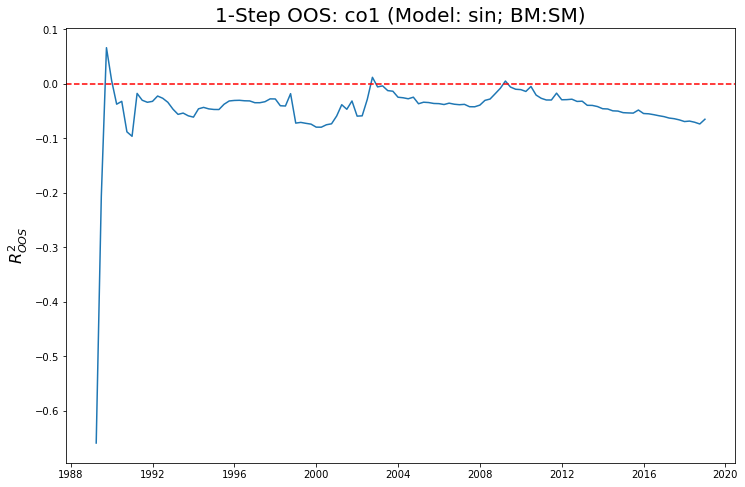

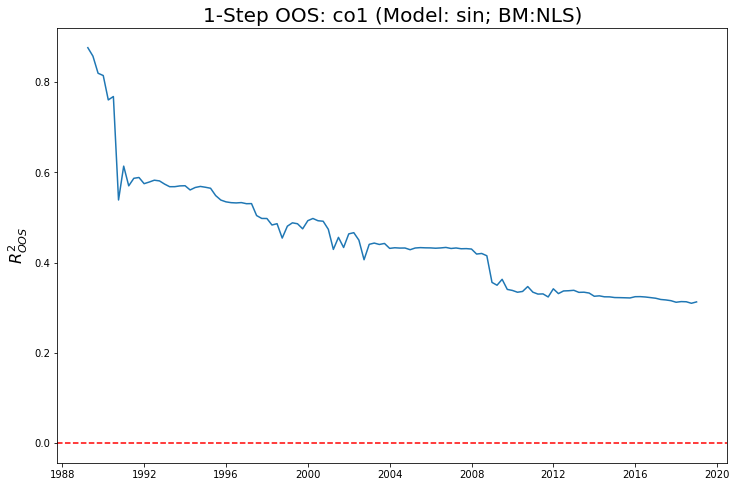

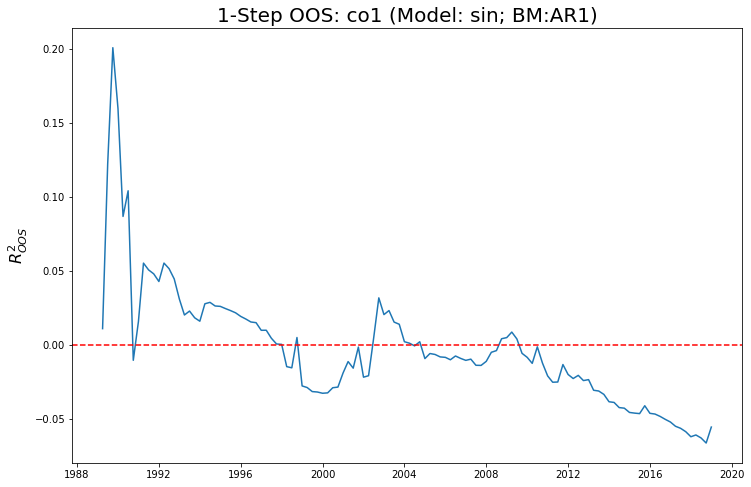

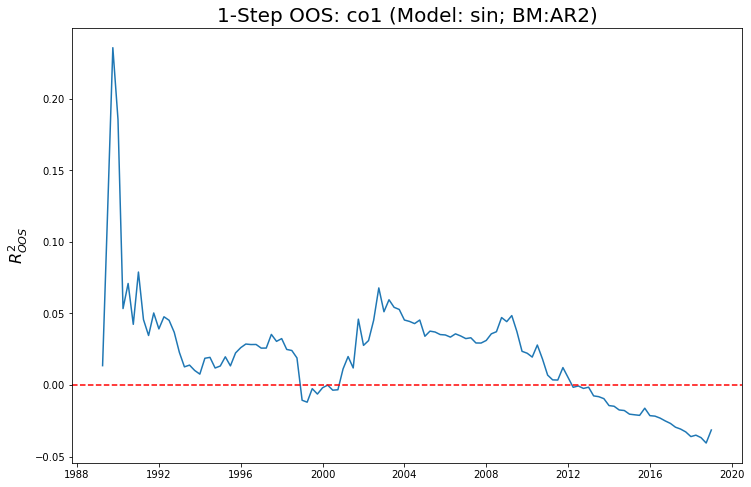

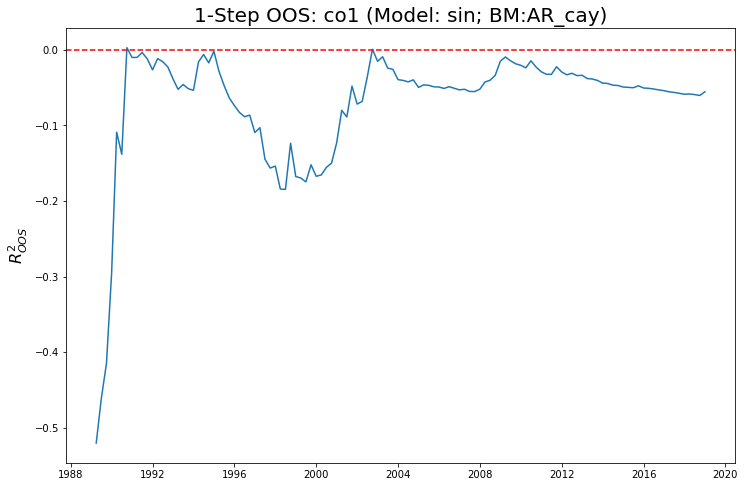

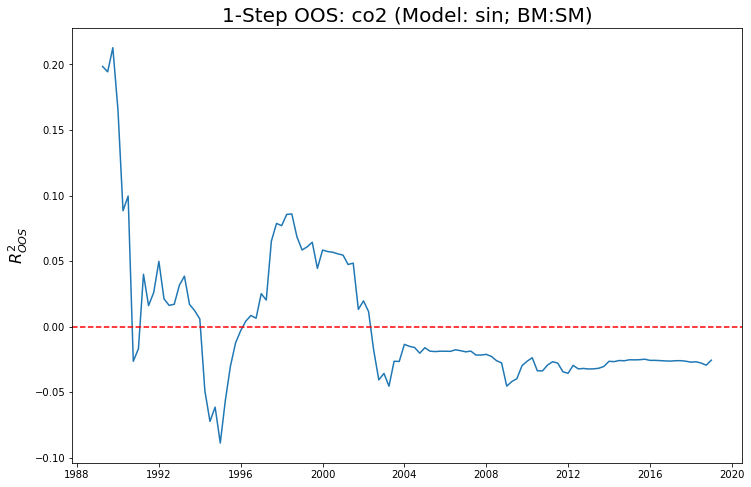

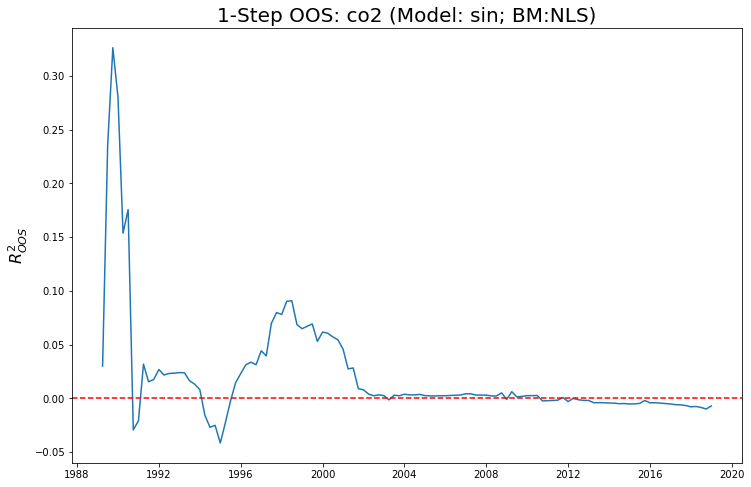

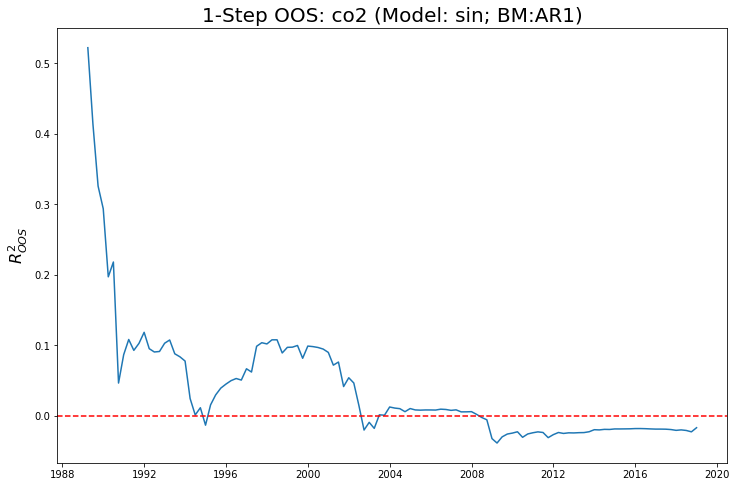

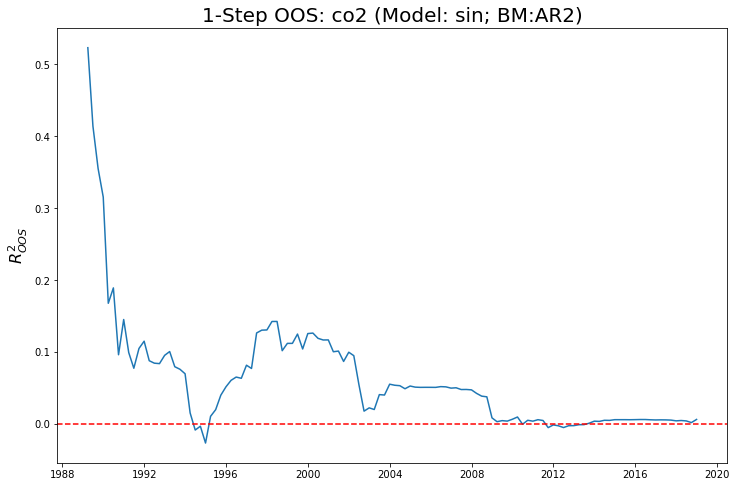

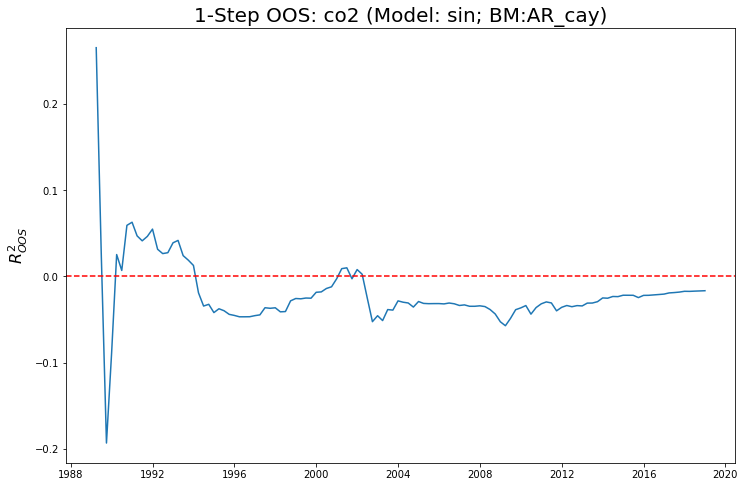

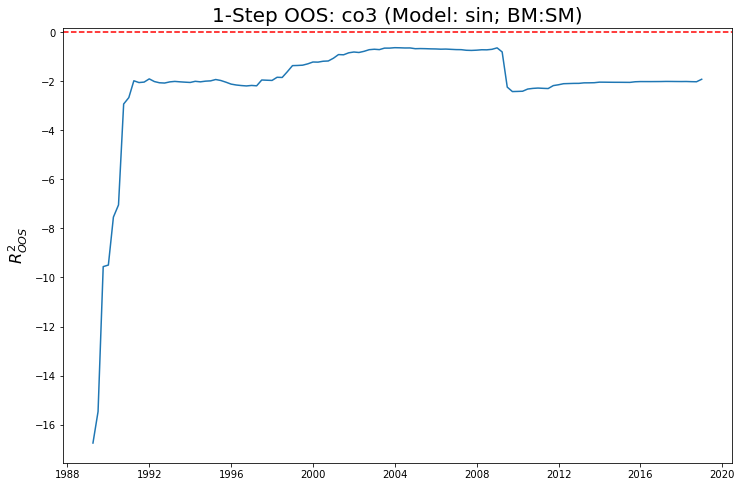

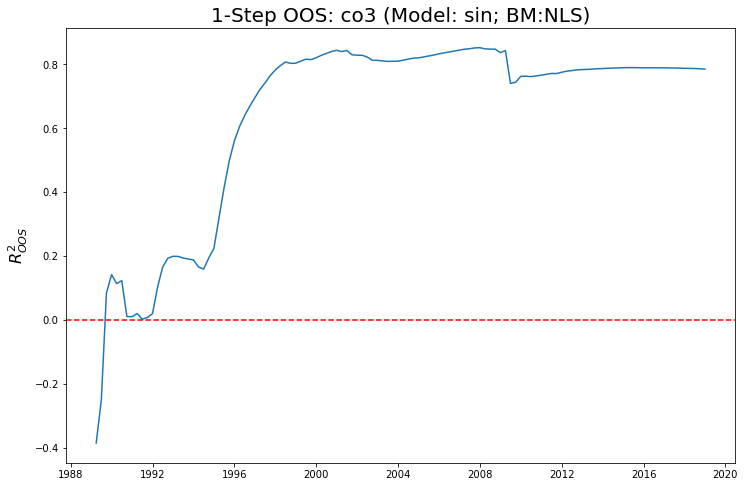

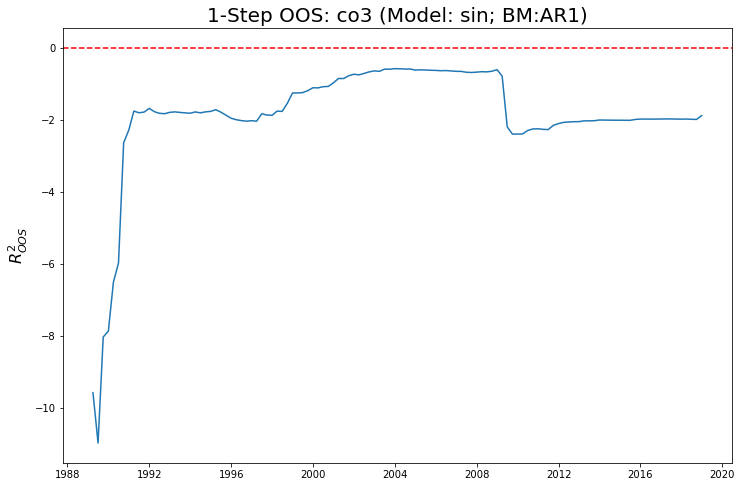

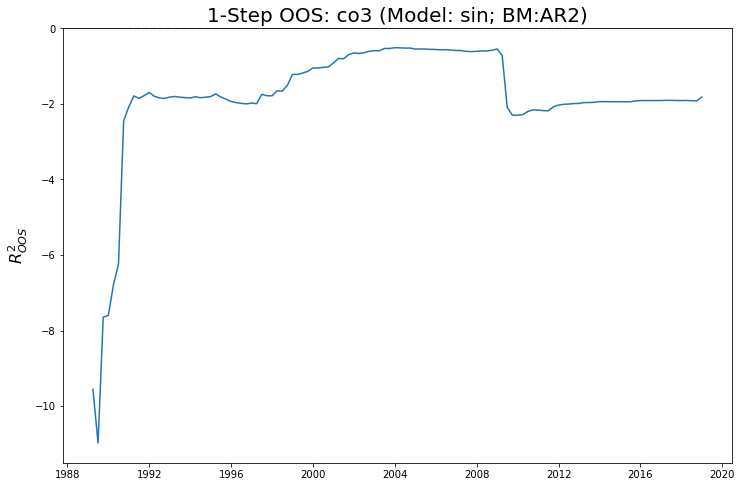

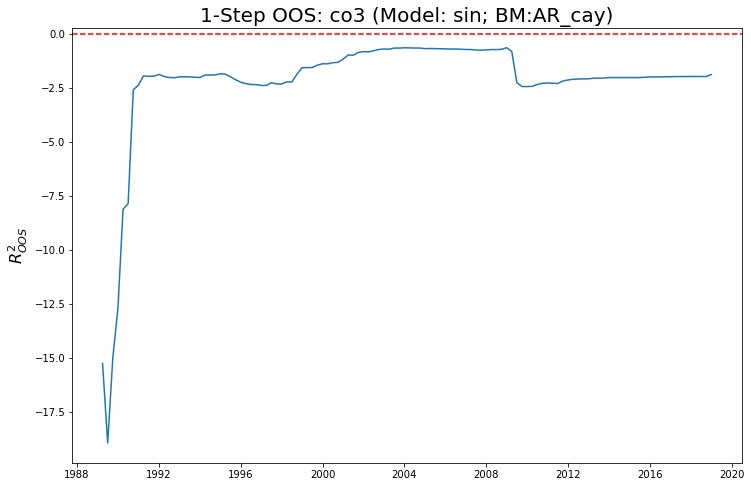

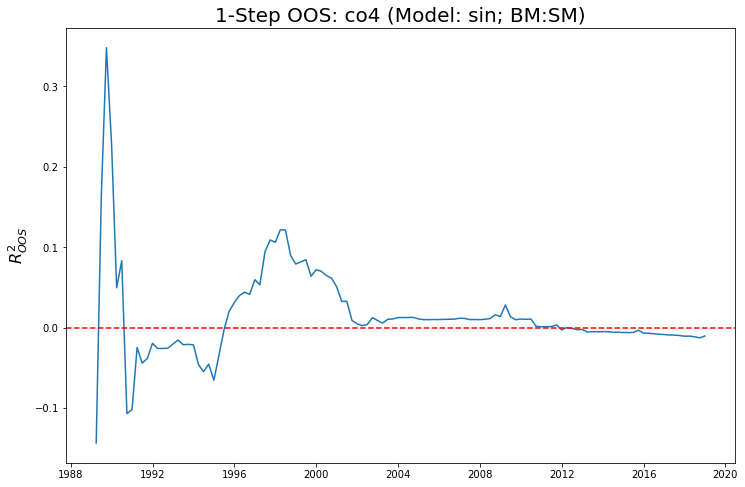

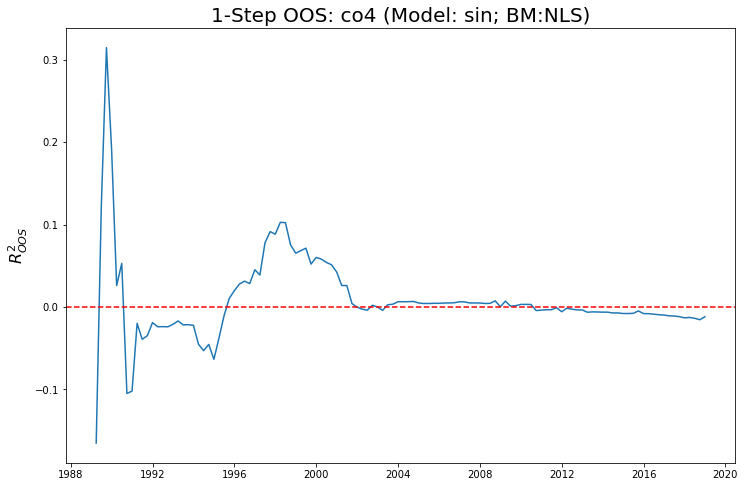

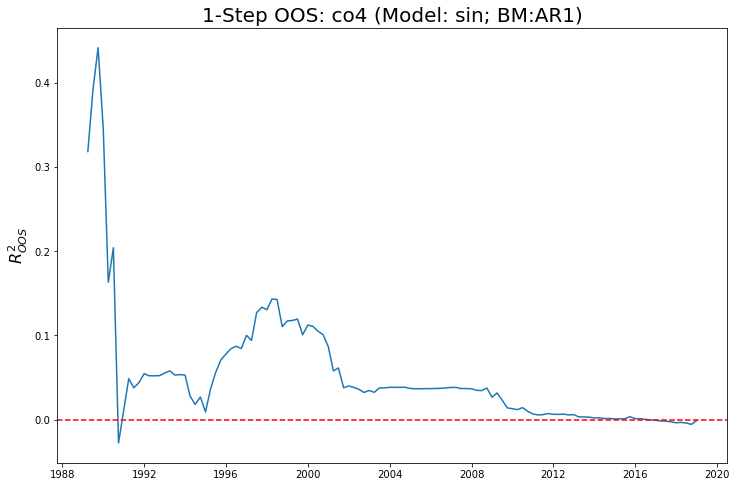

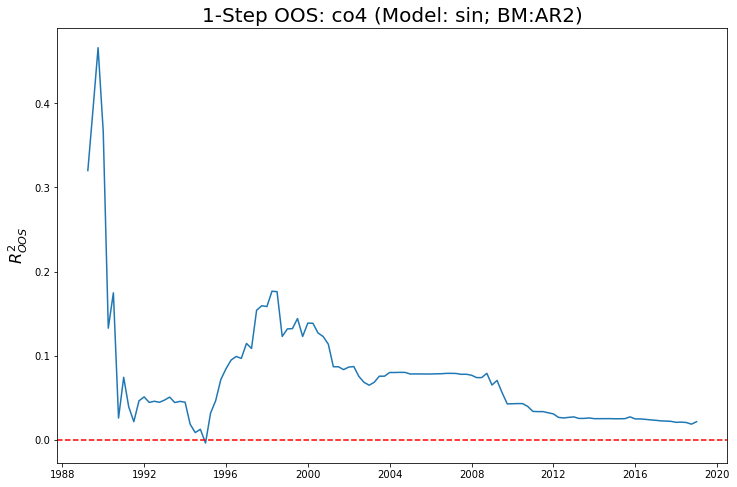

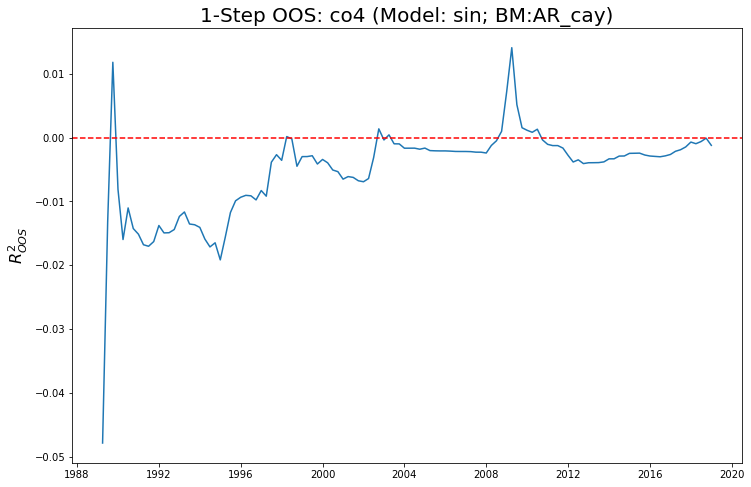

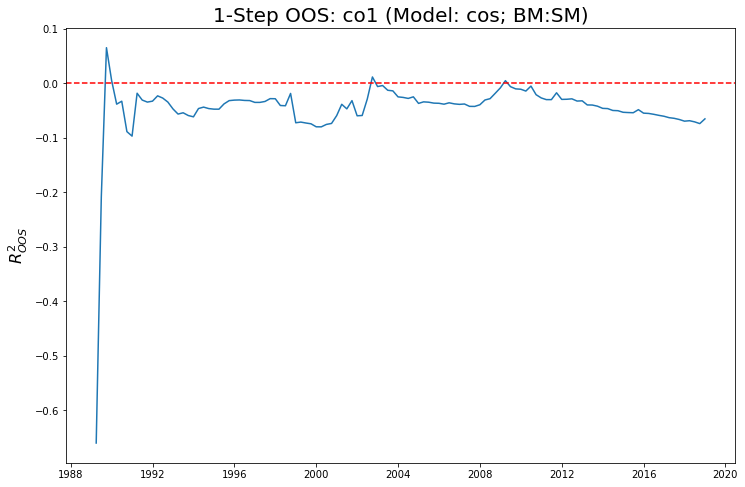

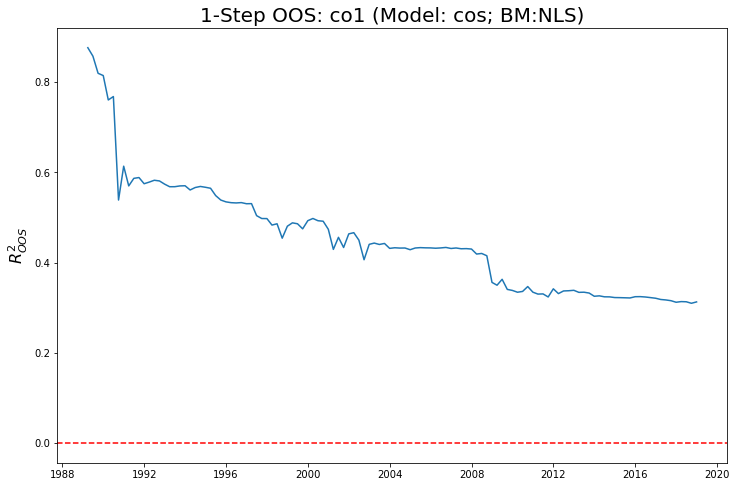

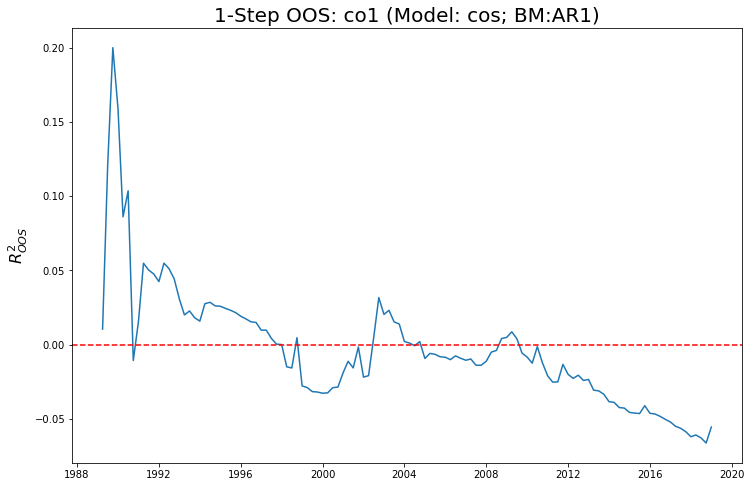

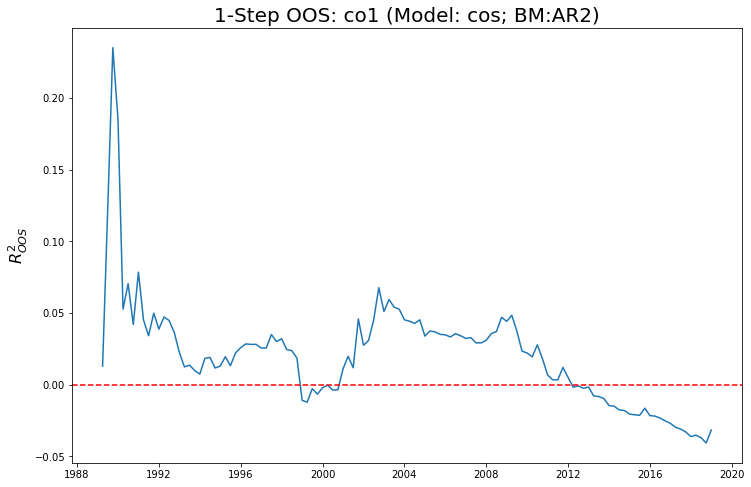

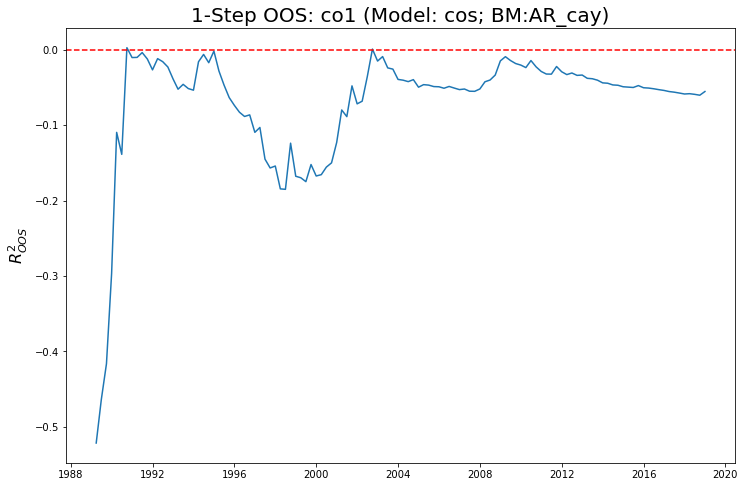

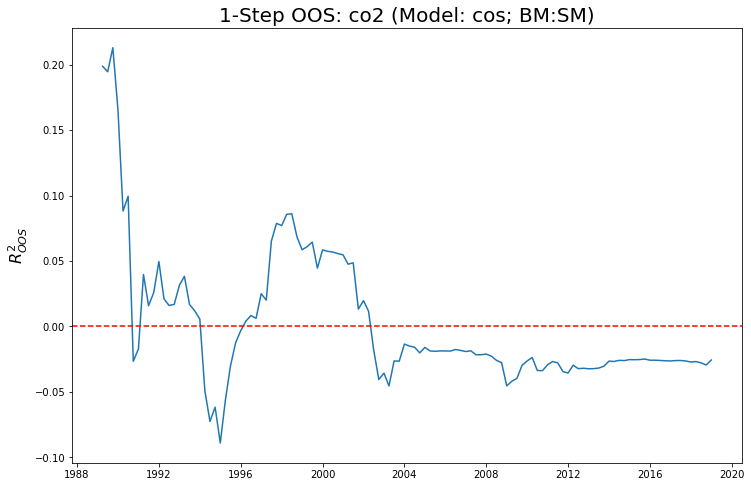

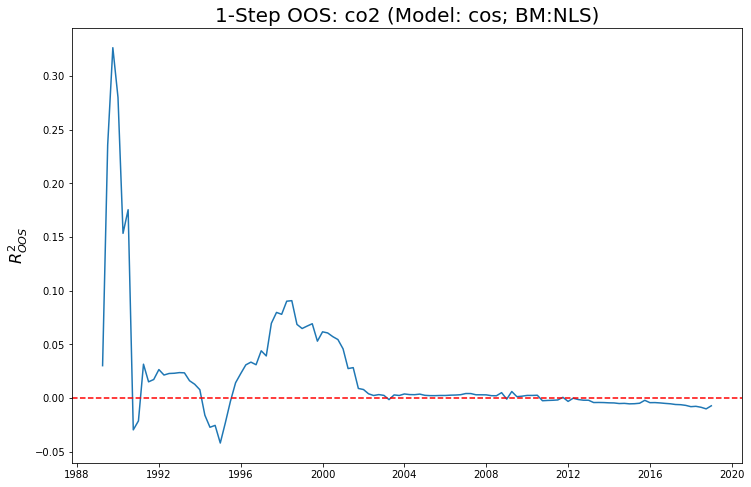

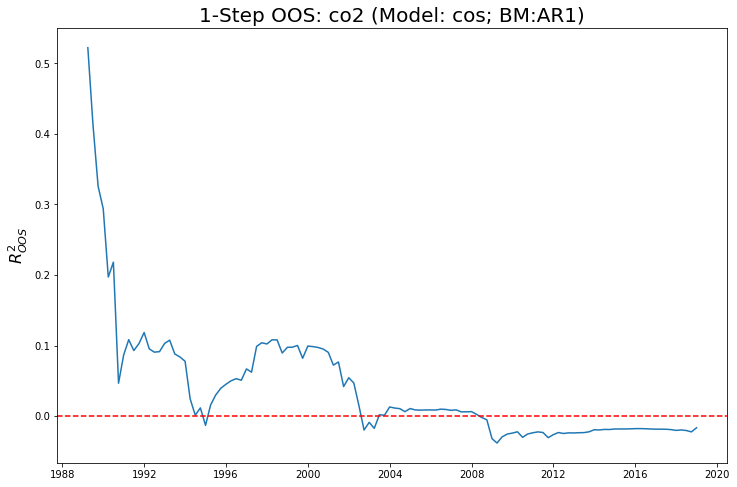

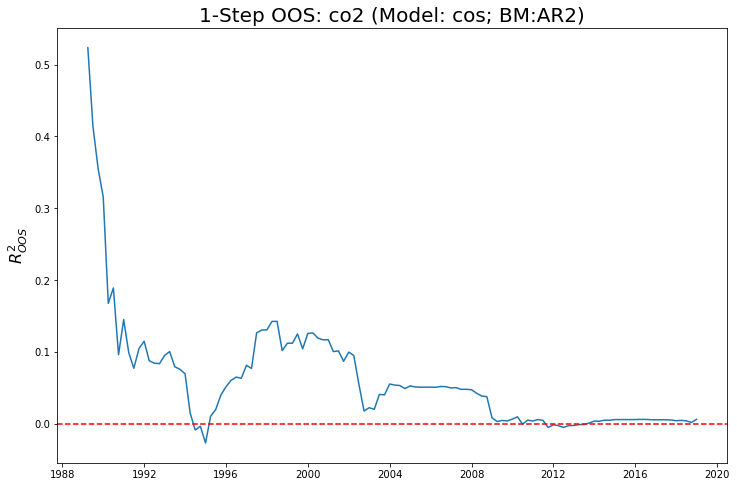

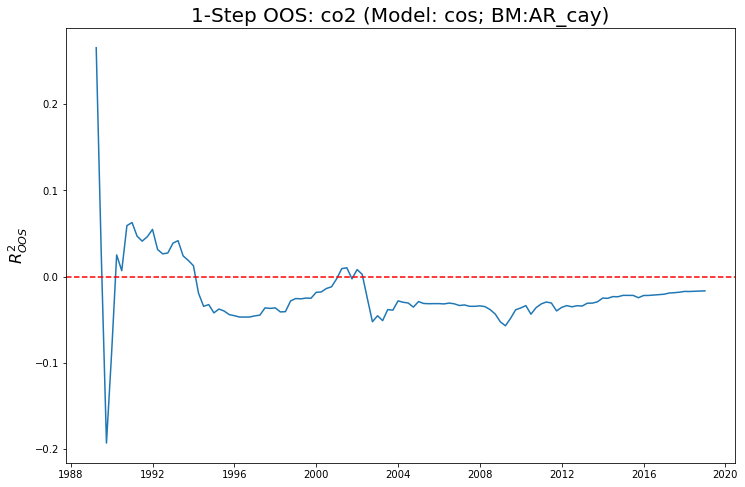

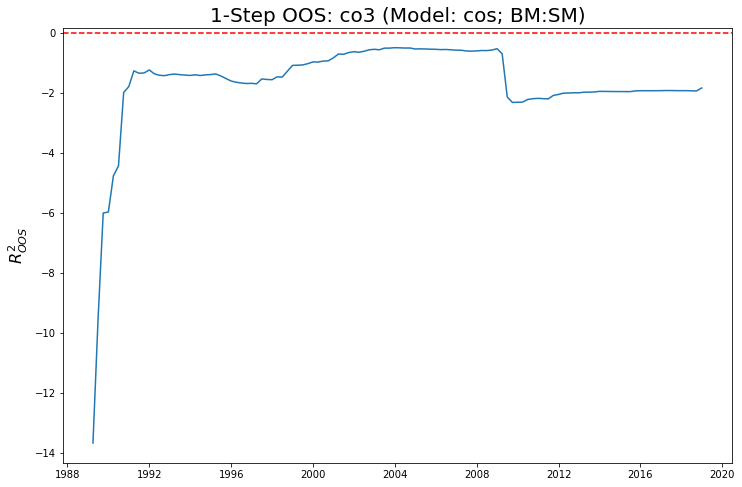

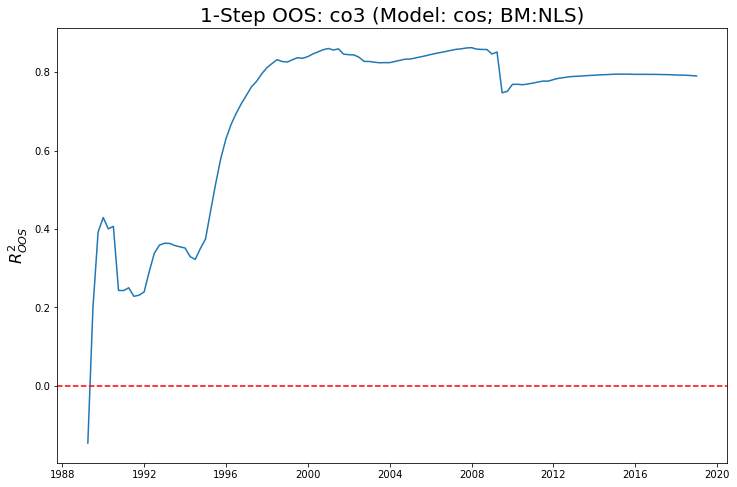

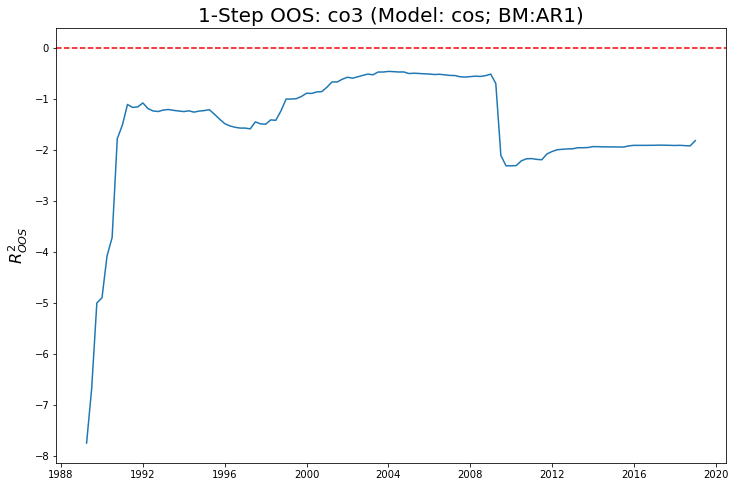

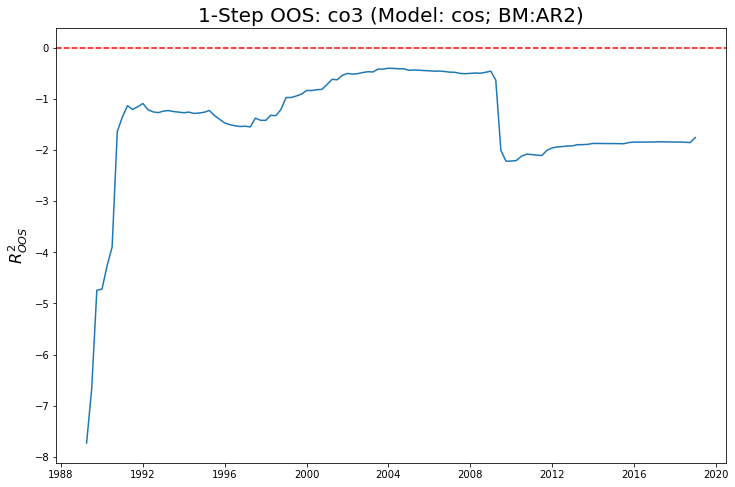

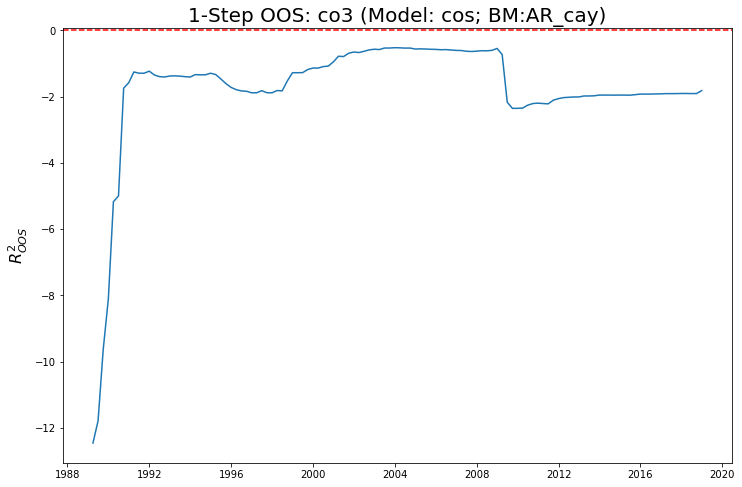

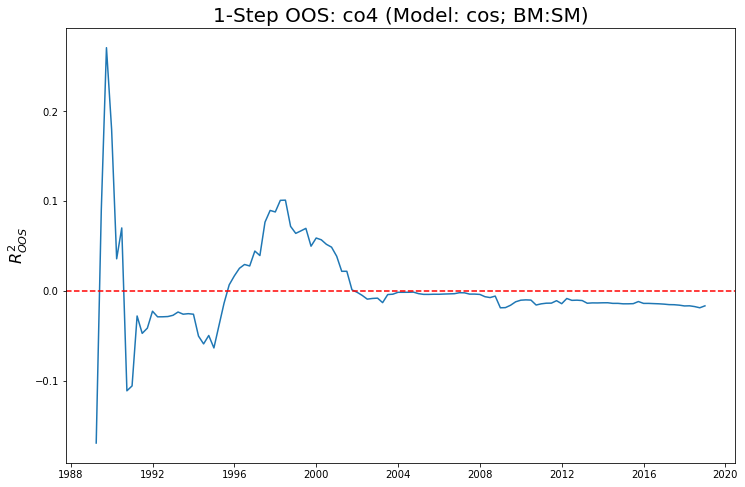

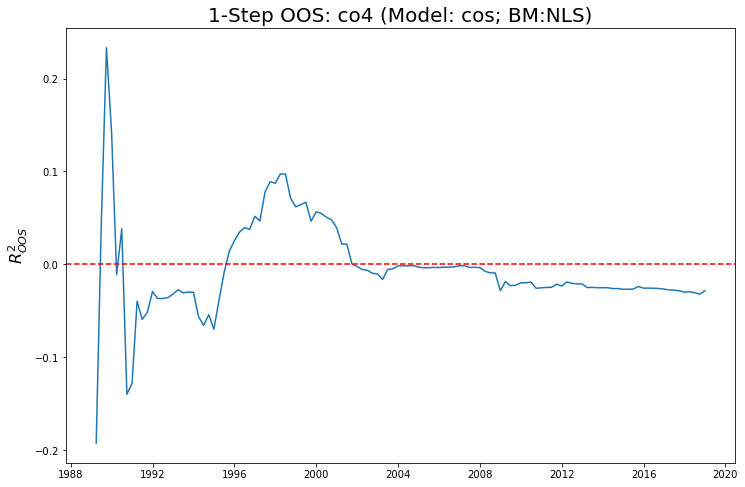

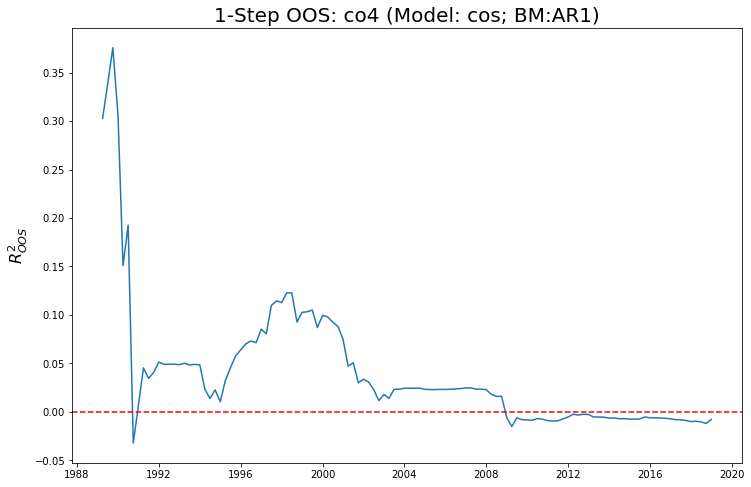

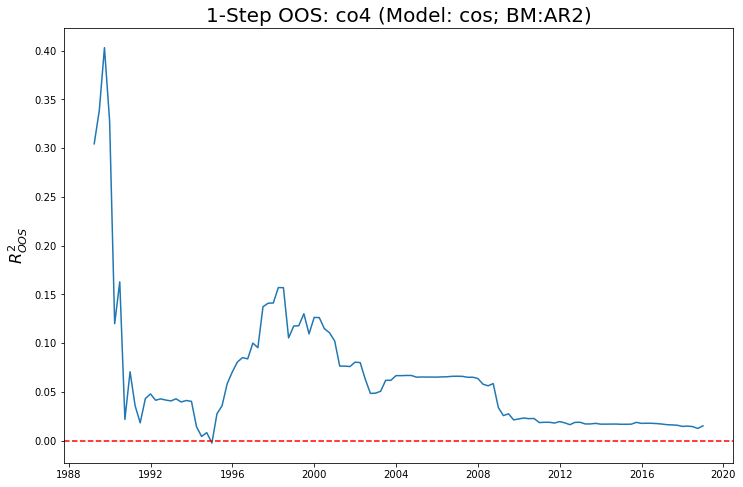

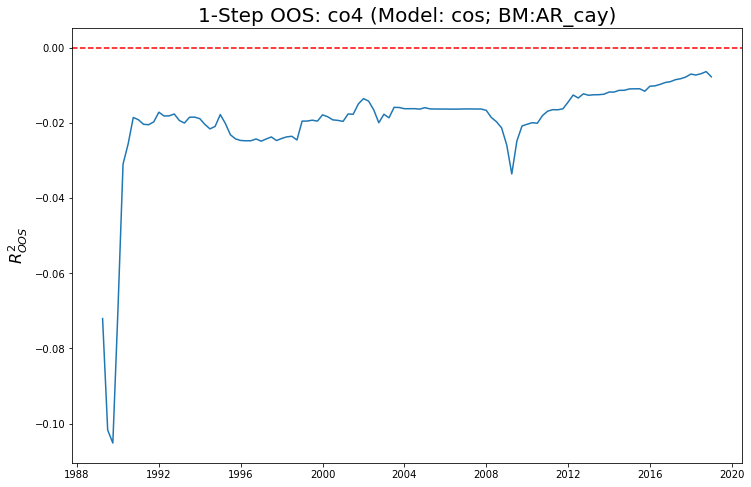

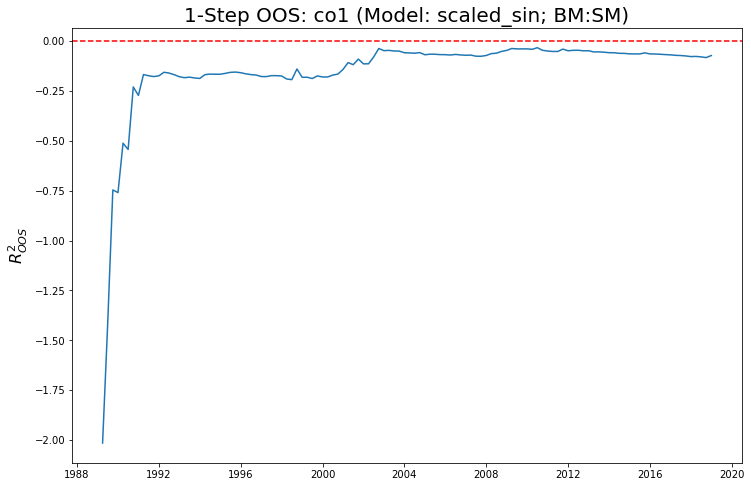

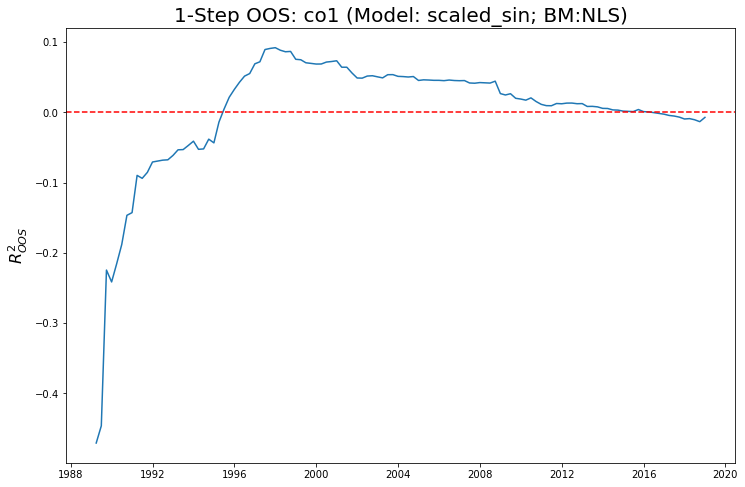

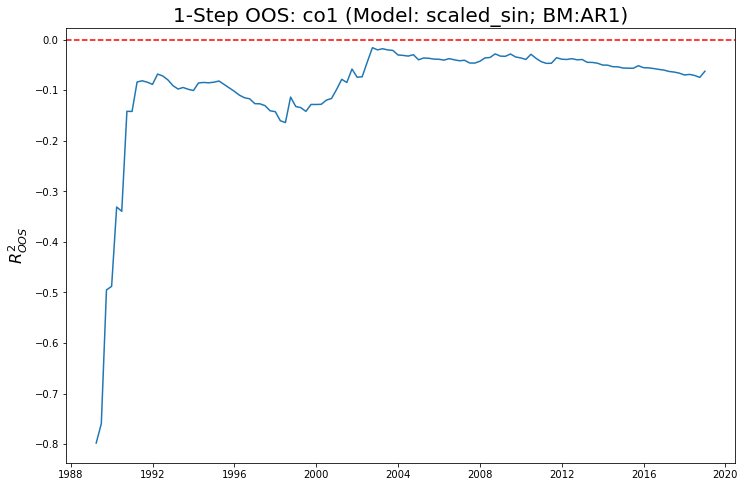

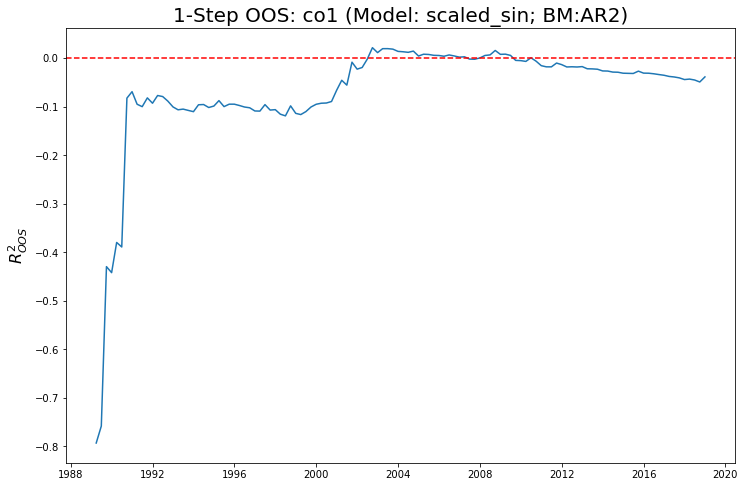

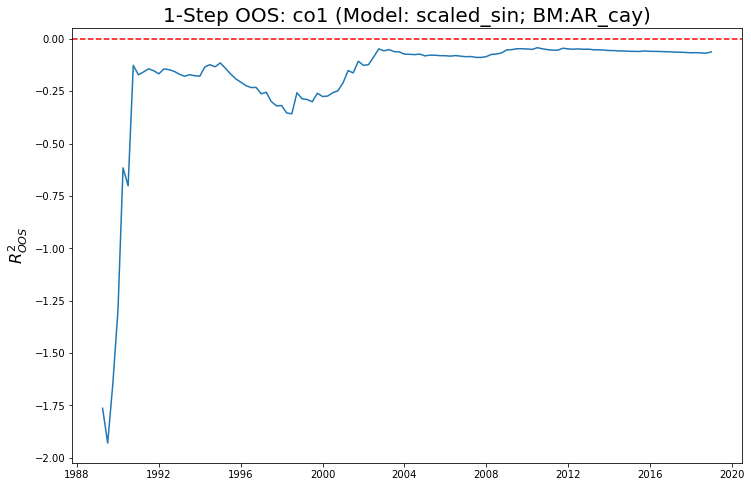

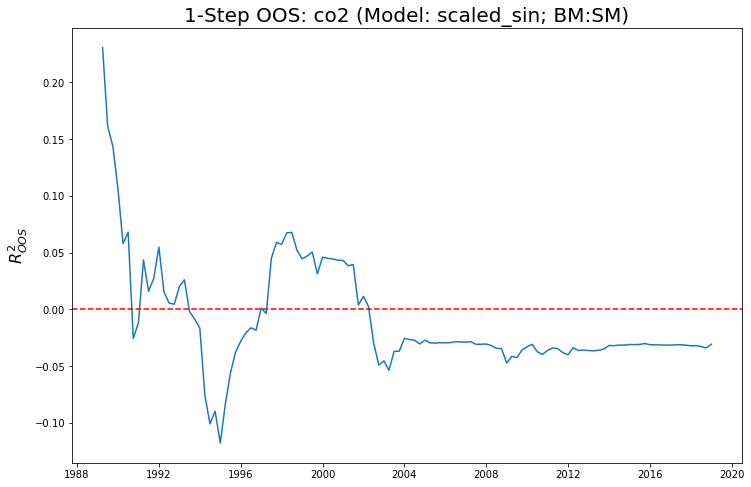

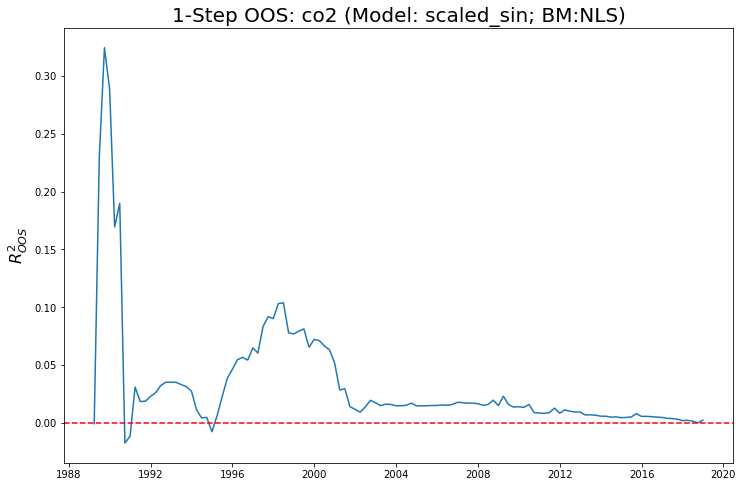

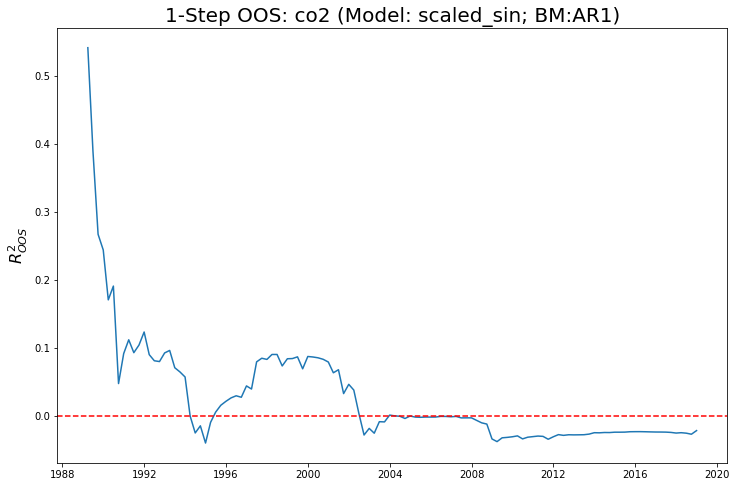

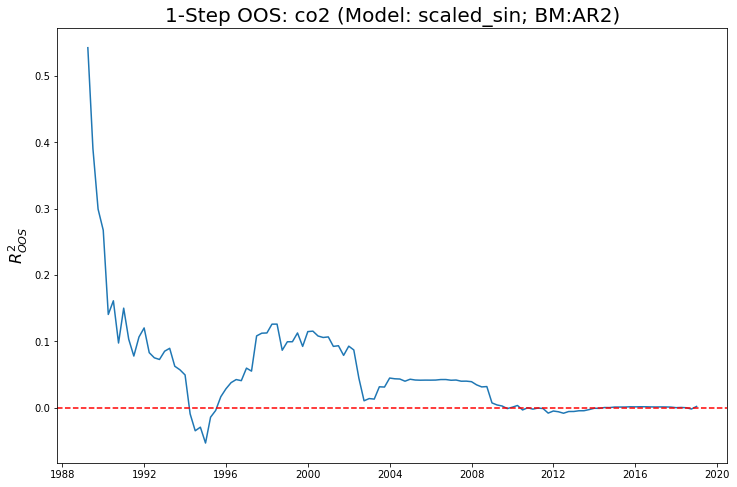

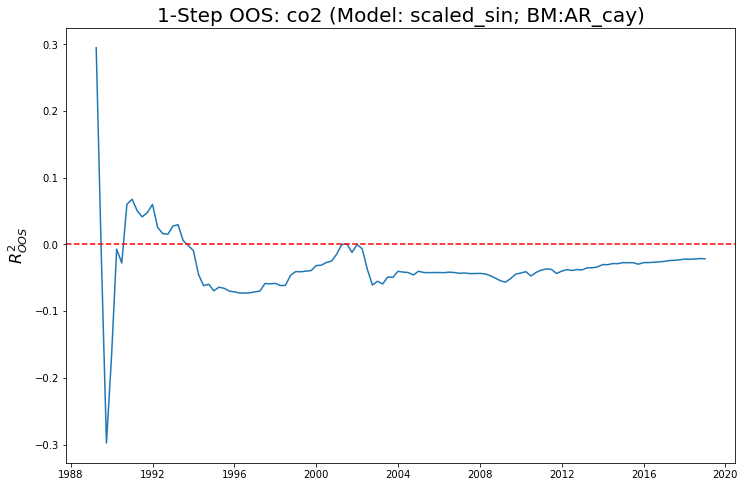

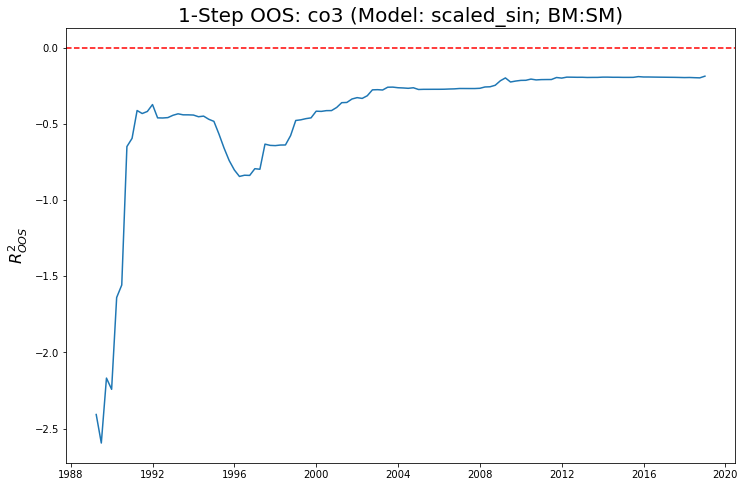

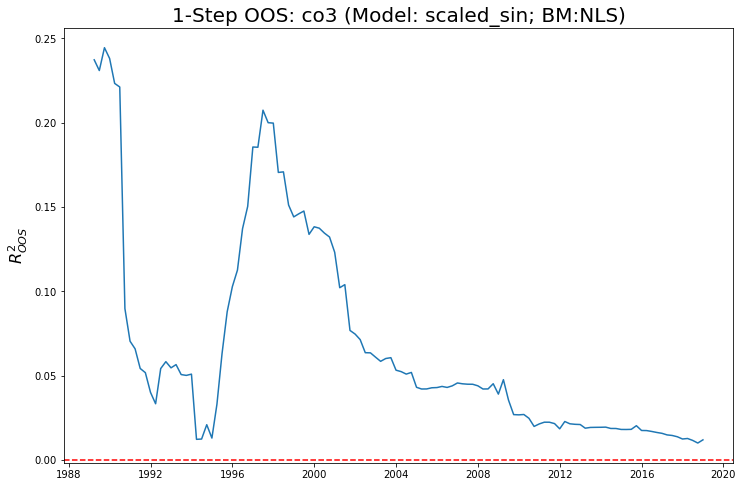

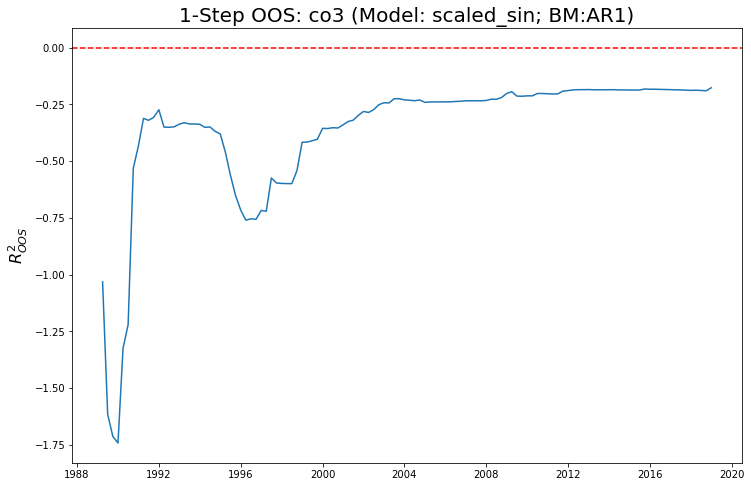

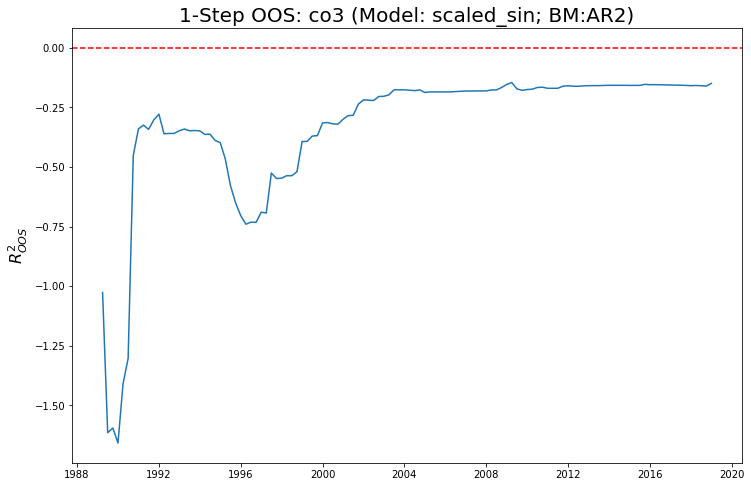

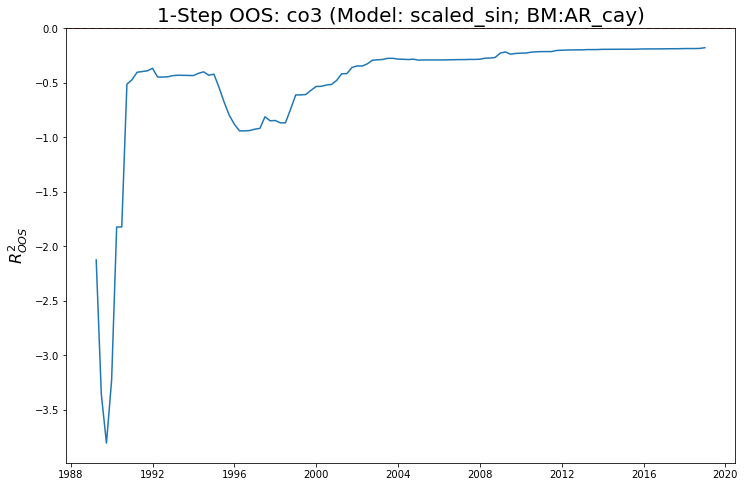

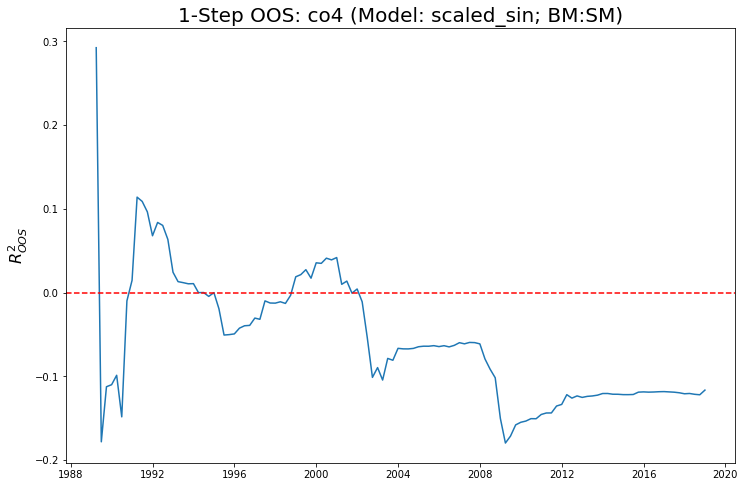

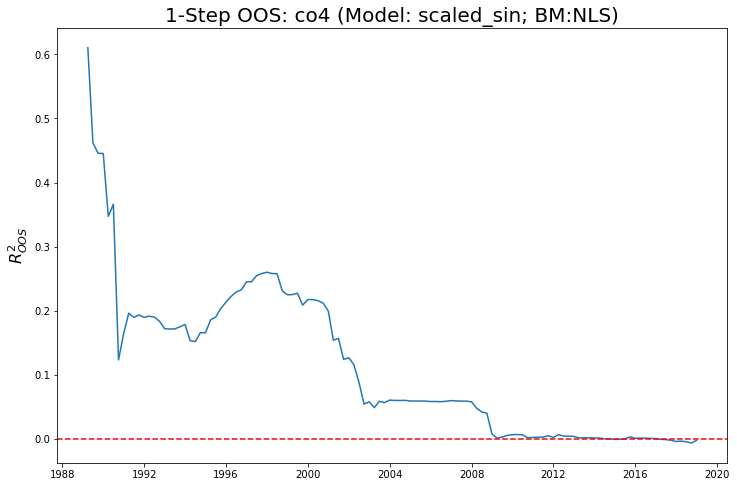

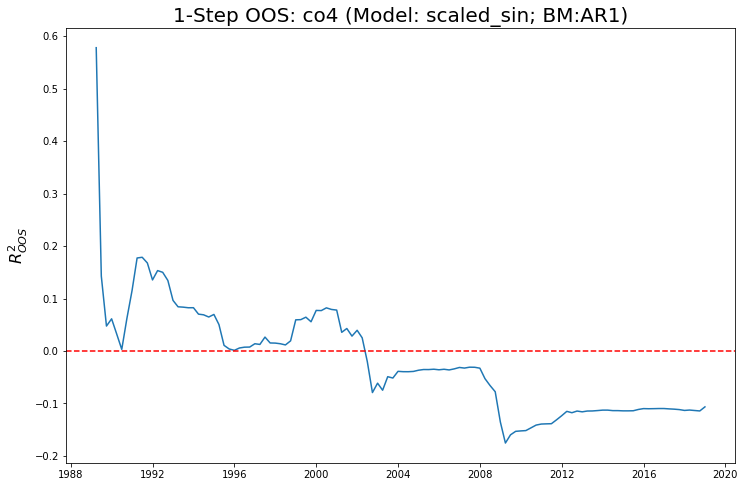

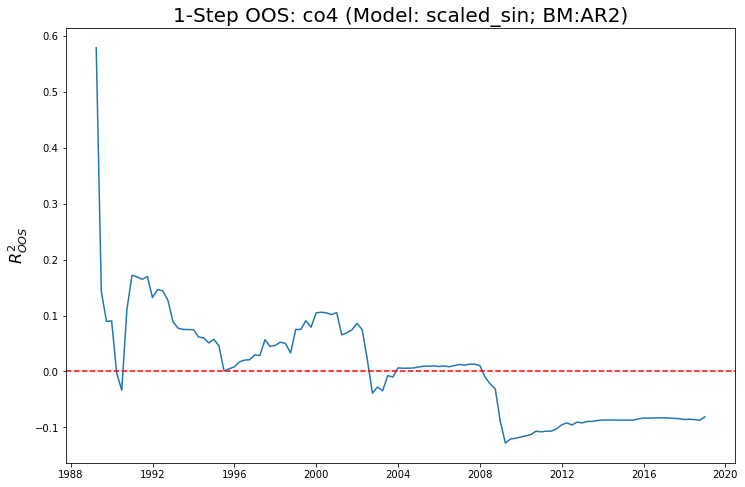

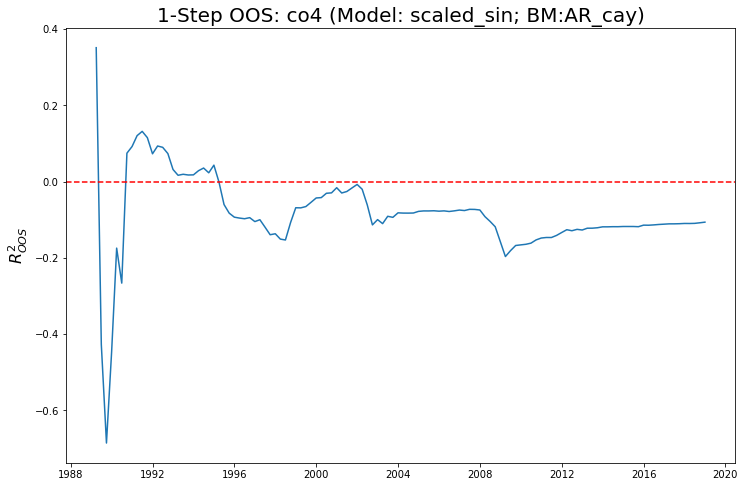

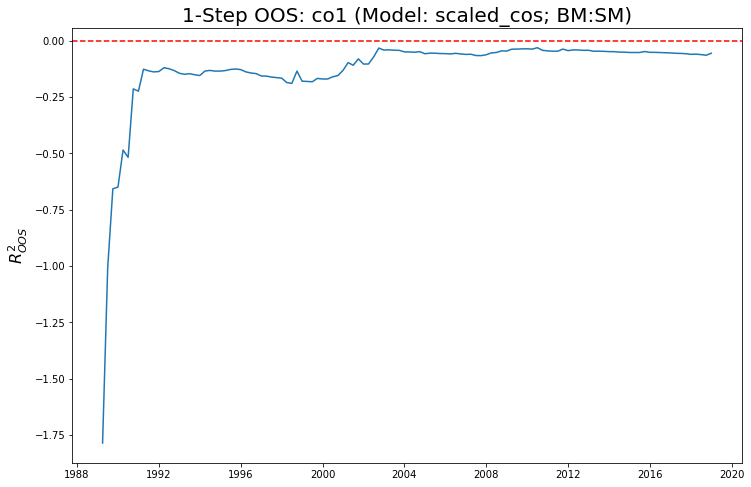

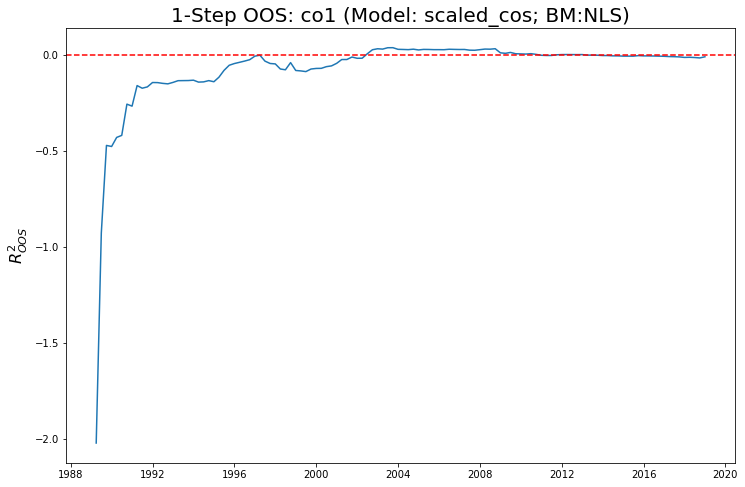

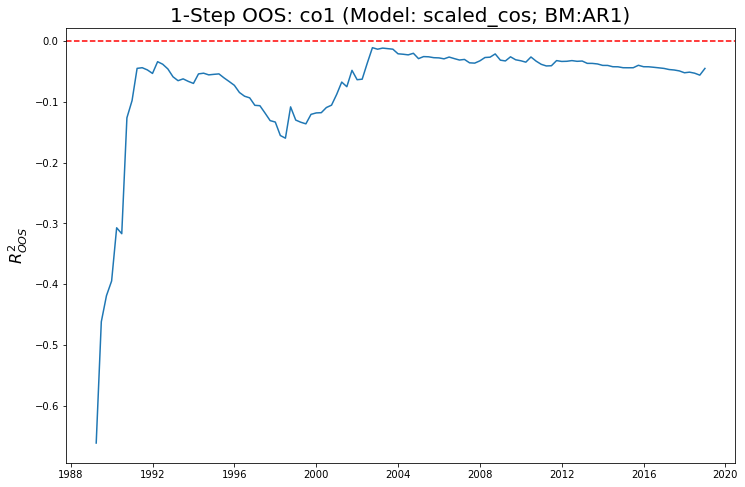

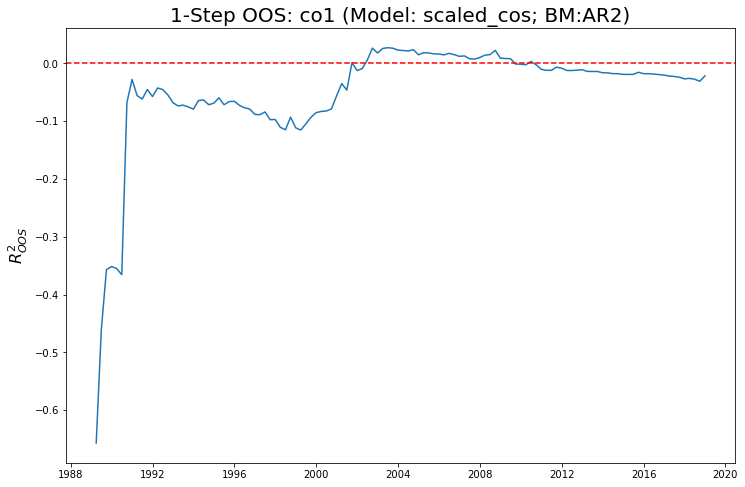

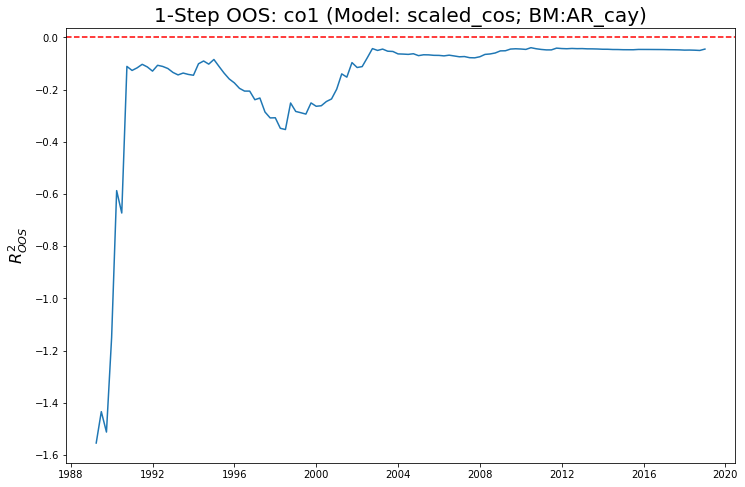

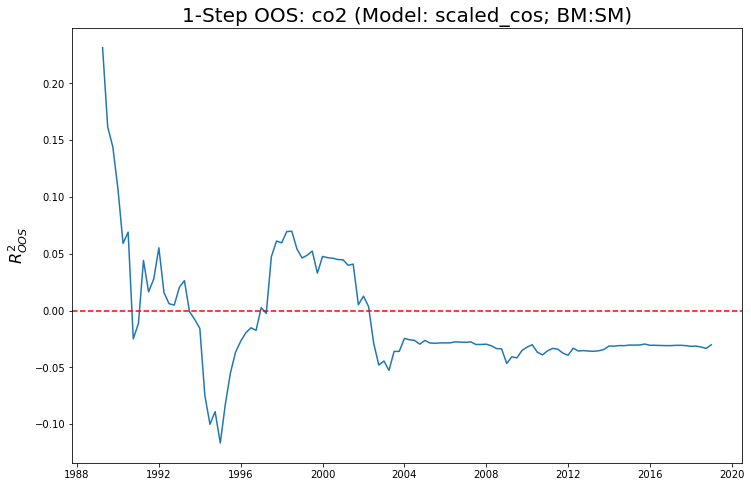

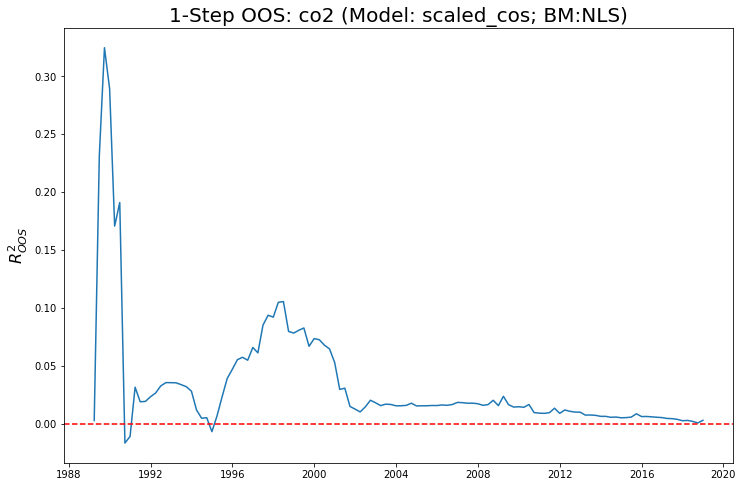

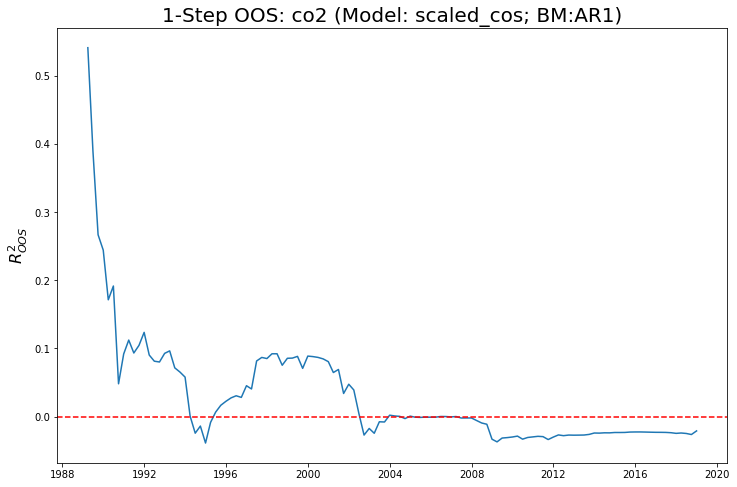

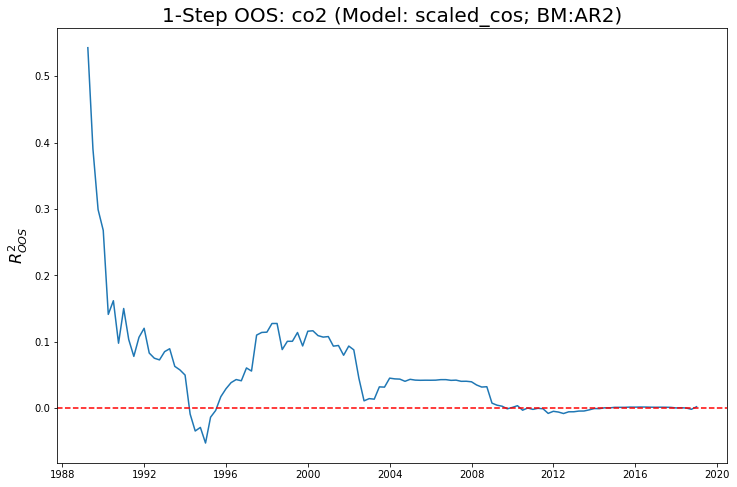

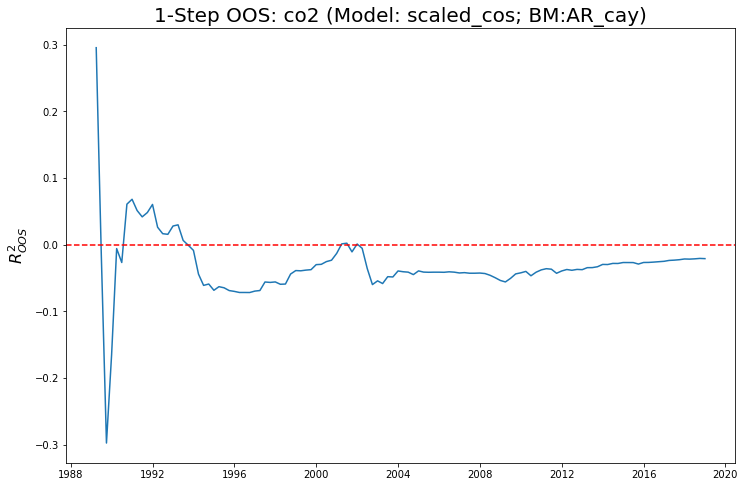

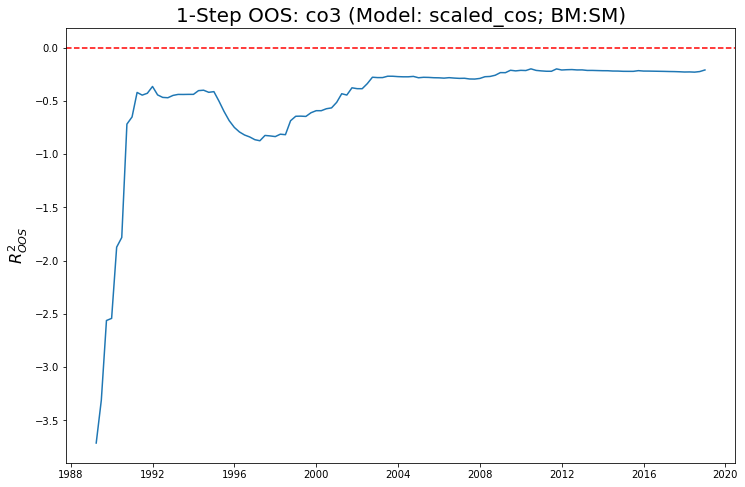

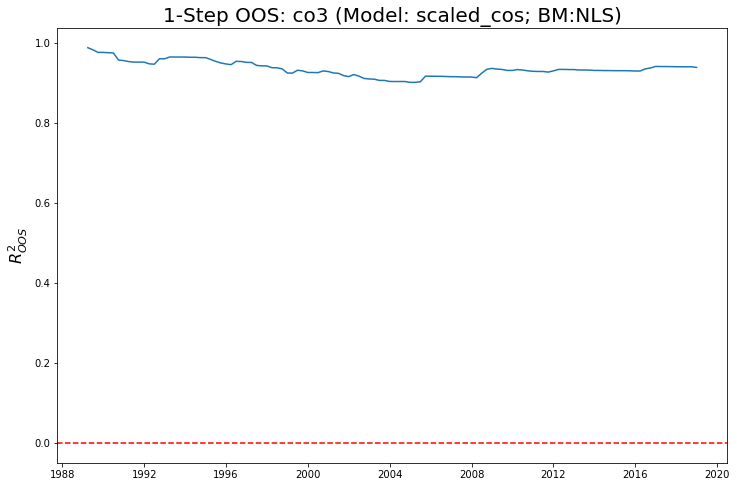

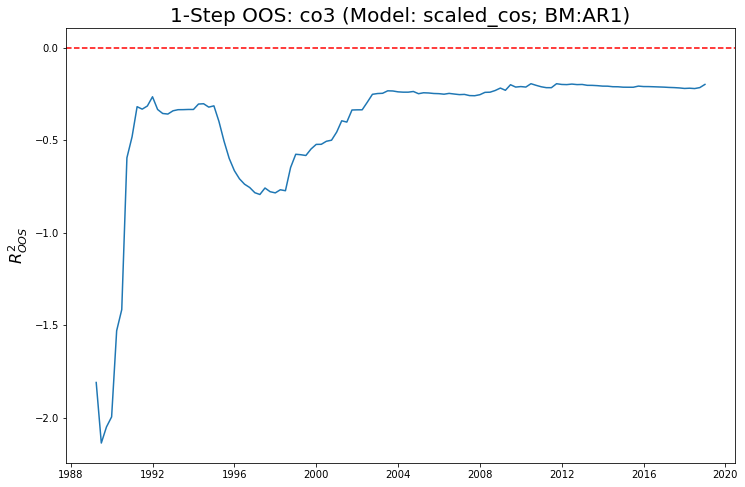

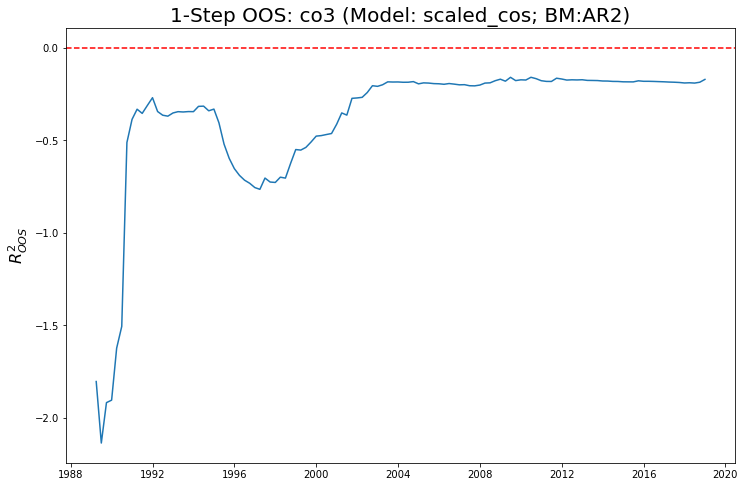

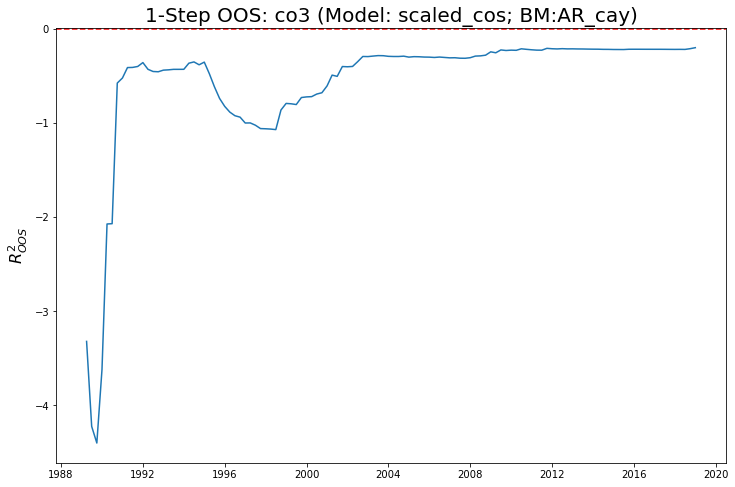

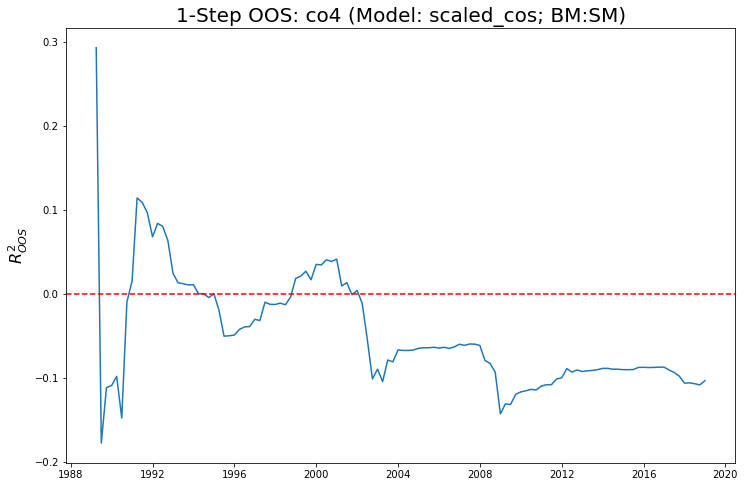

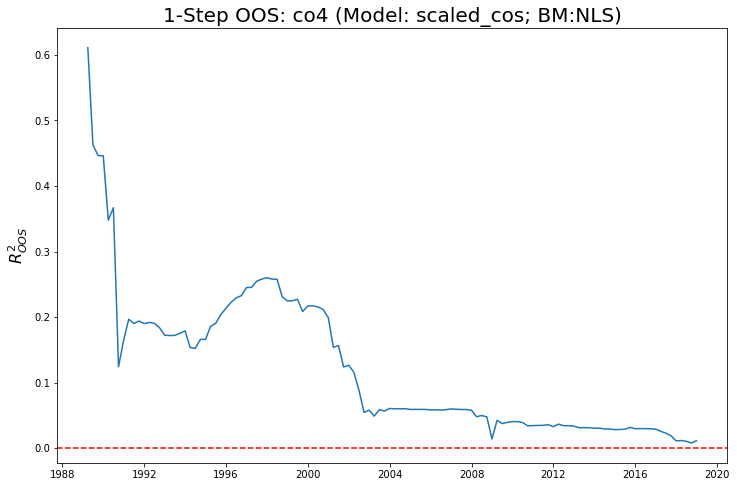

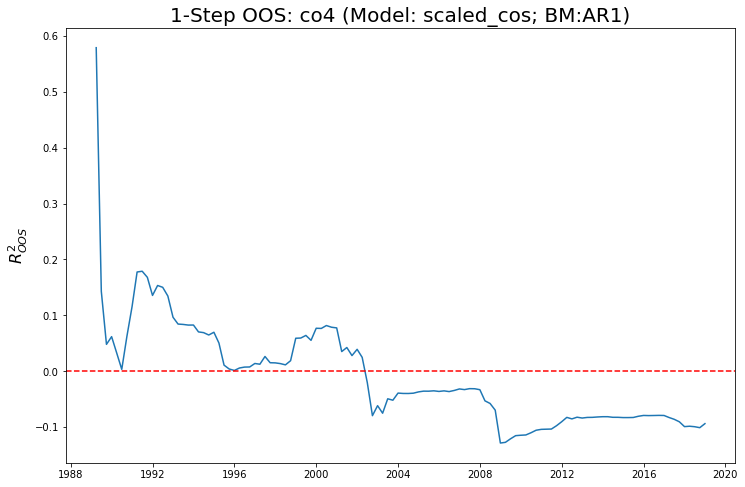

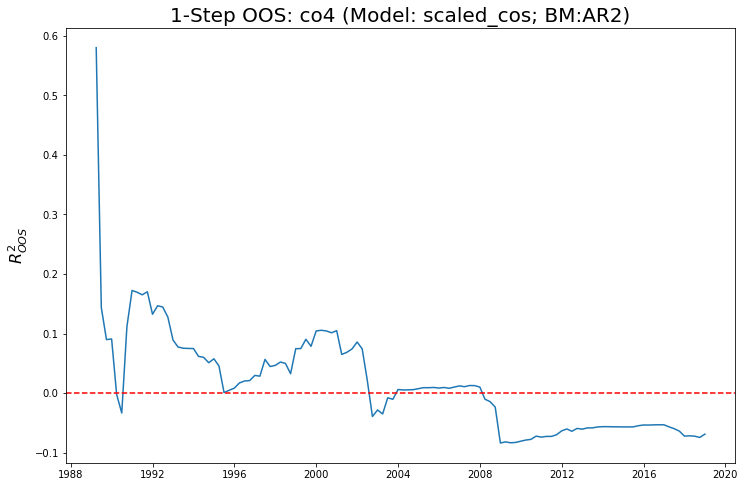

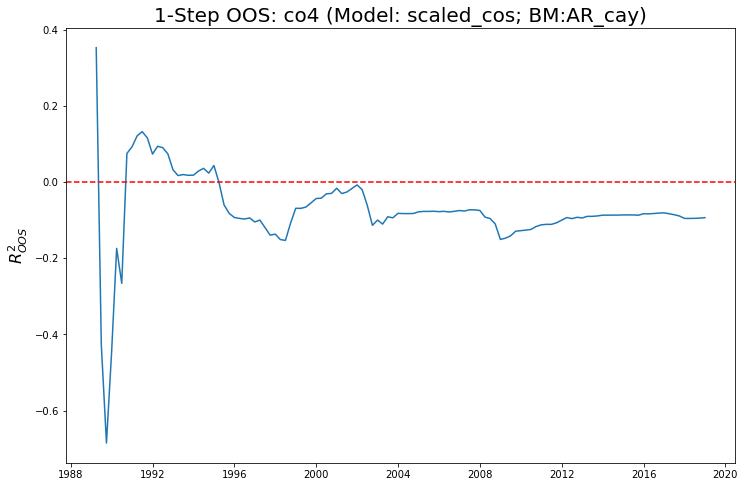

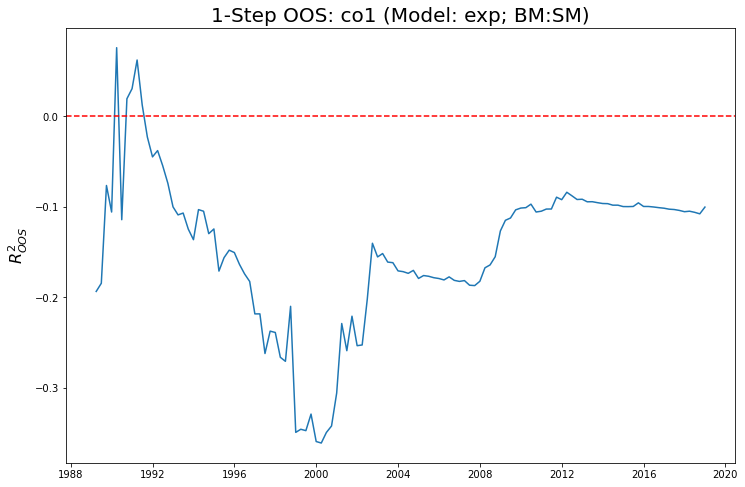

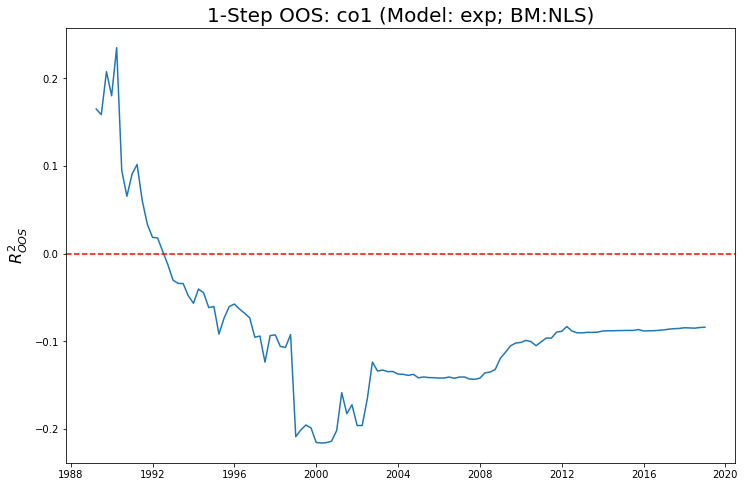

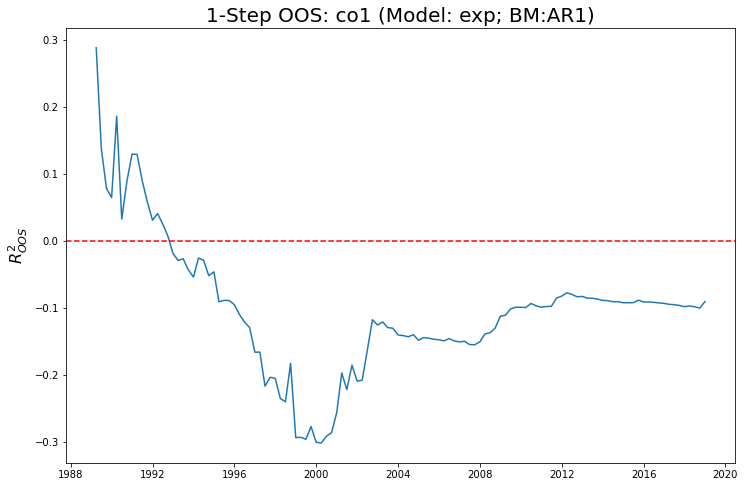

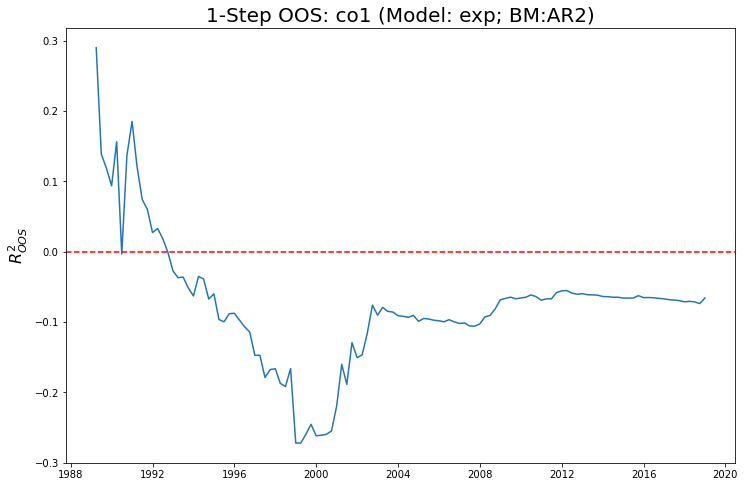

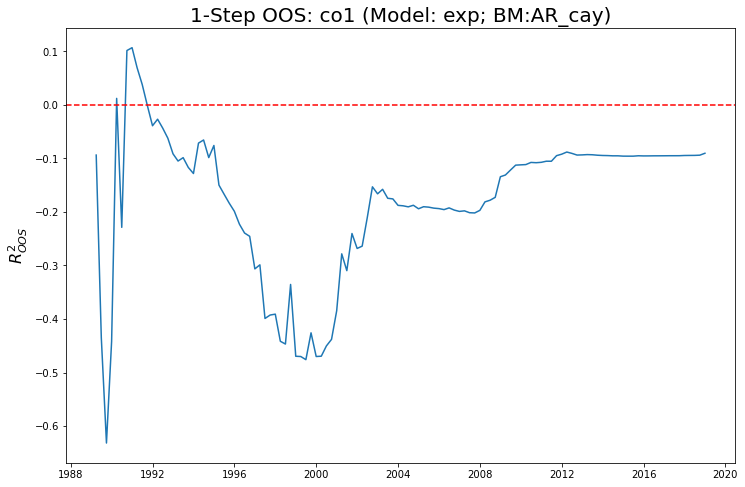

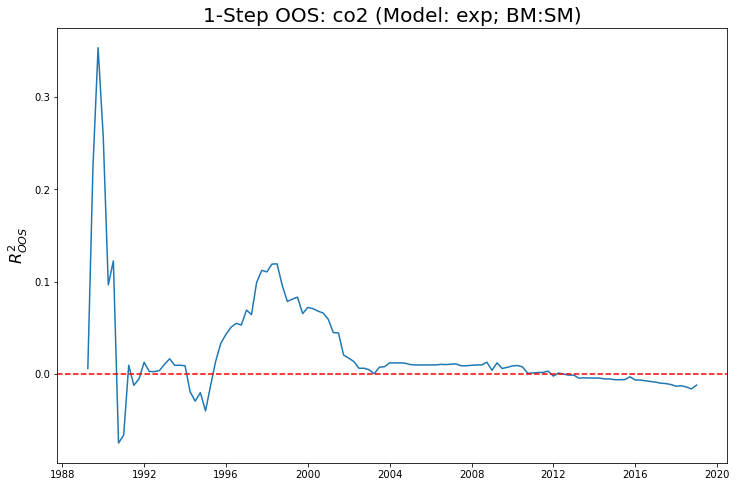

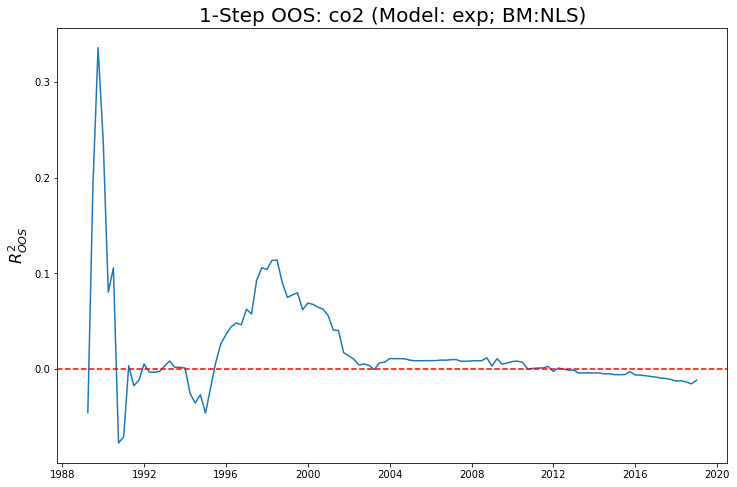

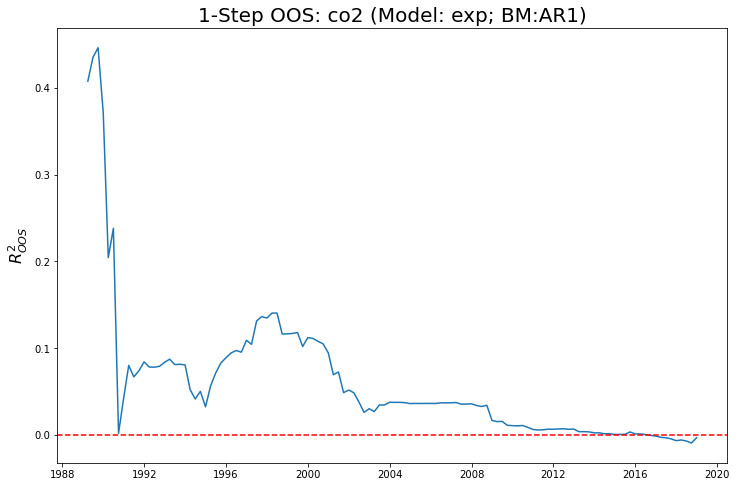

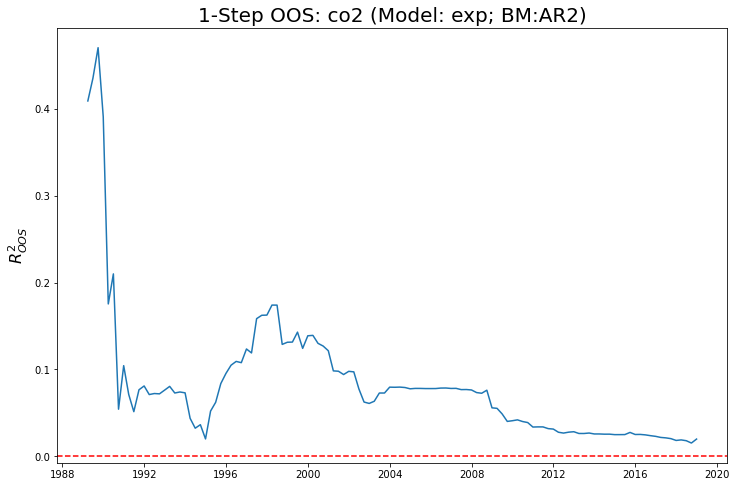

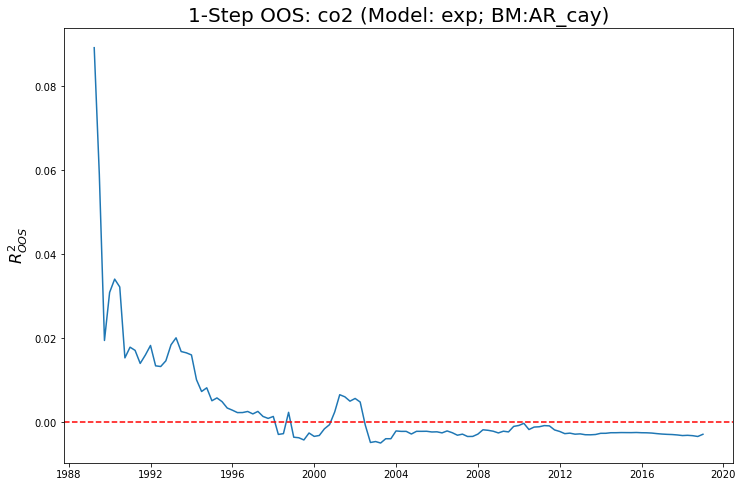

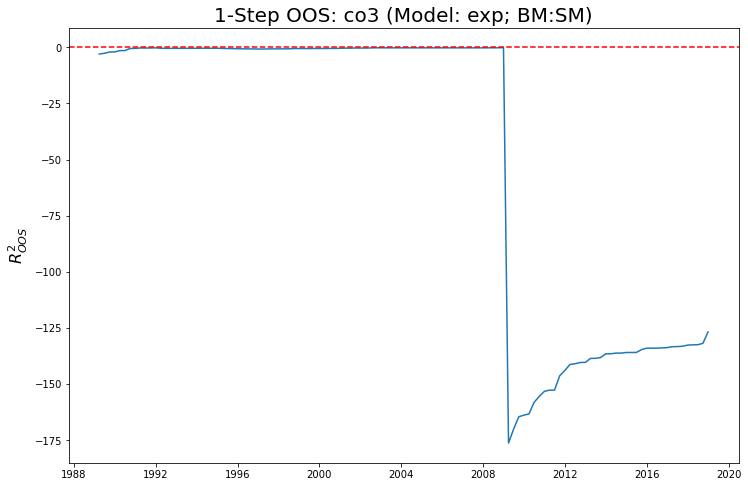

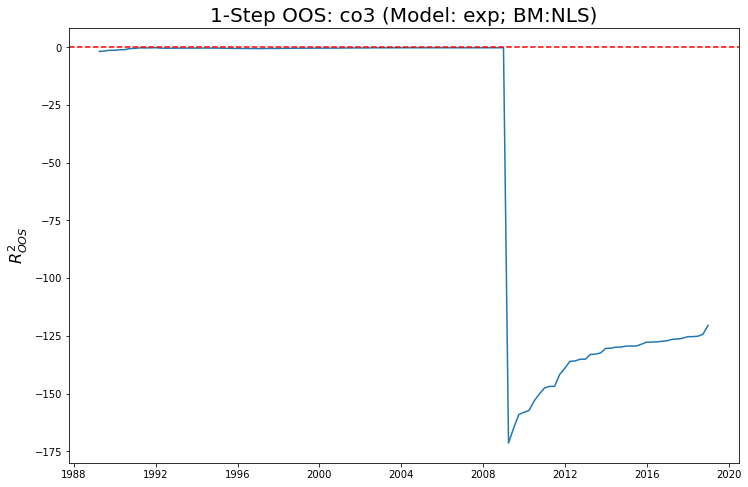

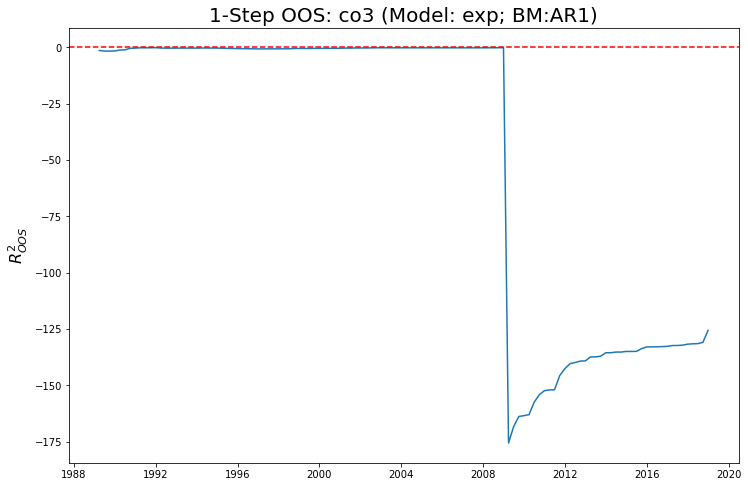

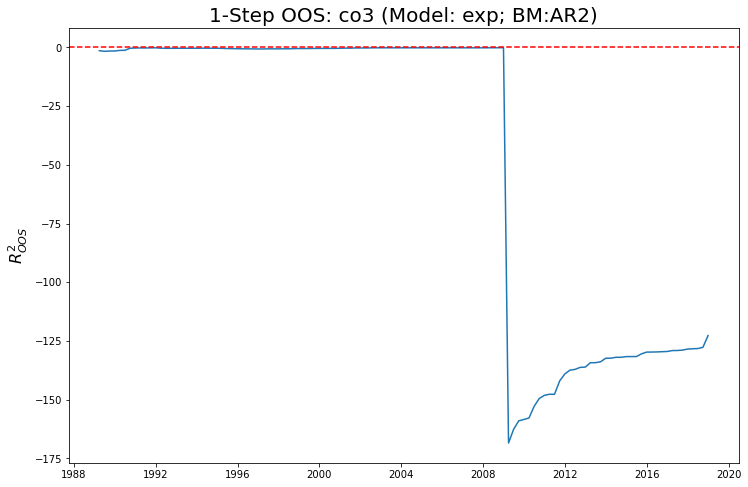

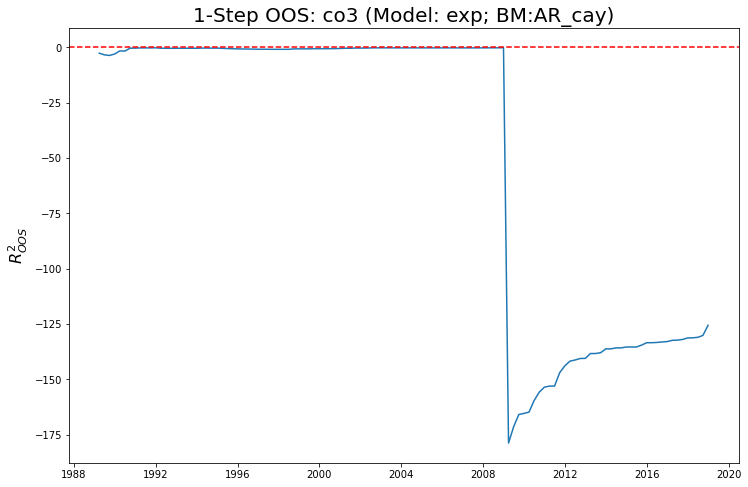

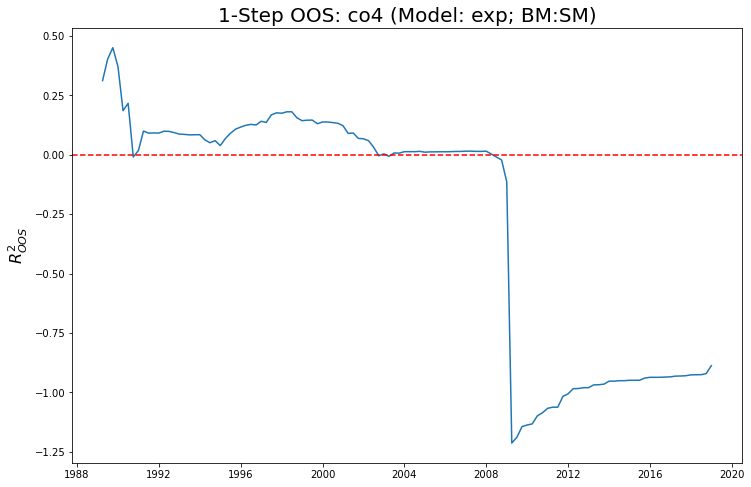

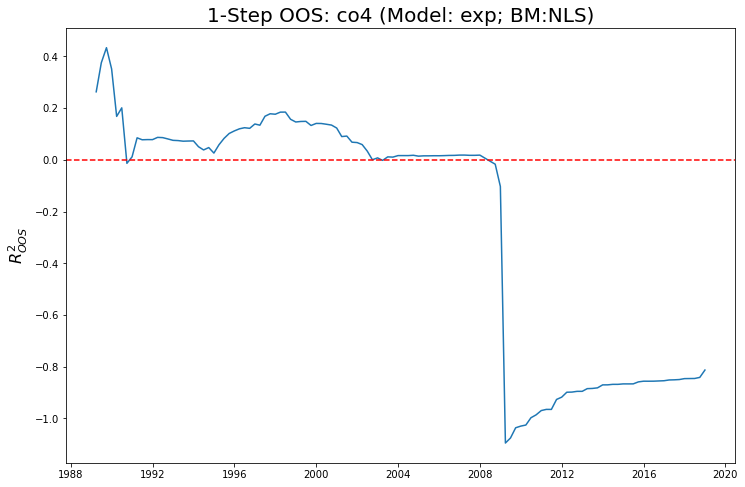

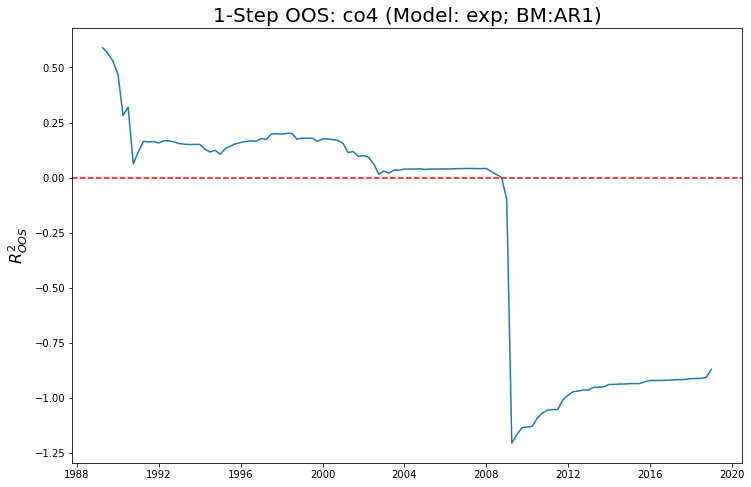

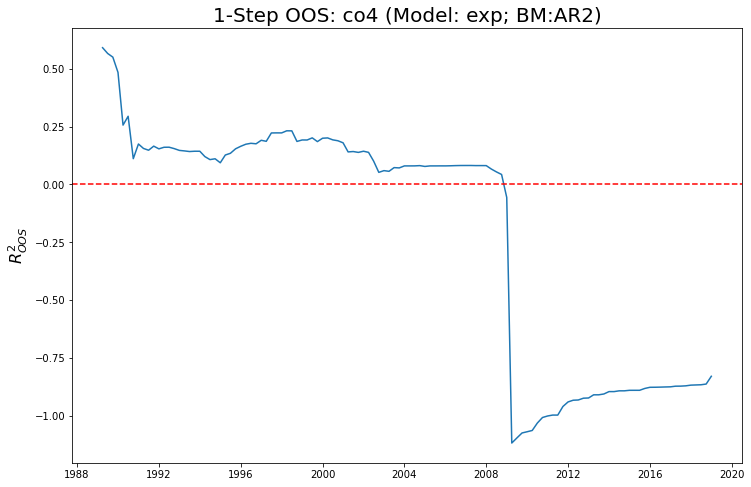

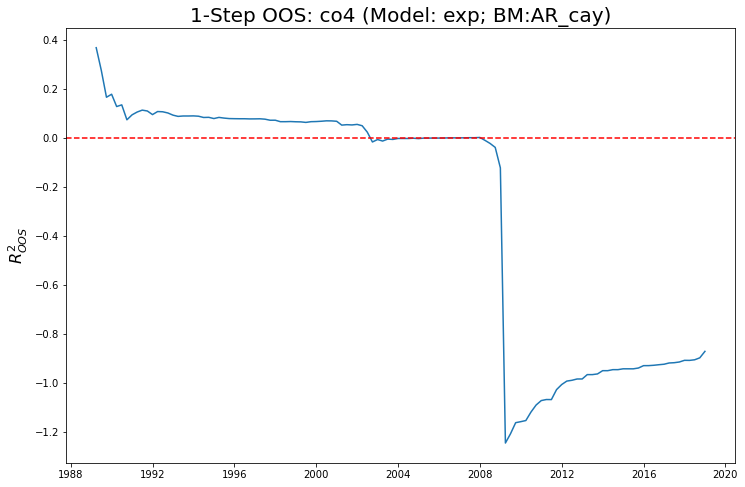

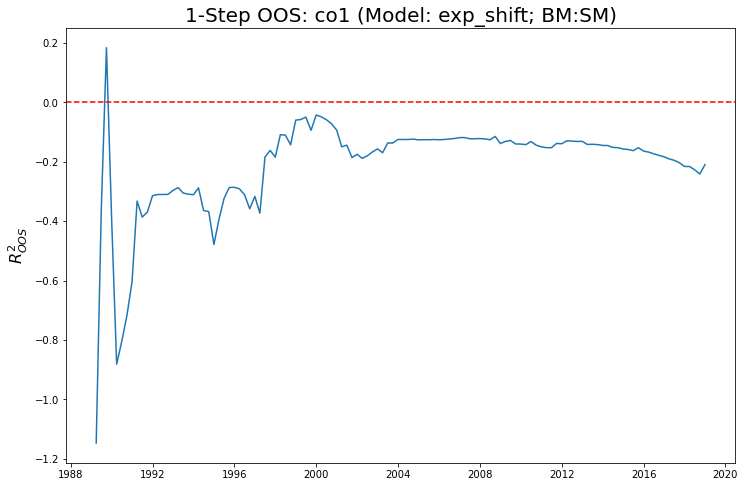

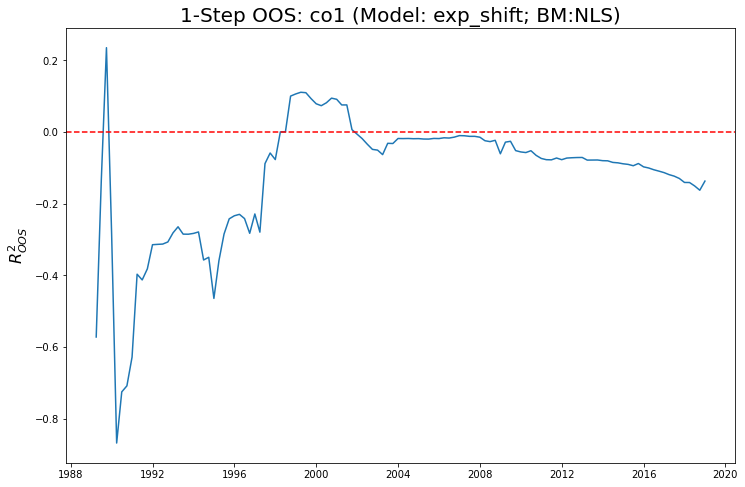

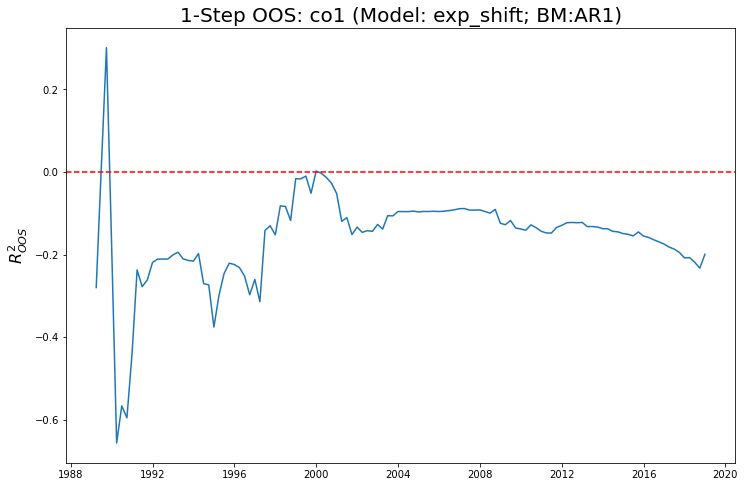

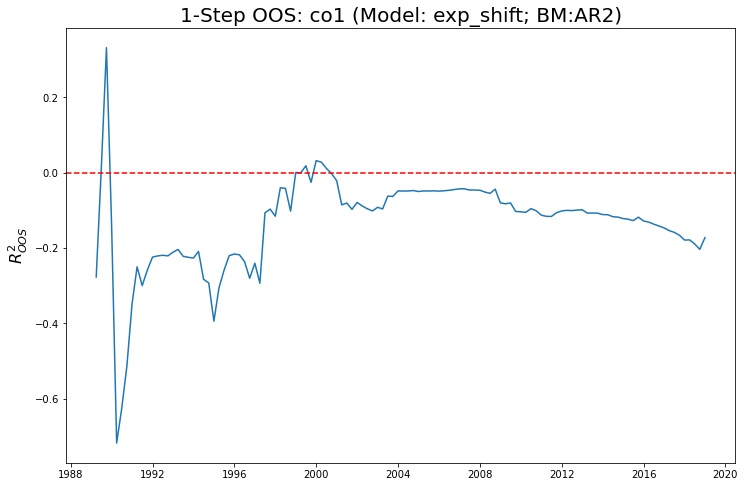

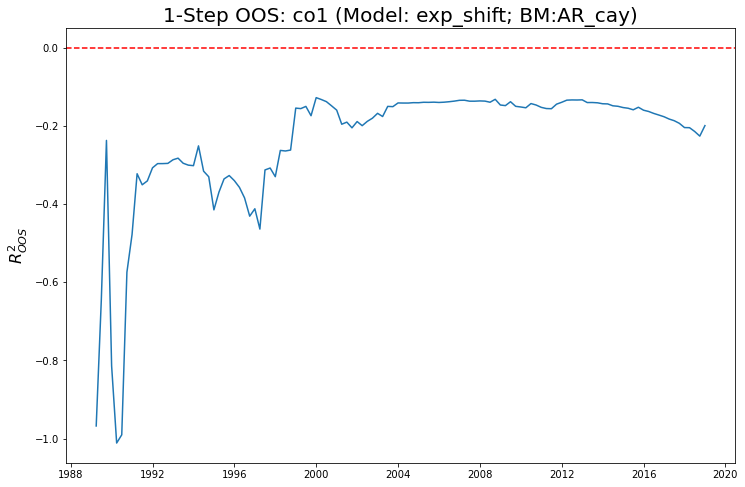

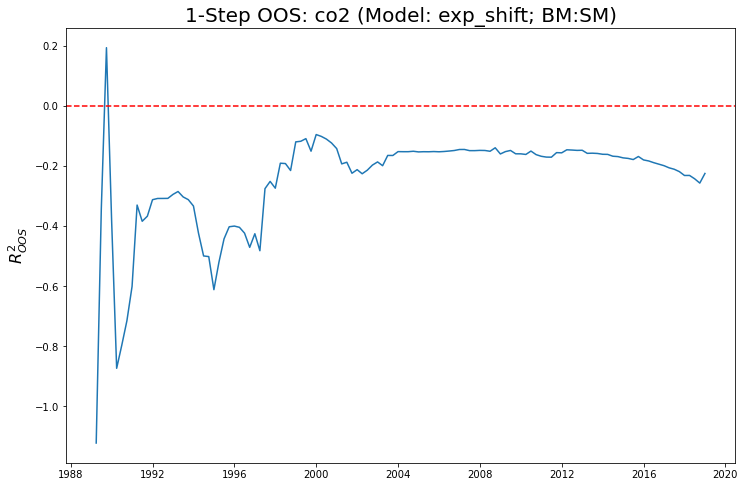

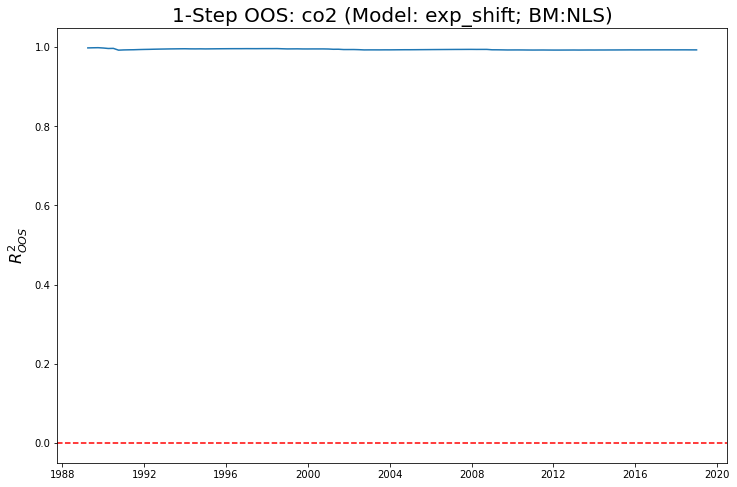

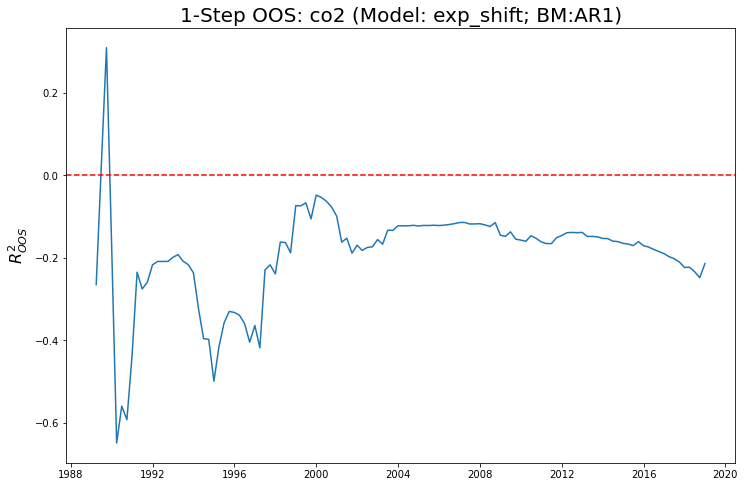

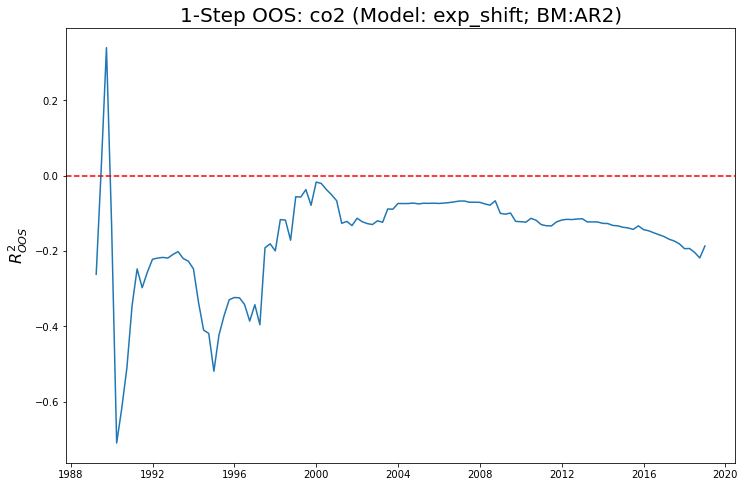

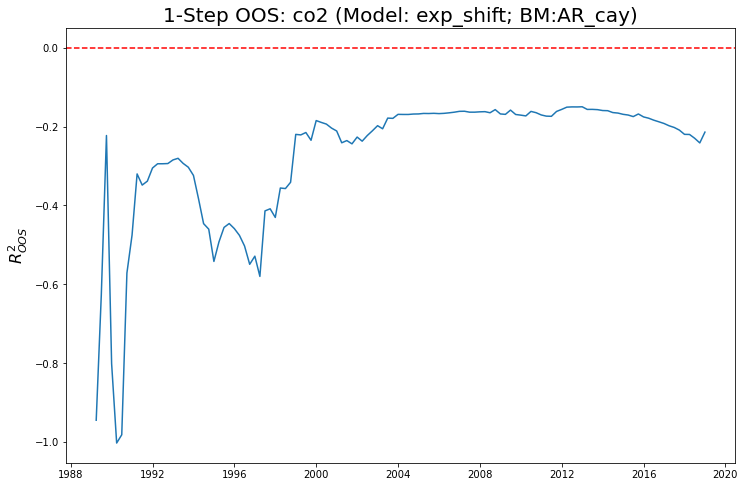

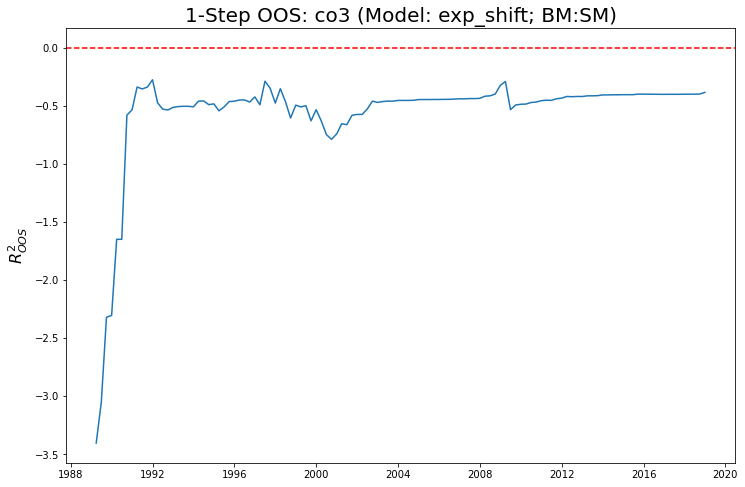

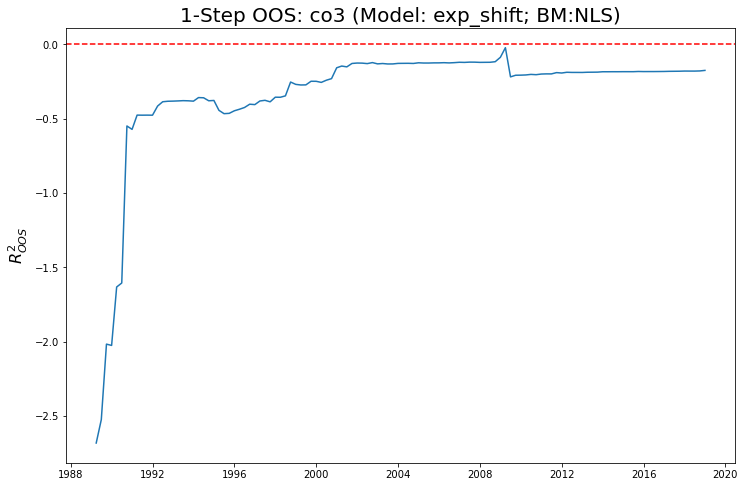

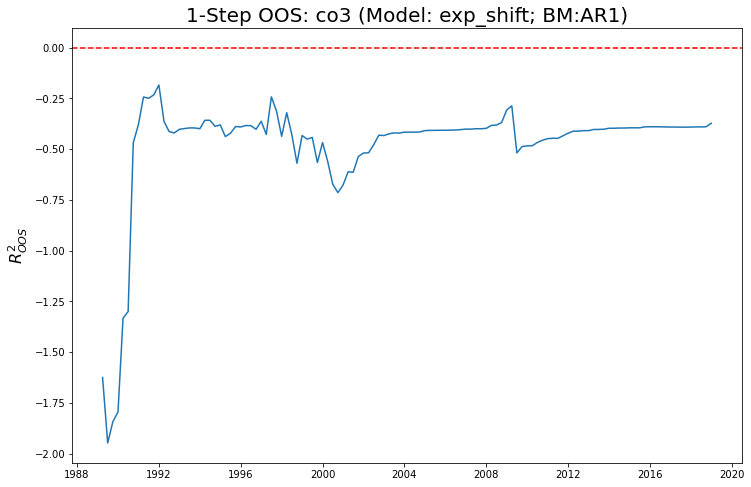

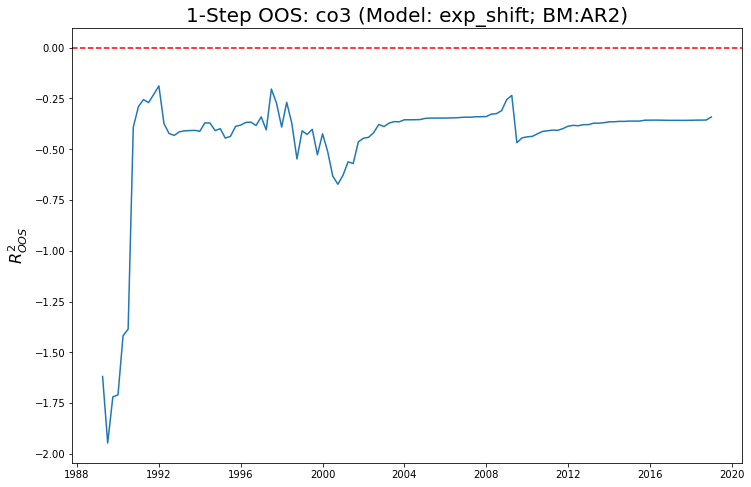

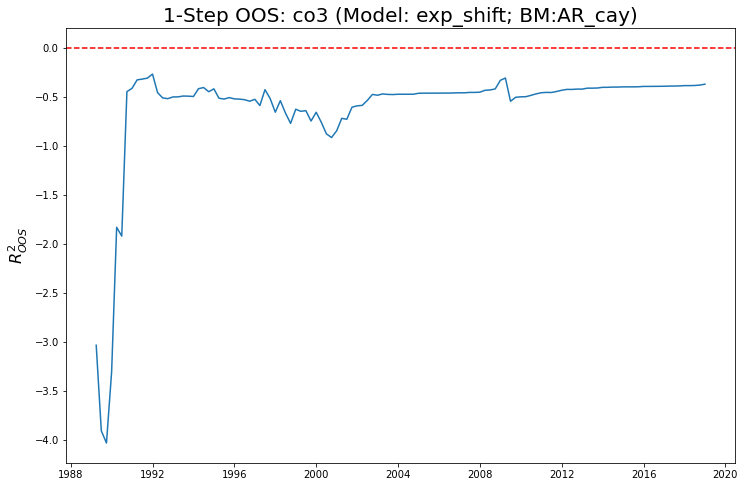

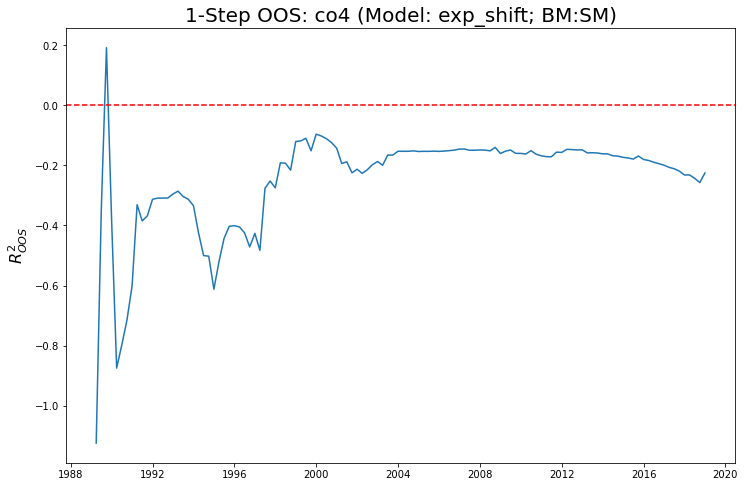

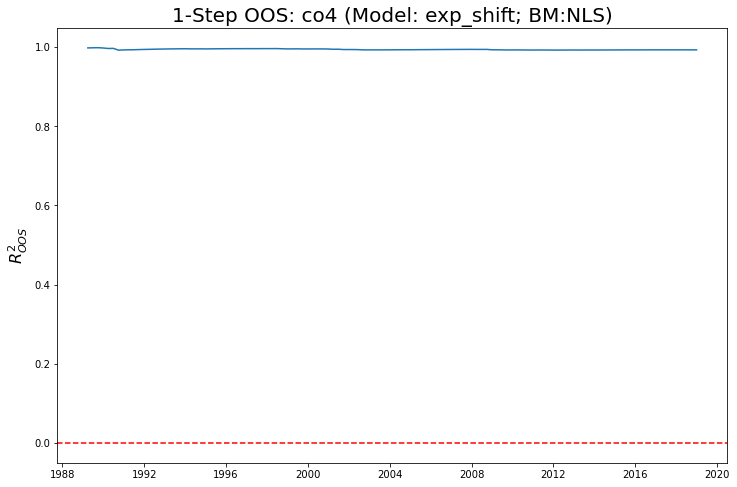

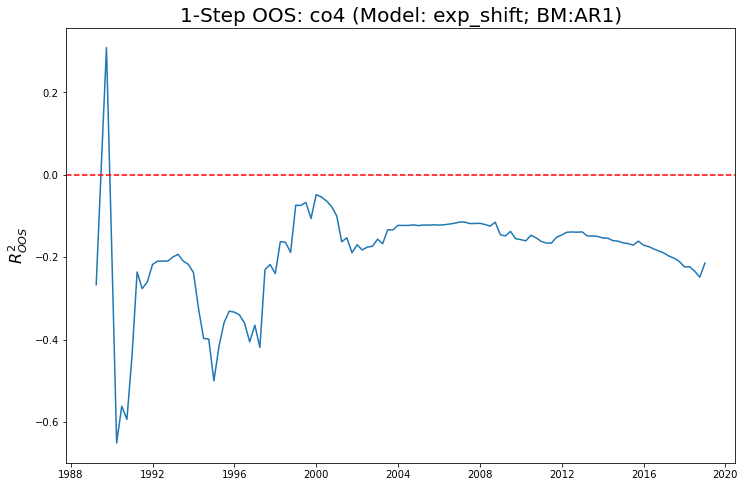

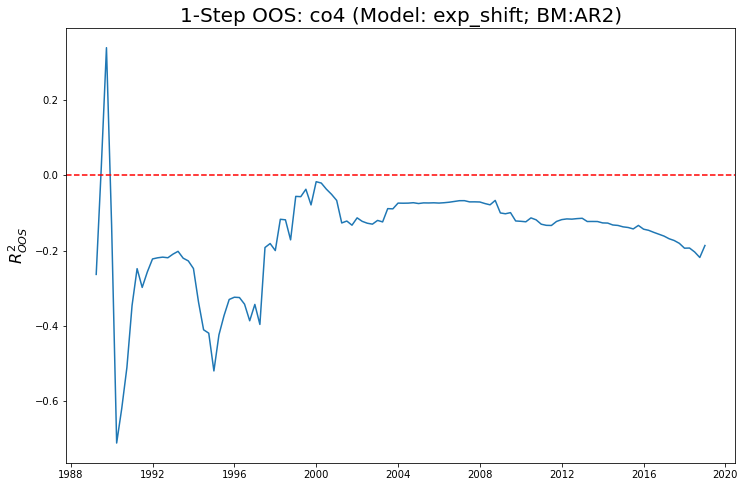

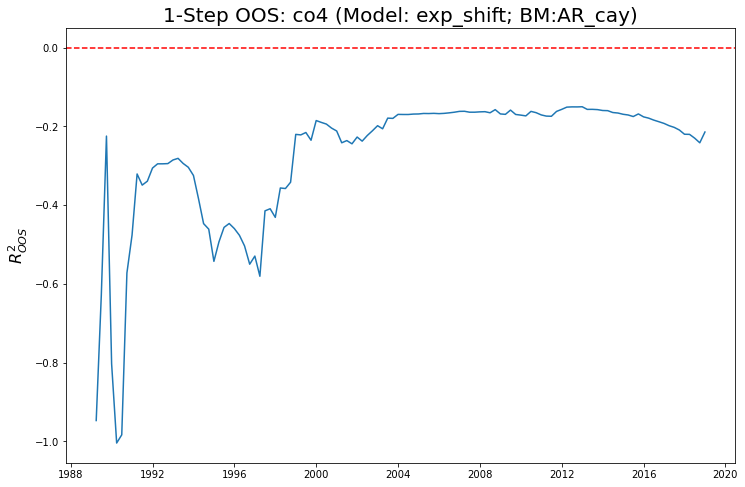

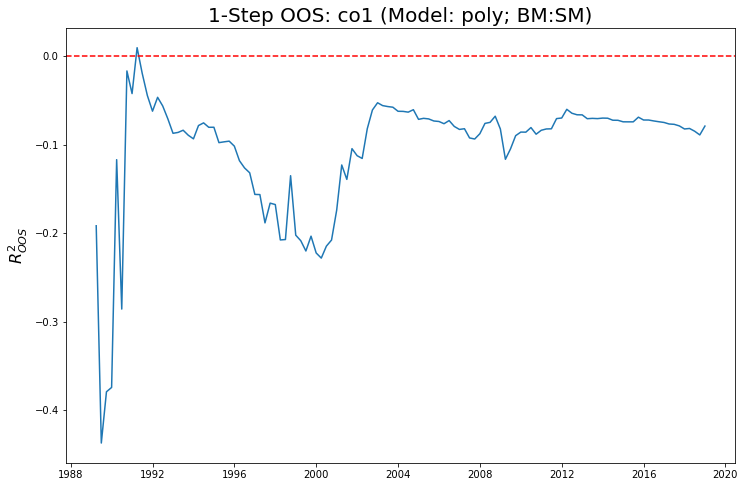

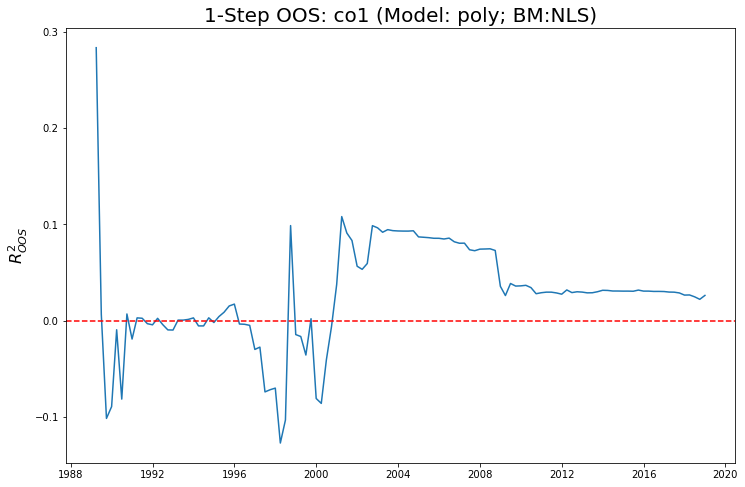

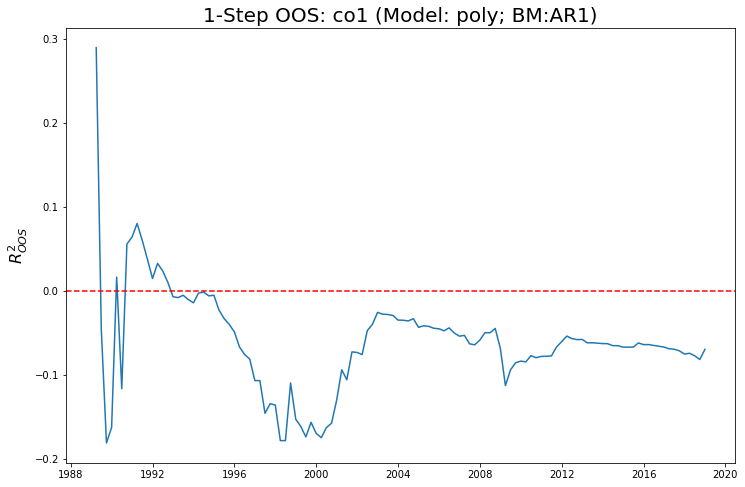

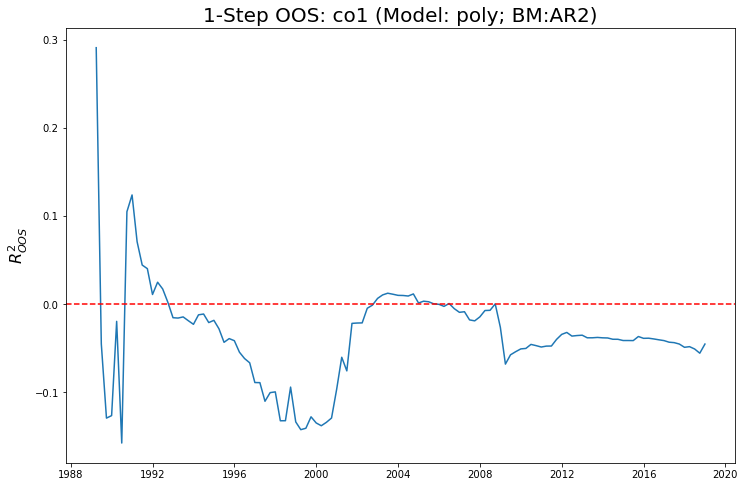

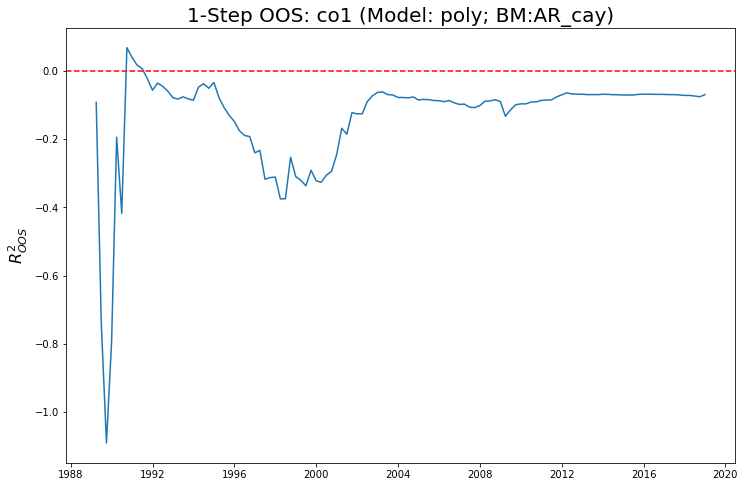

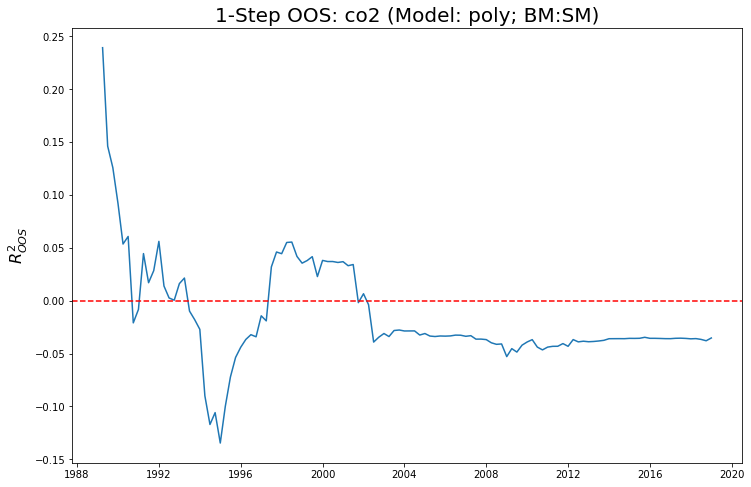

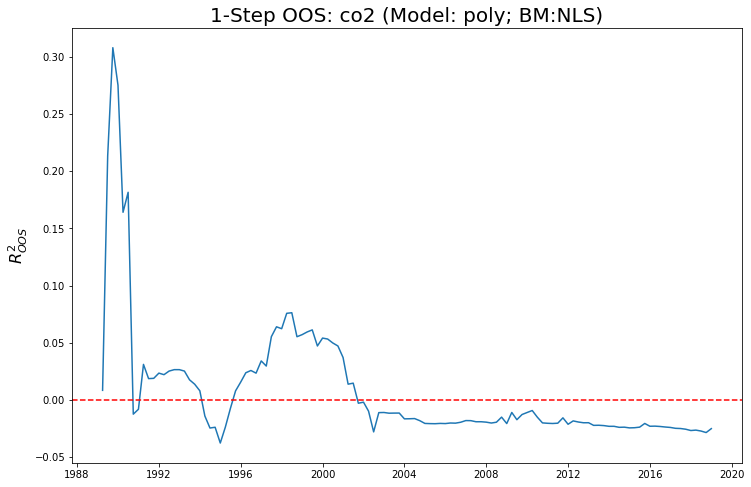

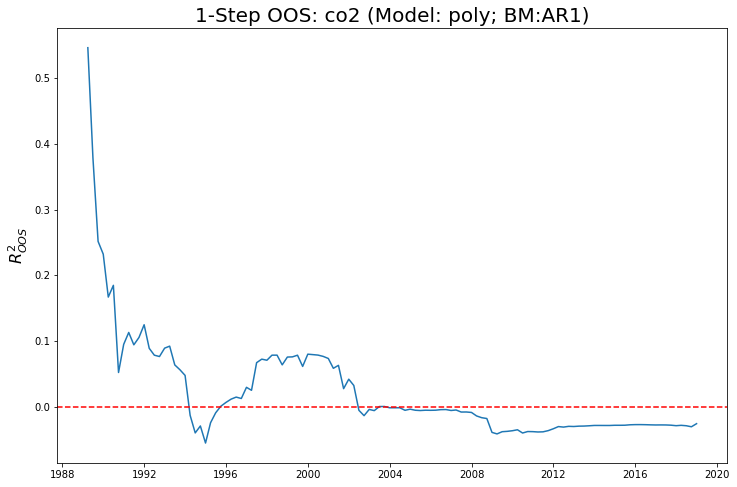

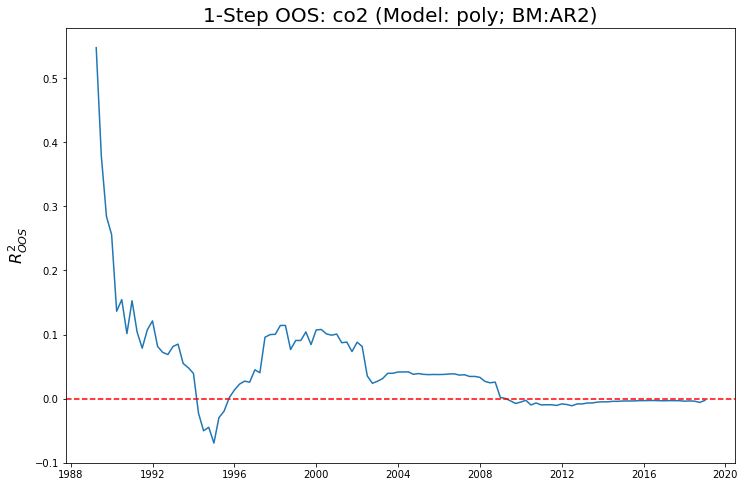

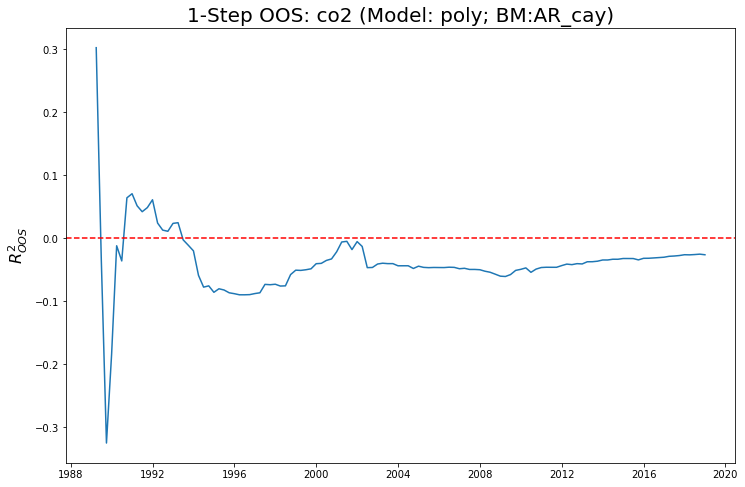

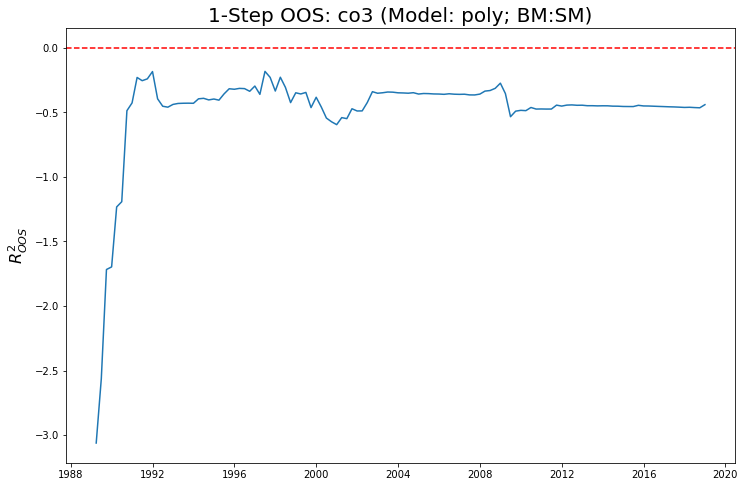

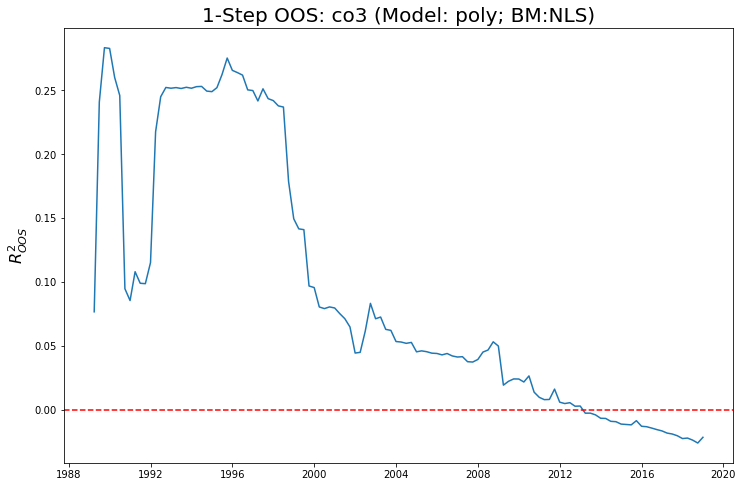

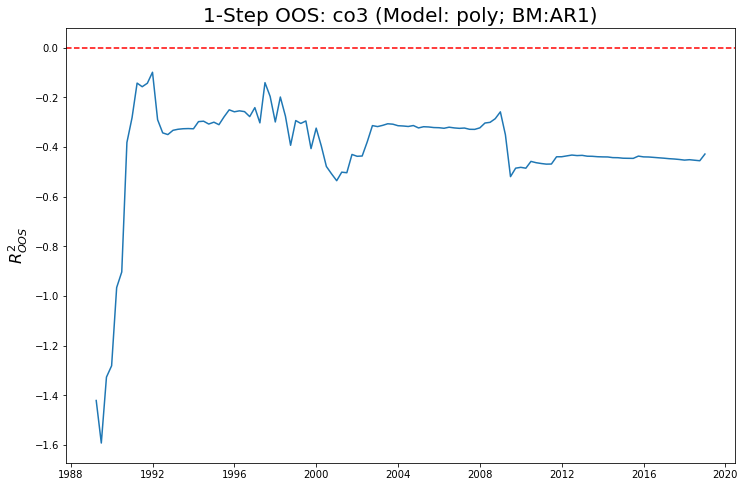

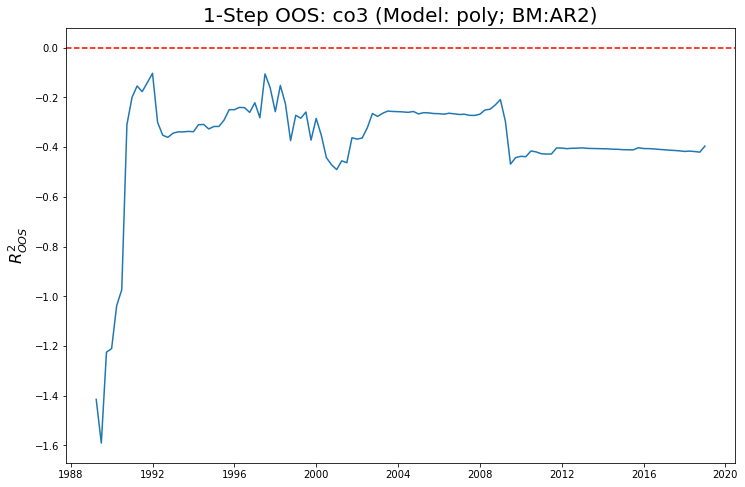

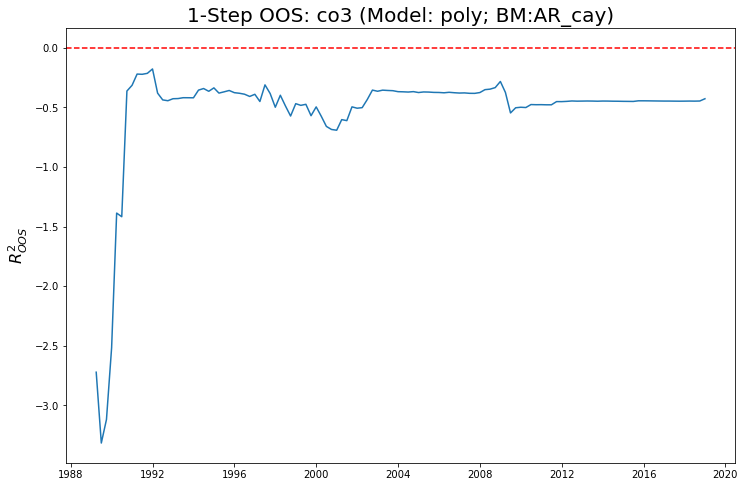

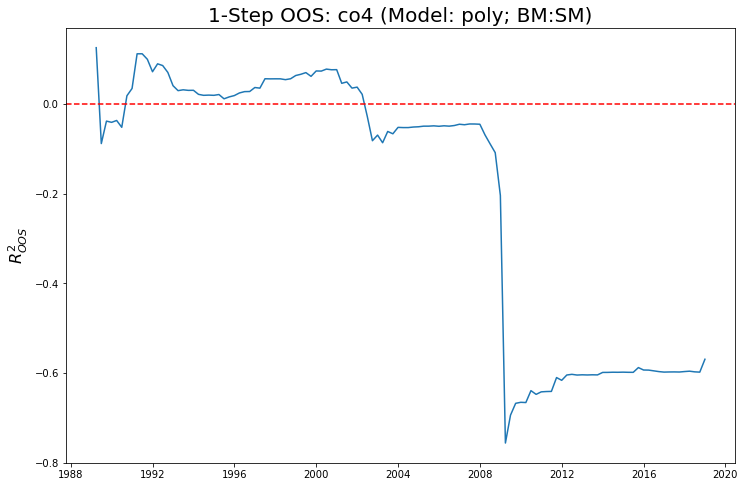

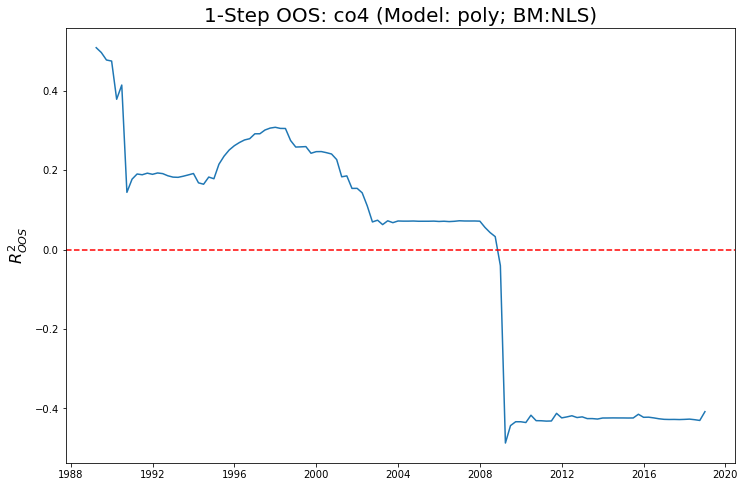

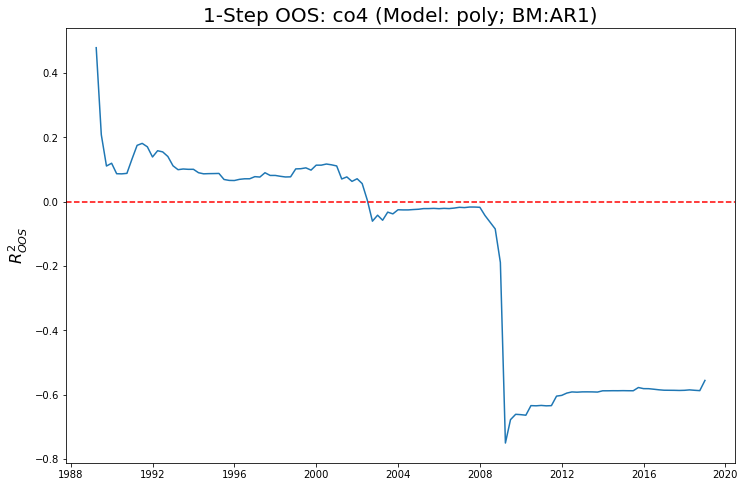

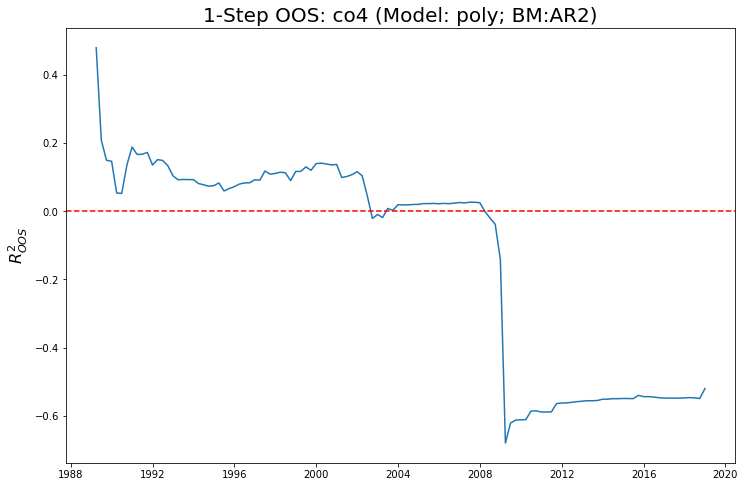

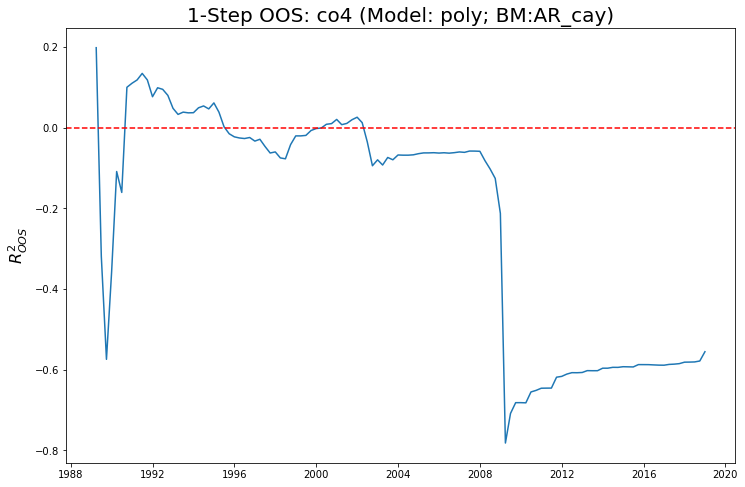

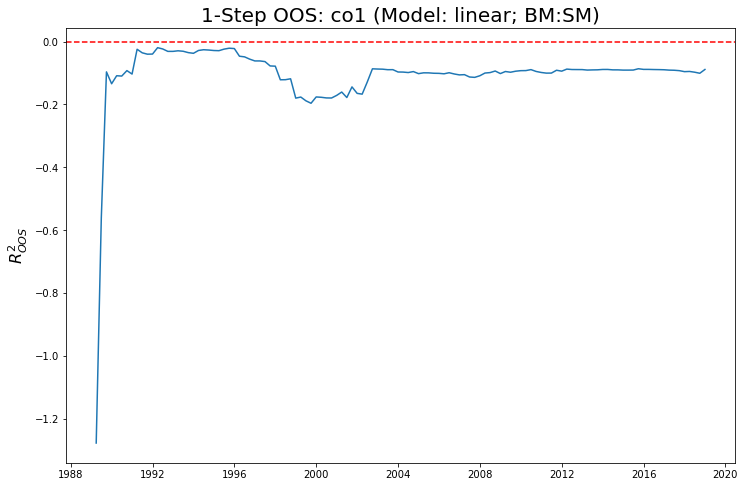

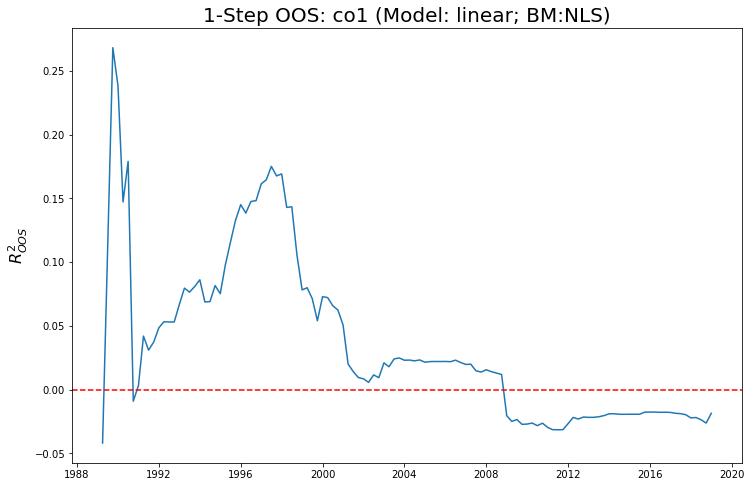

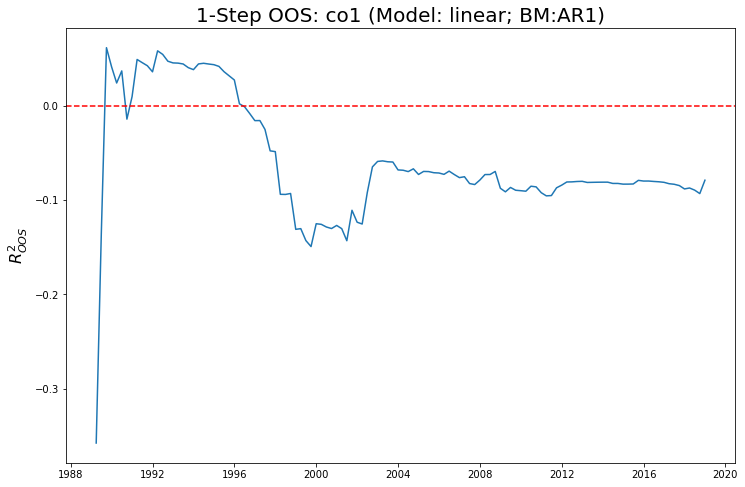

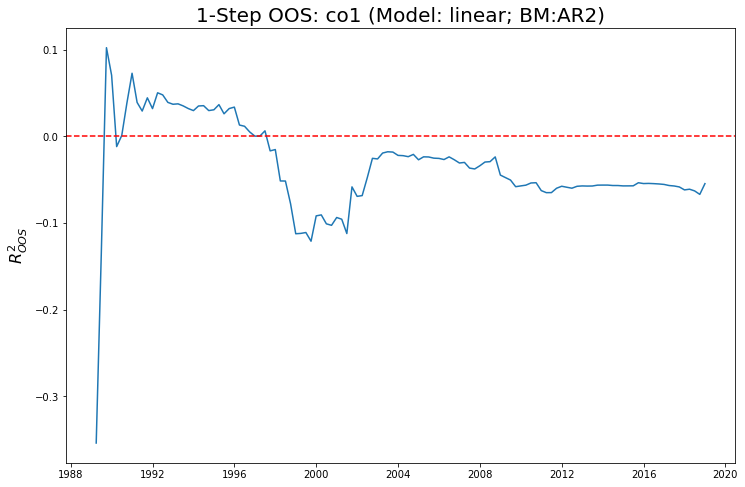

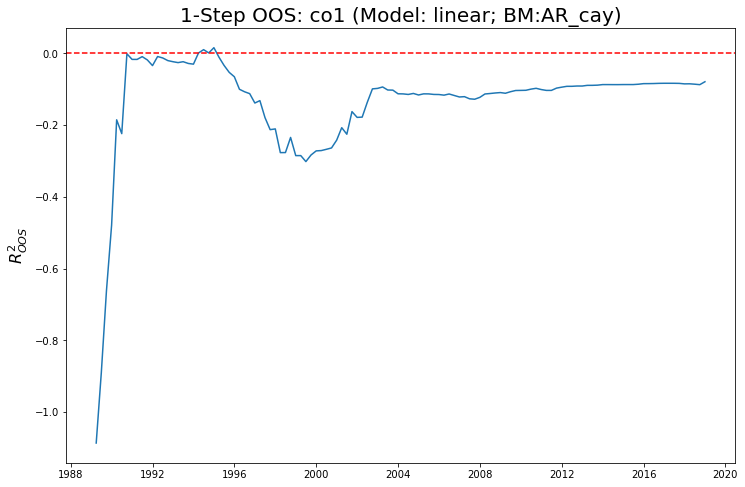

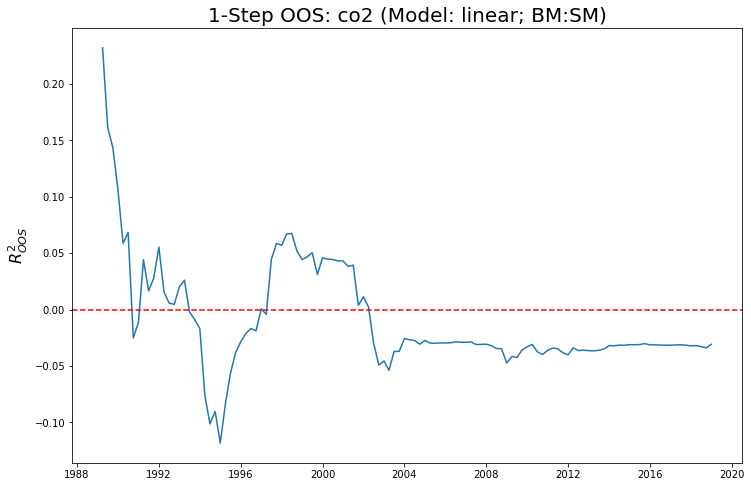

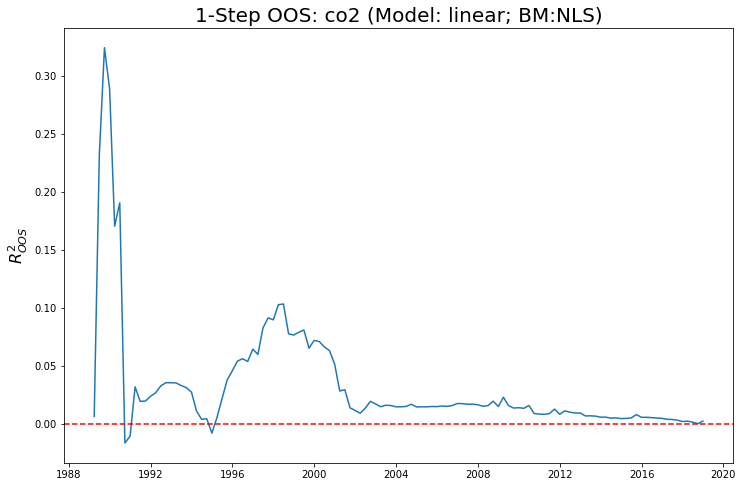

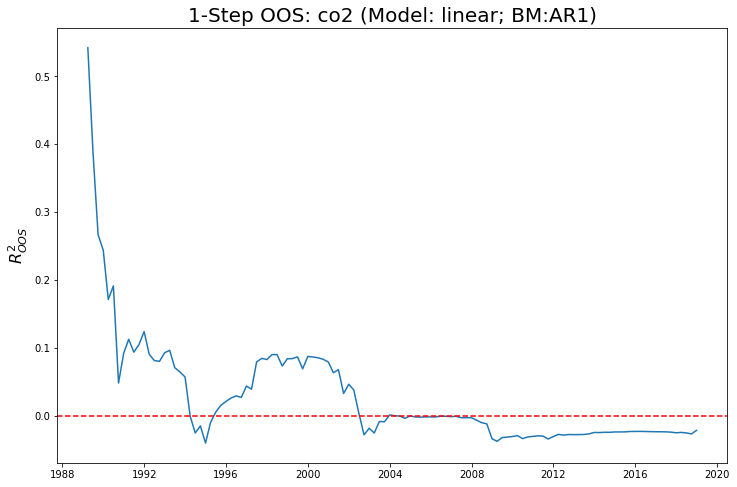

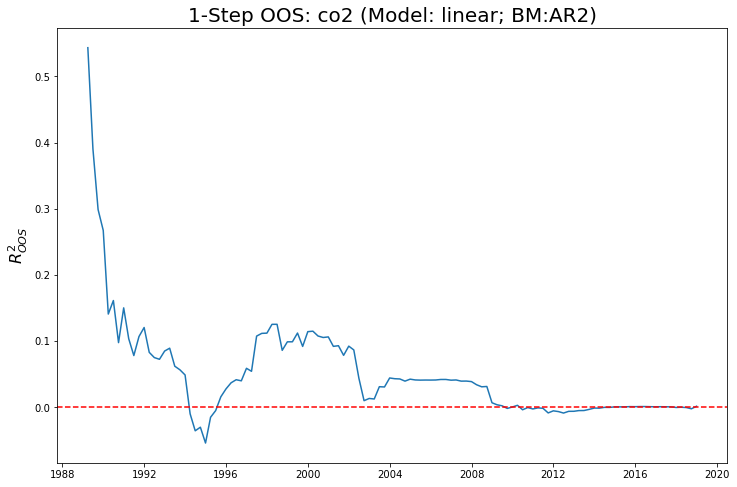

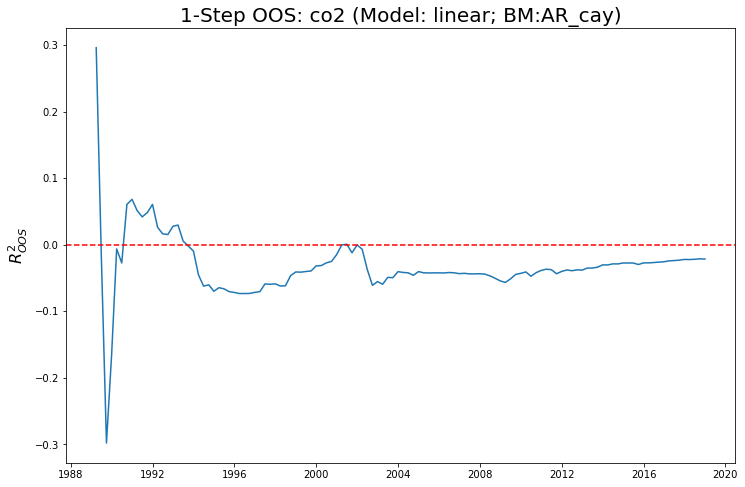

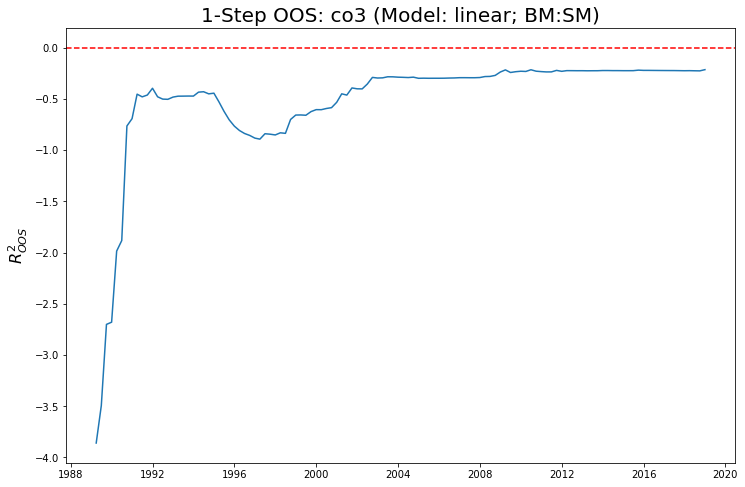

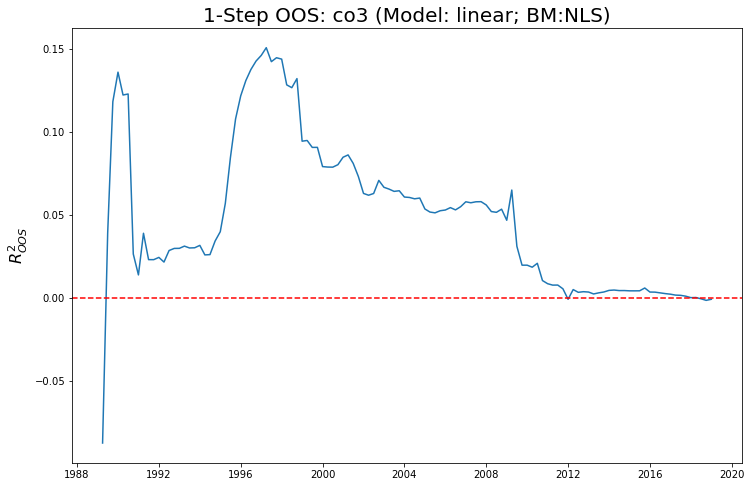

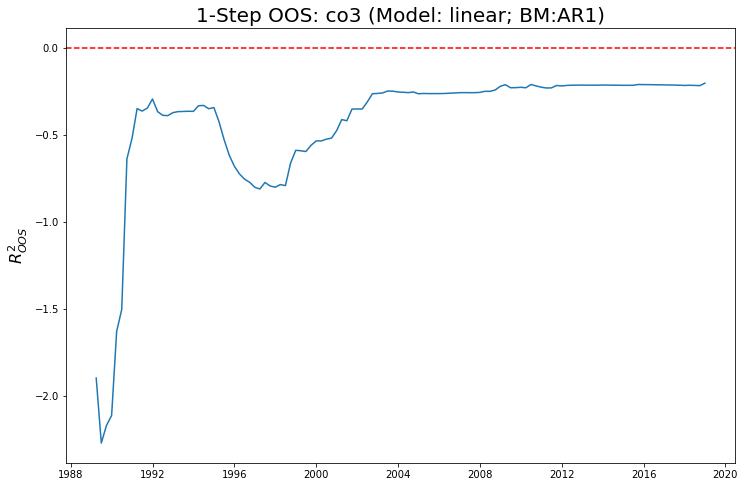

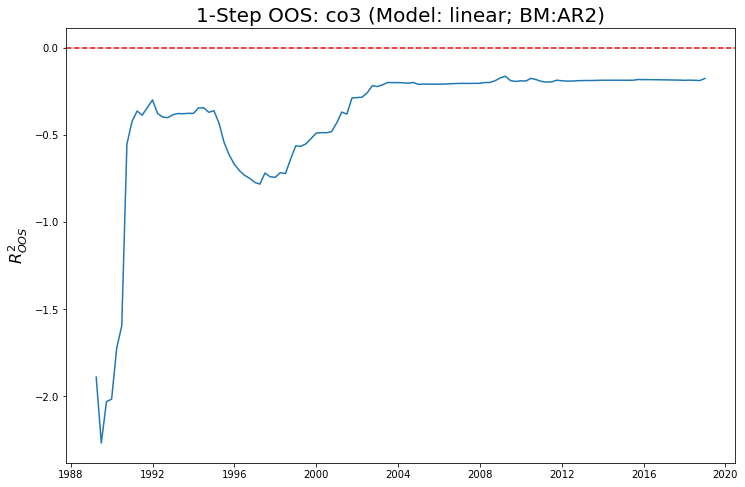

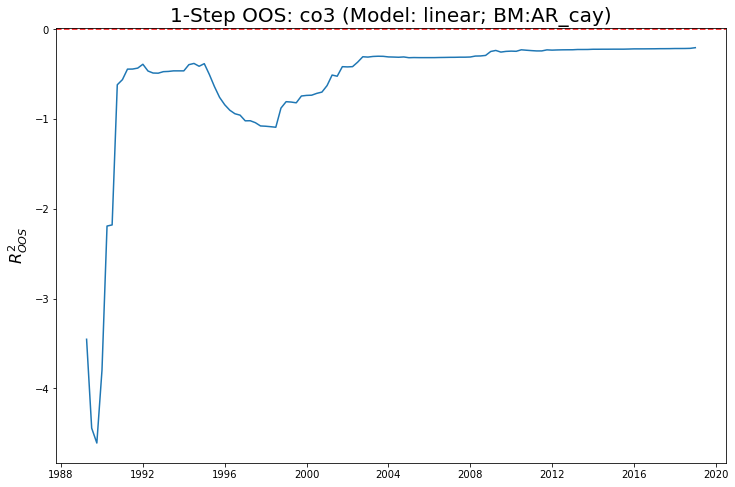

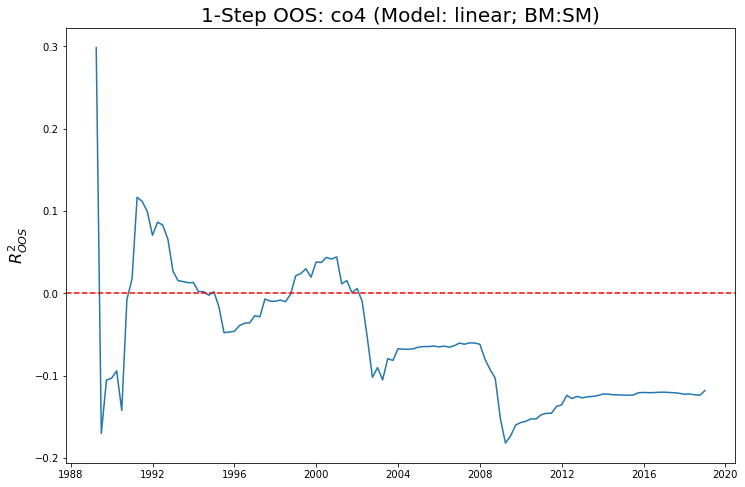

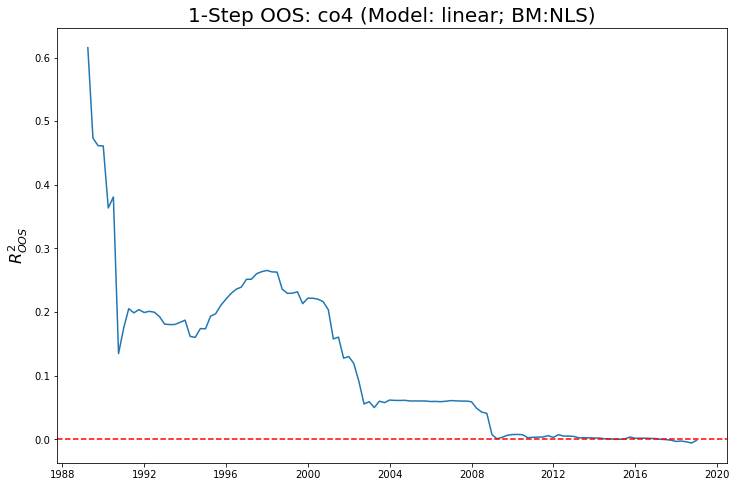

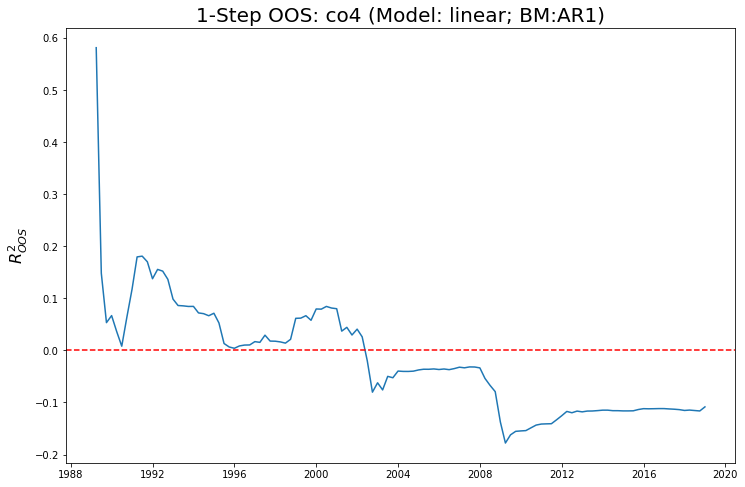

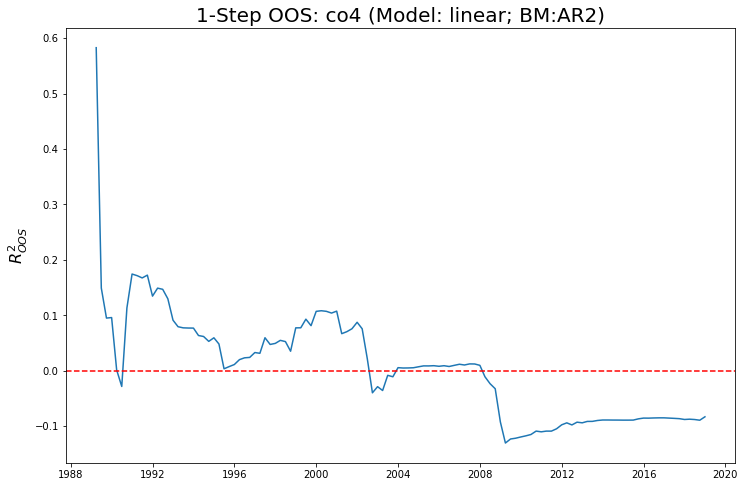

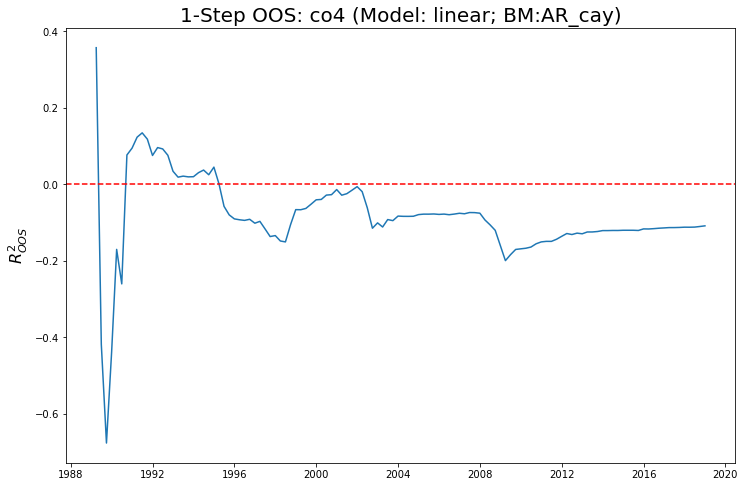

In [138]:
parent = os.getcwd()
folder = 'OOS_plots/taylor_1005'
path = os.path.join(parent, folder)
if not os.path.exists(path):
    os.makedirs(path)

for k in fun_list:
    R2 = pd.read_excel('results/R2_taylor_1005.xlsx', header=[0,1,2], index_col=0)['1989-03-01':]
    for i,j in itertools.product(cointe_ar1, base):
        fig = plt.figure(figsize = (12,8))
        plt.plot(R2[j+'_MSE'][k.__name__][i.name])
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('1-Step OOS: '+ i.name + ' (' + 'Model: '+ k.__name__[:-5] + '; BM:' + j + ')', fontsize=20)
        plt.ylabel("$R^2_{OOS}$", fontsize=16)
        plt.savefig(os.path.join(path, k.__name__[:-5] + '_' + i.name + '_' + j))

## Generate OOS MSE

### project 2 with real stock return

In [ ]:
rr = df['rr']
rfree = df['rfree']
station_n = pd.DataFrame()

### CER

In [ ]:
P2_pred = {}
        
for i in fun_list:
    print(i.__name__)
    for j in cointe_ar1:    
        # Prepare X
        X_ = j.join(station_n)
        pred_list = []
        ##################################### no need to loop! ##############################################################
        for train_index, test_index in cv_outer.split(X_):
#             print(train_index)
            X_train, X_test = X_.iloc[train_index, :], X_.iloc[test_index, :]
            rr_train, rr_test = rr.iloc[train_index], rr.iloc[test_index]
            # benchmark model: sm
            sm_pred, sm_mse = bench.sample_mean(rr, "1988-01-01", cv_outer = cv_outer)
            P2_pred['SM'] = sm_pred
            # benchmark model: Nonlinear
            station_n = pd.DataFrame()
            Models.param_num = {'theta':j.shape[1],
                                'beta':station_n.shape[1],
                                'gamma':extra_params[i.__name__]
                               }
    
            d1, d2, extra = Models.param_num['theta'], Models.param_num['beta'], Models.param_num['gamma']
        
            nlr = CLS_Estimator(obj_func = i, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(j))
            nlr.fit(X_train, rr_train)
            pred_list.append(nlr.predict(X_test)[0])
            P2_pred[(i.__name__, j.name)] = pred_list

P2_pred = pd.DataFrame.from_dict(P2_pred)
P2_pred = pd.read_excel('results/P2_signif/p2_pred.xlsx', header=[0,1], index_col=[0])

In [ ]:
sigma2 = []
for train_index, test_index in cv_outer.split(X_):
    X_train, X_test = X_.iloc[train_index, :], X_.iloc[test_index, :]
    rr_train, rr_test = rr.iloc[train_index], rr.iloc[test_index]
    sigma2.append((np.std(rr_train[-20:]))**2)

Rp_dict = {}
CER = {}
for j in P2_pred.columns:
    w = []
    w_raw = (1/5)*(np.asarray(P2_pred[j])/np.asarray(sigma2))
    for k,i in enumerate(w_raw):
        if i<0:
            w.append(0)
        elif i>1.5:
            w.append(1.5)
        else:
            w.append(i)
    Rp = w*rr['1988-03-01':]+rfree['1988-03-01':]
    Rp_dict[j] = Rp
    CER_cal = np.mean(Rp) - 0.5*5*(np.std(Rp)**2)
    CER[j] = CER_cal

Rp_dict = pd.DataFrame.from_dict(Rp_dict)
Rp_dict.to_excel('results/P2_signif/Rp.xlsx')

In [ ]:
CER = pd.DataFrame.from_dict(CER, orient = 'index', columns = ['CER'])
CER['delta_CER'] = CER['CER'] - CER.loc['SM'].values
CER.to_excel('results/P2_signif/CER.xlsx')

In [ ]:
P2_MSE = {}
        
for i in fun_list:
    print(i.__name__)
    for j in cointe_ar1:    
        # Prepare X
        X_ = j.join(station_ar1)
        
        ##################################### no need to loop! ##############################################################
        # benchmark model: sm
        sm_pred, sm_mse = bench.sample_mean(y, "1988-01-01", cv_outer = cv_outer)
        P2_MSE['SM'] = sm_mse
        # benchmark model: Nonlinear
        station_n = pd.DataFrame()
        d1, d2, extra= dimensions(j,station_n, i.__name__)
        
        nlr = CLS_Estimator(obj_func = i, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(j))
        cv_nonlinear = cross_validate(nlr, j, y, cv=cv_outer, scoring = 'neg_mean_squared_error')
        P2_MSE[(i.__name__, j.name)] = -cv_nonlinear['test_score']    
P2_MSE = pd.DataFrame.from_dict(P2_MSE)
P2_MSE.head()

In [ ]:
R2_dict = {}
for i, j in itertools.product(fun_list, cointe_ar1):
    cumu_sum = []
    target_sum = []
    cumu_R2 = []
    for R in range(P2_MSE.shape[0]):
        target_sum.append(P2_MSE[(i.__name__,j.name)][-(R+1):].sum())
        cumu_sum.append(P2_MSE['SM'][-(R+1):].sum())
    cumu_R2 = [1 - x/y for x,y in zip(target_sum, cumu_sum)]
    R2_dict[(i.__name__, j.name)] = cumu_R2
P2_R2 = pd.DataFrame.from_dict(R2_dict)
P2_R2.to_excel('results/P2_signif/P2_R2.xlsx')

In [ ]:
co_list = ['co1', 'co2', 'co3', 'co4']
co_dict = {'co1': 'dy and dp',
          'co2': 'tbl and lty',
          'co3': 'dp and ep',
          'co4': 'BAA and AAA'}

## Regenerate results for project 2

In [ ]:
writer_R2 = pd.ExcelWriter('results/OOS_R2_project2.xlsx', engine='xlsxwriter')

for f in fun_list:
    oos_MSE = pd.read_excel('results/OOS_MSE_start0.xlsx', header=[0,1], index_col=0, sheet_name = f)
    for i, j in itertools.product(base, co_list):
        cumu_sum = []
        target_sum = []
        cumu_R2 = []
        k = i + '_MSE'
        for R in range(len(oos_MSE[j][k])):
            target_sum.append(oos_MSE[j]['NLS_MSE'][-(R+1):].sum())
            cumu_sum.append(oos_MSE[j][k][-(R+1):].sum())
        cumu_R2 = [1 - x/y for x,y in zip(target_sum, cumu_sum)]
        cumulate_R2.loc[j].loc[i] = cumu_R2
    cumulate_R2.T.to_excel(writer_R2, sheet_name=f)
writer_R2.save()
writer_R2.close()

In [ ]:
fun_list = ['sin_func',
            'cos_func',
            'scaled_sin_func',
            'scaled_cos_func',
            'exp_shift_func',
            'exp_func',
            'poly_func']

In [ ]:
parent = os.getcwd()
folder = 'OOS_plots/project2'
path = os.path.join(parent, folder)
if not os.path.exists(path):
    os.makedirs(path)

for k in fun_list:
    R2 = pd.read_excel('results/OOS_R2_project2.xlsx', header=[0,1], index_col=0, sheet_name = k)
    for i in co_list:
#         print(i)
        fig = plt.figure(figsize = (12,8))
        plt.plot(R2[i]['SM'])
        plt.axhline(y=0, color='r', linestyle='--')
        
        plt.title('1-Step OOS: '+ i + ' (' + 'Model: '+ k[:-5] + '; BM:' + 'SM' + ', start:0)', fontsize=20)
        plt.ylabel("$R^2_{OOS}$", fontsize=16)
        plt.savefig(os.path.join(path, k[:-5] + '_' + i + '_' + 'SM' + '_0'))

# Plot U

In [ ]:
results = pd.read_excel('results/full_sample.xlsx', header=[0,1], index_col=[0,1])
results_taylor = pd.read_excel('results/Taylor_fullsample.xlsx', header=[0,1], index_col=[0,1])

In [ ]:
#Set up directory
parent = os.getcwd()
folder = 'single_index'
path = os.path.join(parent, folder)
if not os.path.exists(path):
    os.makedirs(path)

for k in fun_list:
    for i,j in enumerate(cointe_ar2):
        fig = plt.figure(figsize = (8,6))
        plt.plot(single_index(j)(results_taylor['CLS'][['param_1', 'param_2']].loc[k].loc[co_list[i]]))
        plt.title('single-index: '+ co_list[i] + ' (' + 'Model: '+ k[:-5] + ')', fontsize=20)
        plt.savefig(os.path.join(path, k[:-5] + '_' + co_list[i]))

# In-sample $R^2$

In [ ]:
station_n = pd.DataFrame()

In [ ]:
writer_R3 = pd.ExcelWriter('insample_R2_newcay.xlsx', engine='xlsxwriter')

R2_insample = pd.DataFrame()
for i, j in itertools.product(fun_list, cointe_ar1):
    # Set up dimensions
    Models.param_num = {'theta':j.shape[1],
                        'beta':station_ar1.shape[1],
                        'gamma':extra_params[i.__name__]
                       }
    
    d1, d2, extra = Models.param_num['theta'], Models.param_num['beta'], Models.param_num['gamma']
    
    # Set up dataframes
    iterables = [[i.__name__], [j.name]]
    sec_columns = ['in_sample R2']
    multi_index = pd.MultiIndex.from_product(iterables, names=["function", "variables"])
    R2_in = pd.DataFrame(index = multi_index, columns = sec_columns)
    
    # Prepare X
    X_ = j.join(station_ar1)
    d1, d2, extra= dimensions(j,station_n, i.__name__)
    initial_len = d1+d2+extra[-1]+1
    
    # Fit models
    cls = CLS_Estimator(obj_func = i, x0 = Taylor_init(j, station_ar1, y, i), constraints = constraint_func(X_))
    cls.fit(X_, y)
    R2_ins = 1 - np.sum((cls.predict(X_) - np.array(y))**2)/np.sum((np.array(y)-np.mean(y))**2)
    R2_in.loc[i.__name__,j.name].loc['in_sample R2'] = R2_ins
    R2_insample = R2_insample.append(R2_in, ignore_index = False, sort = False)
    R2_insample.to_excel(writer_R3)
writer_R3.save()
writer_R3.close()

# NLS significance of $R^2$

In [ ]:
#Set up directory
parent = os.getcwd()
folder = 'P2_signif'
path = os.path.join(os.path.join(parent, 'result'), folder)
if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
result_dict = {}
for i,j in itertools.product(fun_list, cointe_ar1):
#     print(i.__name__, j.name)
    pred = np.empty(0)
    for train, test in cv_outer.split(j):
        station_n = pd.DataFrame()
        d1, d2, extra= dimensions(j,station_n, i.__name__)
        # CLS without linear part
        nlr = CLS_Estimator(obj_func = i, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(j))
        nlr.fit(j.iloc[train,:],y.iloc[train])
        pred = np.append(pred, nlr.predict(j.iloc[test,:]))
    result_dict[(i.__name__, j.name)] = pred

In [ ]:
p2_pred = pd.DataFrame.from_dict(result_dict)
p2_pred.to_excel(path+'/p2_pred_original.xlsx', engine='xlsxwriter')

In [ ]:
p2_pred.index = y[-124:].index
p2_pred['EQP'] = y[-124:]

In [ ]:
sm_pred, sm_mse = bench.sample_mean(y, "1988-01-01", cv_outer = cv_outer)
p2_pred['SM'] = sm_pred

In [ ]:
sig_dict = {}
for i,j in itertools.product(fun_list, cointe_ar1):
    y_hat = p2_pred[i.__name__][j.name]
    y_sm = p2_pred['SM']
    y_true = p2_pred['EQP']
    sig_dict[(i.__name__, j.name)] = (y_true - y_sm)**2 - (y_true - y_hat)**2 + (y_sm - y_hat)**2

In [ ]:
sig_df = pd.DataFrame.from_dict(sig_dict)
sig_df.head()

In [ ]:
tp_dict = {}
# p_dict = {}
for i,j in itertools.product(fun_list, cointe_ar1):
    t_val = []
    p_val = []
    for k in range(4,sig_df.shape[0]):
        x = np.repeat(1, k).reshape(-1,1)
        ind = sig_df.index[k-1]
        models = sm.OLS(sig_df[i.__name__][j.name].loc[:ind],x)
        result = models.fit()
        t_val.append(result.tvalues[0])
        p_val.append(result.pvalues[0])
#     tp_dict[(i.__name__, j.name, 't')] = t_val
    tp_dict[i.__name__, j.name] = p_val

In [ ]:
p_df = pd.DataFrame.from_dict(tp_dict)
p_df.tail()

In [ ]:
# tp_df.to_excel('tp_vals.xlsx')

In [ ]:
small_ps = []
for index, row in p_df.iterrows():
    l = [1 if i <= 0.1 else 0 for i in row.values ]
    small_ps.append(np.sum(l))

In [ ]:
p_df.iloc[-1].to_excel((path+'sig_20181201.xlsx')

## Others

In [ ]:
# dfp = pd.read_excel('frustrated.xlsx', index_col = 0)
# dfp.head()

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8)) 
# dfp['Figure3'].plot()
# plt.hlines(y = 0, xmin = 0, xmax = 130, colors='r')
# plt.xticks(rotation=45)
# plt.ylabel('$R^2_{OOS}$', fontsize=18)
# filename = 'cwy(f4).png'
# plt.savefig(fname = filename)

In [ ]:
|